In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

# Setting random seed to obtain reproducible results.
import tensorflow as tf

tf.random.set_seed(42)

import keras
from keras import layers

import os
import glob
import imageio.v2 as imageio
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize global variables.
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 5
NUM_SAMPLES = 32
POS_ENCODE_DIMS = 16
EPOCHS = 100

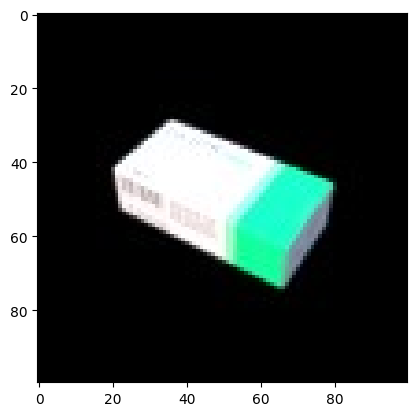

In [2]:
data = np.load("/kaggle/input/d/ianpang1004/image-from-blender/NERF.npz")
images = data["images"]
im_shape = images.shape
(num_images, H, W, _) = images.shape
(poses, focal) = (data["poses"], data["focal"])

# Plot a random image from the dataset for visualization.
plt.imshow(images[np.random.randint(low=0, high=num_images)])
plt.show()

In [3]:
def encode_position(x):
    """Encodes the position into its corresponding Fourier feature.

    Args:
        x: The input coordinate.

    Returns:
        Fourier features tensors of the position.
    """
    positions = [x]
    for i in range(POS_ENCODE_DIMS):
        for fn in [tf.sin, tf.cos]:
            positions.append(fn(2.0**i * x))
    return tf.concat(positions, axis=-1)


def get_rays(height, width, focal, pose):
    """Computes origin point and direction vector of rays.

    Args:
        height: Height of the image.
        width: Width of the image.
        focal: The focal length between the images and the camera.
        pose: The pose matrix of the camera.

    Returns:
        Tuple of origin point and direction vector for rays.
    """
    # Build a meshgrid for the rays.
    i, j = tf.meshgrid(
        tf.range(width, dtype=tf.float32),
        tf.range(height, dtype=tf.float32),
        indexing="xy",
    )

    # Normalize the x axis coordinates.
    transformed_i = (i - width * 0.5) / focal

    # Normalize the y axis coordinates.
    transformed_j = (j - height * 0.5) / focal

    # Create the direction unit vectors.
    directions = tf.stack([transformed_i, -transformed_j, -tf.ones_like(i)], axis=-1)

    # Get the camera matrix.
    camera_matrix = tf.cast(pose[:3, :3], tf.float32)  # Convertir a float32
    height_width_focal = tf.cast(pose[:3, -1], tf.float32)  # Pose matrix for translation

    # Get origins and directions for the rays.
    transformed_dirs = directions[..., None, :]
    camera_dirs = transformed_dirs * camera_matrix
    ray_directions = tf.reduce_sum(camera_dirs, axis=-1)
    ray_origins = tf.broadcast_to(height_width_focal, tf.shape(ray_directions))

    # Asegurarse de que ray_origins y ray_directions sean float32.
    ray_origins = tf.cast(ray_origins, tf.float32)
    ray_directions = tf.cast(ray_directions, tf.float32)

    # Return the origins and directions.
    return (ray_origins, ray_directions)


def render_flat_rays(ray_origins, ray_directions, near, far, num_samples, rand=False):
    """Renders the rays and flattens it.

    Args:
        ray_origins: The origin points for rays.
        ray_directions: The direction unit vectors for the rays.
        near: The near bound of the volumetric scene.
        far: The far bound of the volumetric scene.
        num_samples: Number of sample points in a ray.
        rand: Choice for randomising the sampling strategy.

    Returns:
       Tuple of flattened rays and sample points on each rays.
    """
    # Compute 3D query points.
    # Equation: r(t) = o+td -> Building the "t" here.
    t_vals = tf.linspace(near, far, num_samples)
    if rand:
        # Inject uniform noise into sample space to make the sampling
        # continuous.
        shape = list(ray_origins.shape[:-1]) + [num_samples]
        noise = tf.random.uniform(shape=shape) * (far - near) / num_samples
        t_vals = t_vals + noise

    # Equation: r(t) = o + td -> Building the "r" here.
    rays = ray_origins[..., None, :] + (
        ray_directions[..., None, :] * t_vals[..., None]
    )
    rays_flat = tf.reshape(rays, [-1, 3])
    rays_flat = encode_position(rays_flat)
    return (rays_flat, t_vals)


def map_fn(pose):
    """Maps individual pose to flattened rays and sample points.

    Args:
        pose: The pose matrix of the camera.

    Returns:
        Tuple of flattened rays and sample points corresponding to the
        camera pose.
    """
    (ray_origins, ray_directions) = get_rays(height=H, width=W, focal=focal, pose=pose)
    (rays_flat, t_vals) = render_flat_rays(
        ray_origins=ray_origins,
        ray_directions=ray_directions,
        near=2.0,
        far=6.0,
        num_samples=NUM_SAMPLES,
        rand=True,
    )
    return (rays_flat, t_vals)


# Create the training split.
split_index = int(num_images * 0.8)

# Split the images into training and validation.
train_images = images[:split_index]
val_images = images[split_index:]

# Split the poses into training and validation.
train_poses = poses[:split_index]
val_poses = poses[split_index:]

# Make the training pipeline.
train_img_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_pose_ds = tf.data.Dataset.from_tensor_slices(train_poses)
train_ray_ds = train_pose_ds.map(map_fn, num_parallel_calls=AUTO)
training_ds = tf.data.Dataset.zip((train_img_ds, train_ray_ds))
train_ds = (
    training_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

# Make the validation pipeline.
val_img_ds = tf.data.Dataset.from_tensor_slices(val_images)
val_pose_ds = tf.data.Dataset.from_tensor_slices(val_poses)
val_ray_ds = val_pose_ds.map(map_fn, num_parallel_calls=AUTO)
validation_ds = tf.data.Dataset.zip((val_img_ds, val_ray_ds))
val_ds = (
    validation_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

In [4]:
def get_nerf_model(num_layers, num_pos):
    """Generates the NeRF neural network.

    Args:
        num_layers: The number of MLP layers.
        num_pos: The number of dimensions of positional encoding.

    Returns:
        The `keras` model.
    """
    inputs = keras.Input(shape=(num_pos, 2 * 3 * POS_ENCODE_DIMS + 3))
    x = inputs
    for i in range(num_layers):
        x = layers.Dense(units=64, activation="relu")(x)
        if i % 4 == 0 and i > 0:
            # Inject residual connection.
            x = layers.concatenate([x, inputs], axis=-1)
    outputs = layers.Dense(units=4)(x)
    return keras.Model(inputs=inputs, outputs=outputs)


def render_rgb_depth(model, rays_flat, t_vals, rand=True, train=True):
    """Generates the RGB image and depth map from model prediction.

    Args:
        model: The MLP model that is trained to predict the rgb and
            volume density of the volumetric scene.
        rays_flat: The flattened rays that serve as the input to
            the NeRF model.
        t_vals: The sample points for the rays.
        rand: Choice to randomise the sampling strategy.
        train: Whether the model is in the training or testing phase.

    Returns:
        Tuple of rgb image and depth map.
    """
    # Get the predictions from the nerf model and reshape it.
    if train:
        predictions = model(rays_flat)
    else:
        predictions = model.predict(rays_flat)
    predictions = tf.reshape(predictions, shape=(BATCH_SIZE, H, W, NUM_SAMPLES, 4))

    # Slice the predictions into rgb and sigma.
    rgb = tf.sigmoid(predictions[..., :-1])
    sigma_a = tf.nn.relu(predictions[..., -1])

    # Get the distance of adjacent intervals.
    delta = t_vals[..., 1:] - t_vals[..., :-1]
    # delta shape = (num_samples)
    if rand:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, H, W, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta)
    else:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta[:, None, None, :])

    # Get transmittance.
    exp_term = 1.0 - alpha
    epsilon = 1e-10
    transmittance = tf.math.cumprod(exp_term + epsilon, axis=-1, exclusive=True)
    weights = alpha * transmittance
    rgb = tf.reduce_sum(weights[..., None] * rgb, axis=-2)

    if rand:
        depth_map = tf.reduce_sum(weights * t_vals, axis=-1)
    else:
        depth_map = tf.reduce_sum(weights * t_vals[:, None, None], axis=-1)
    return (rgb, depth_map)


Epoch 1/100


I0000 00:00:1731208715.767502     100 service.cc:145] XLA service 0x7bfd90053ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731208715.767575     100 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731208715.767580     100 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1731208716.389296     100 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1731208716.391466     100 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
I0000 00:00:1731208728.951906     100 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_3', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1731208728.959732     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - loss: 0.1147 - psnr: 9.6650

W0000 00:00:1731208741.248651     100 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1731208741.249584     100 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


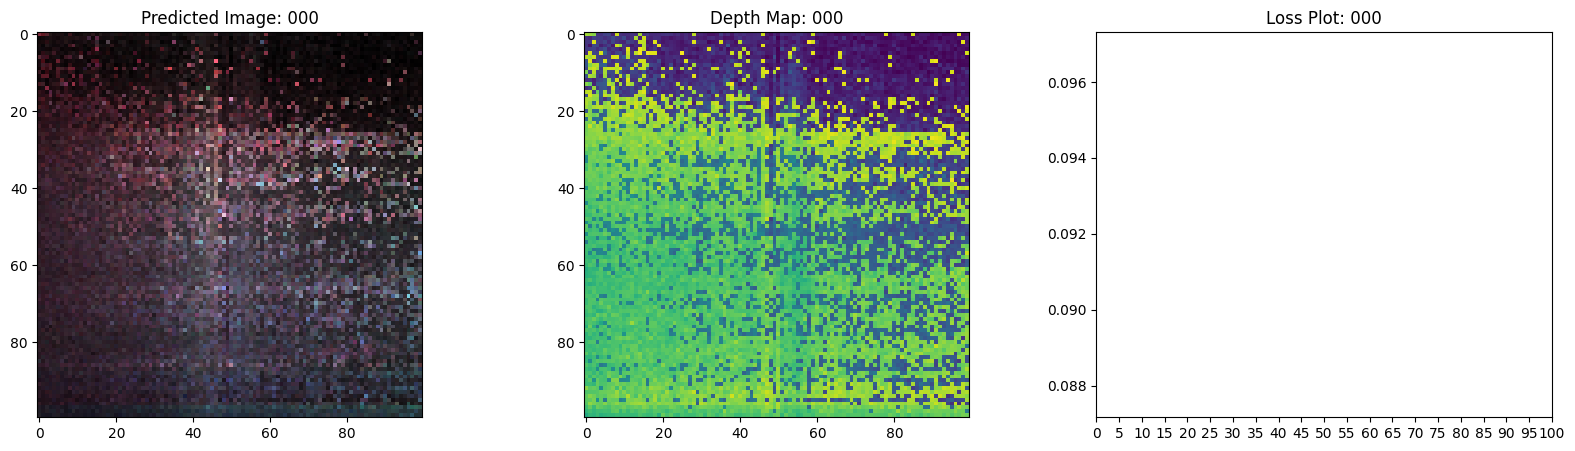

16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - loss: 0.1134 - psnr: 9.7357 - val_loss: 0.1037 - val_psnr: 9.8609
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/stepep - loss: 0.0792 - psnr: 11.18


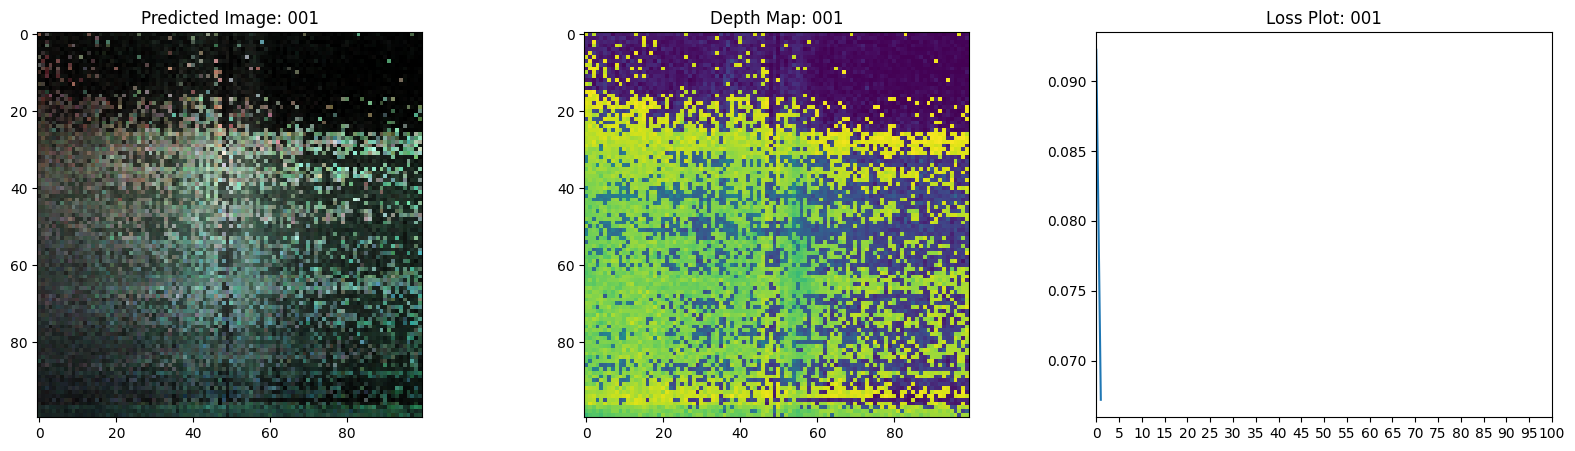

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0785 - psnr: 11.2335 - val_loss: 0.0922 - val_psnr: 10.3720
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/stepep - loss: 0.0687 - psnr: 11.78


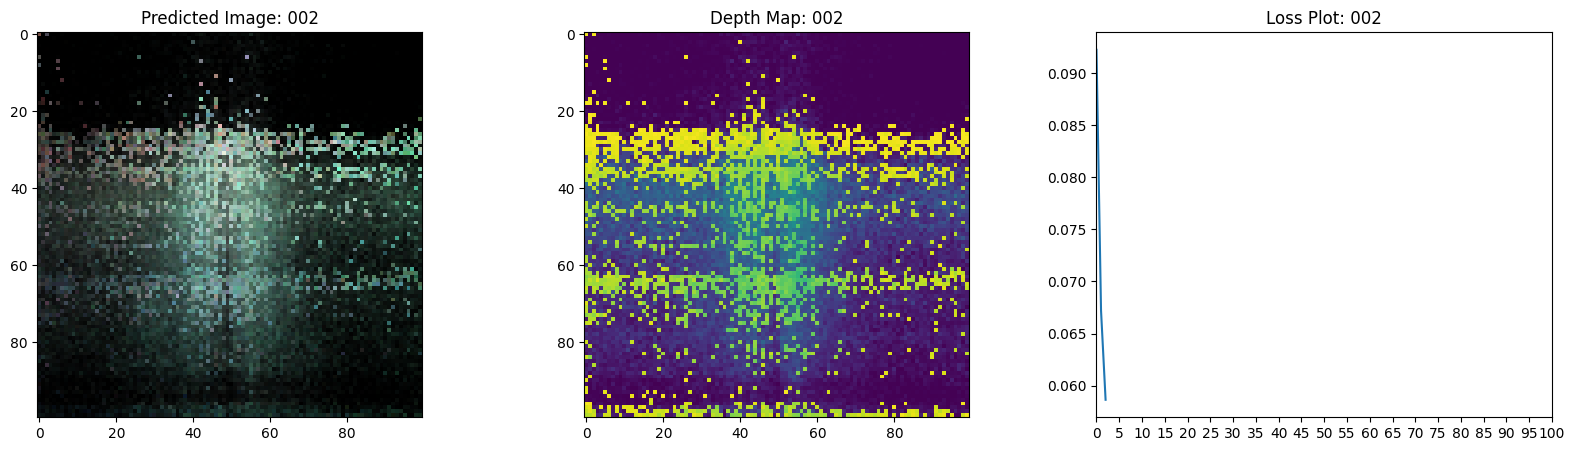

16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0681 - psnr: 11.8359 - val_loss: 0.0831 - val_psnr: 10.8250
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/stepep - loss: 0.0578 - psnr: 12.61


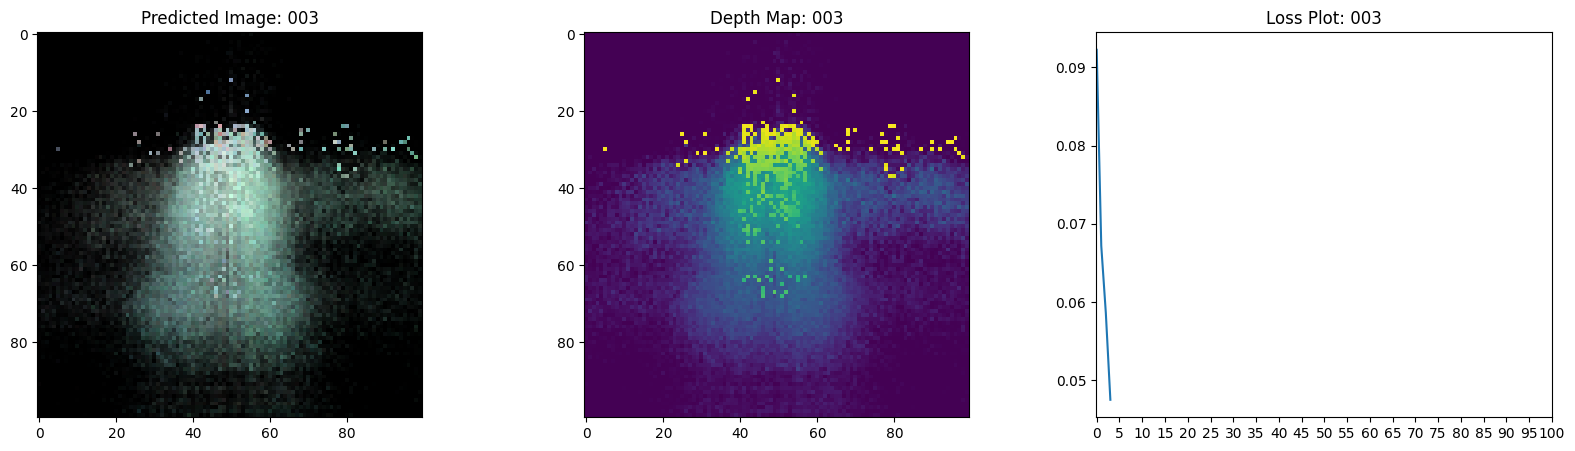

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0572 - psnr: 12.6828 - val_loss: 0.0647 - val_psnr: 11.9147
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/stepep - loss: 0.0435 - psnr: 13.89


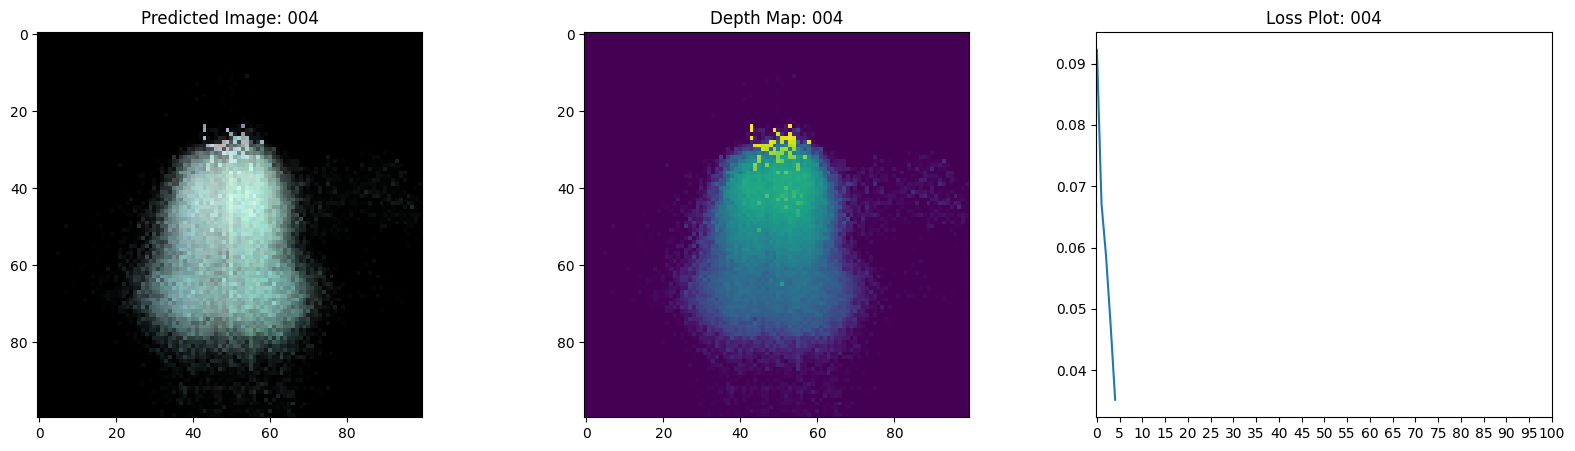

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0431 - psnr: 13.9702 - val_loss: 0.0472 - val_psnr: 13.2865
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/stepep - loss: 0.0312 - psnr: 15.26


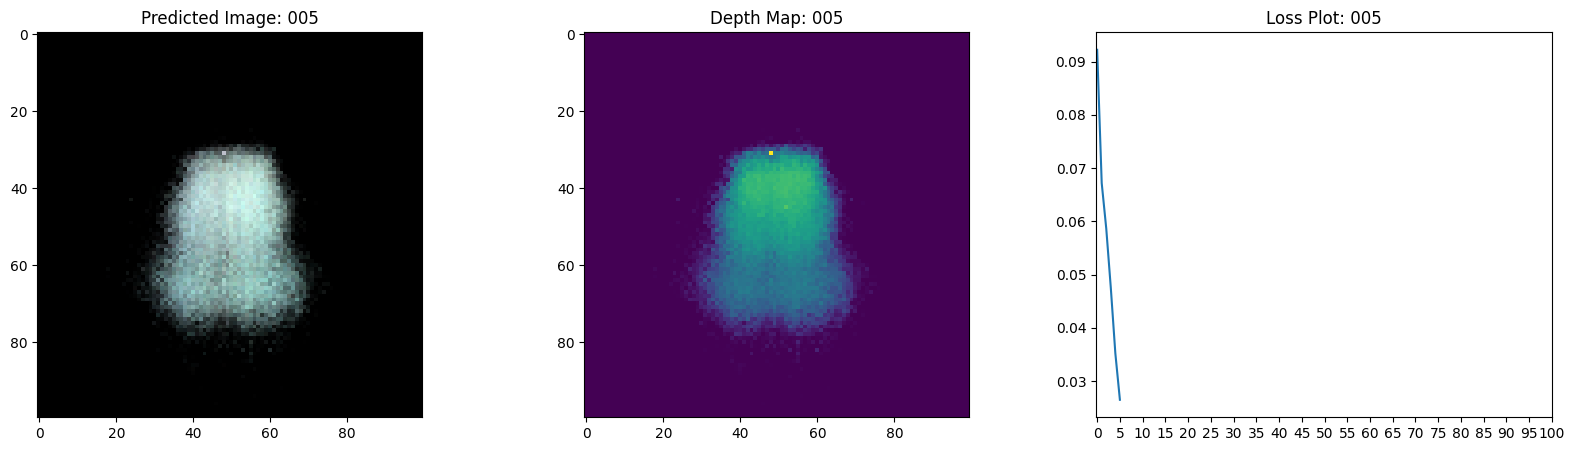

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0310 - psnr: 15.3255 - val_loss: 0.0430 - val_psnr: 13.6980
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/stepep - loss: 0.0254 - psnr: 16.09


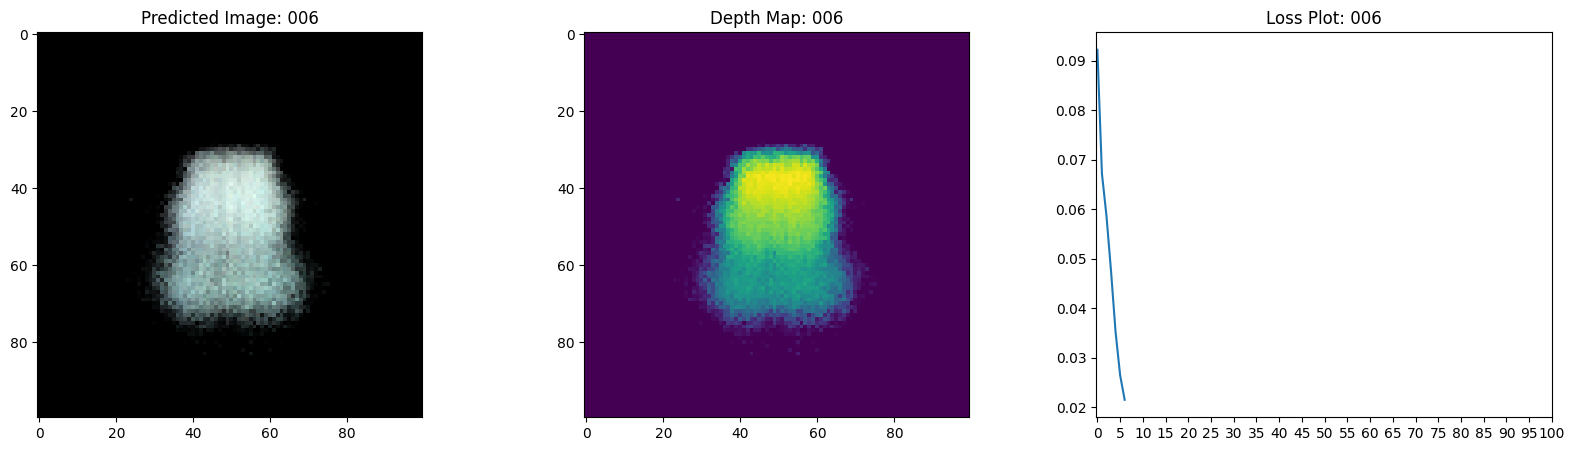

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0252 - psnr: 16.1428 - val_loss: 0.0350 - val_psnr: 14.5981
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/stepep - loss: 0.0211 - psnr: 16.88


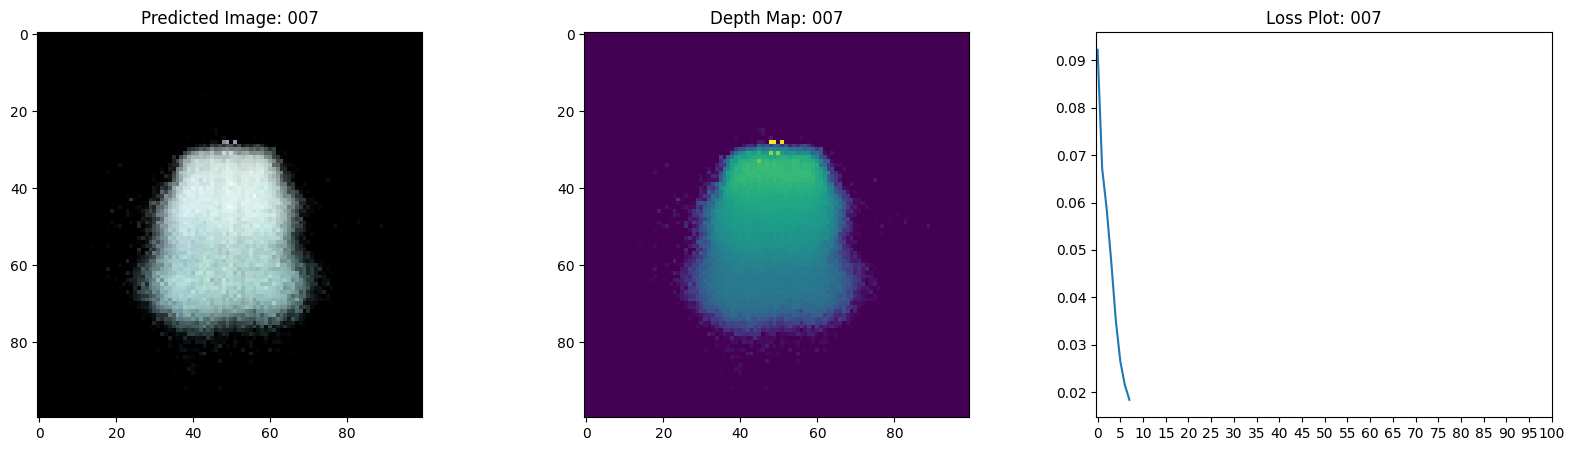

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0209 - psnr: 16.9208 - val_loss: 0.0172 - val_psnr: 17.6474
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/stepep - loss: 0.0143 - psnr: 18.53


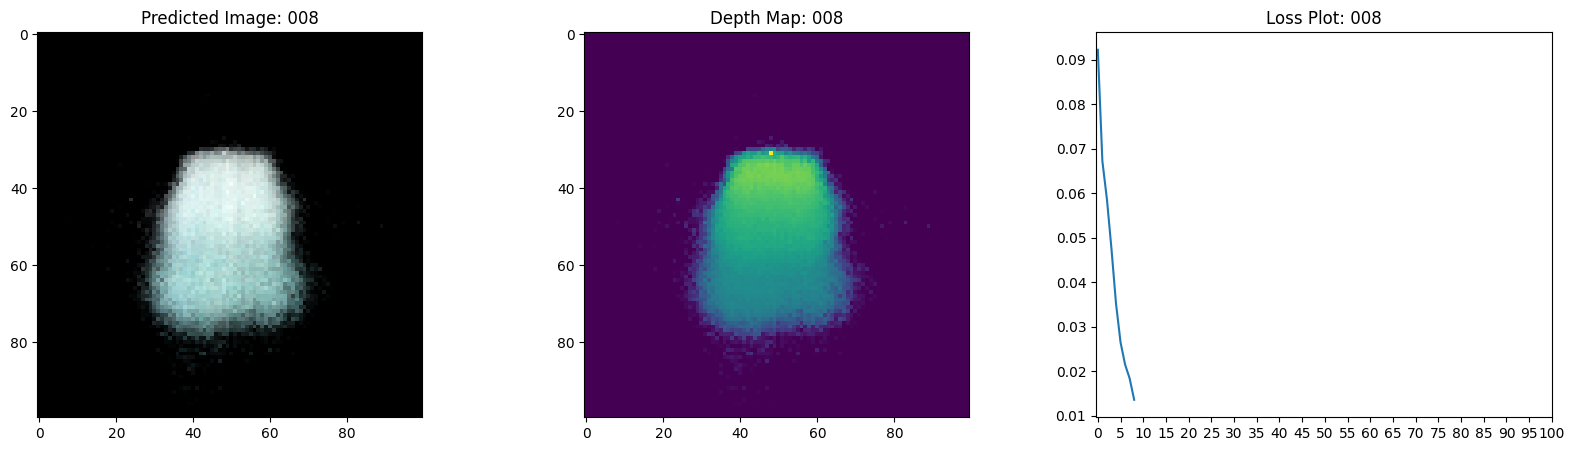

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0142 - psnr: 18.5471 - val_loss: 0.0182 - val_psnr: 17.4192
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/stepep - loss: 0.0135 - psnr: 18.78


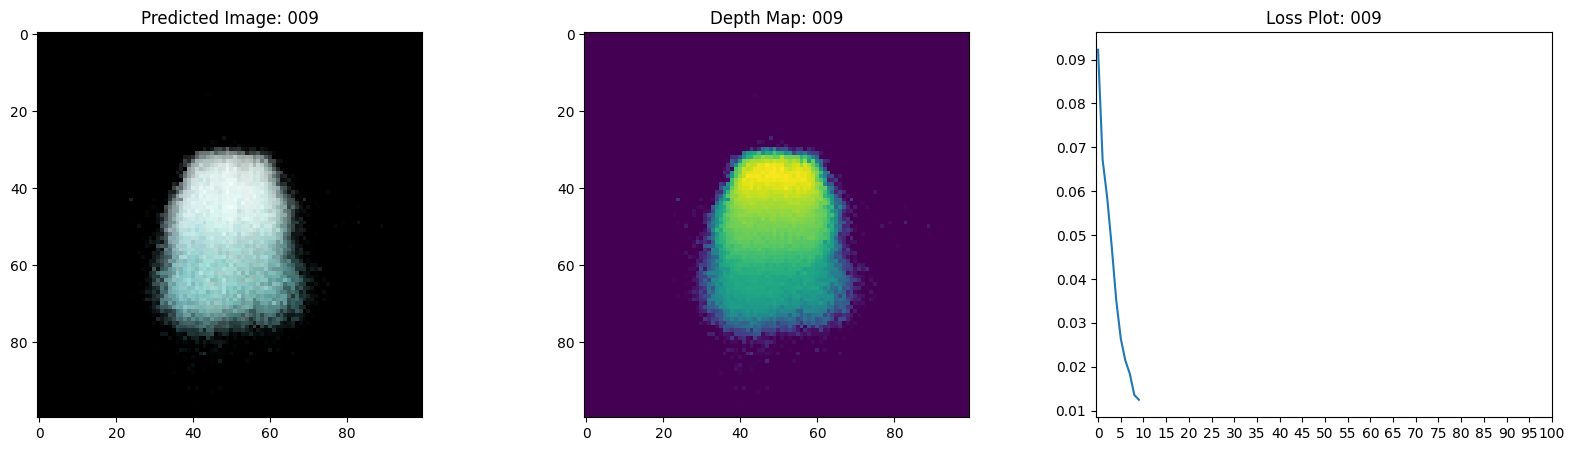

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0135 - psnr: 18.8074 - val_loss: 0.0204 - val_psnr: 16.9340
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/stepep - loss: 0.0140 - psnr: 18.63


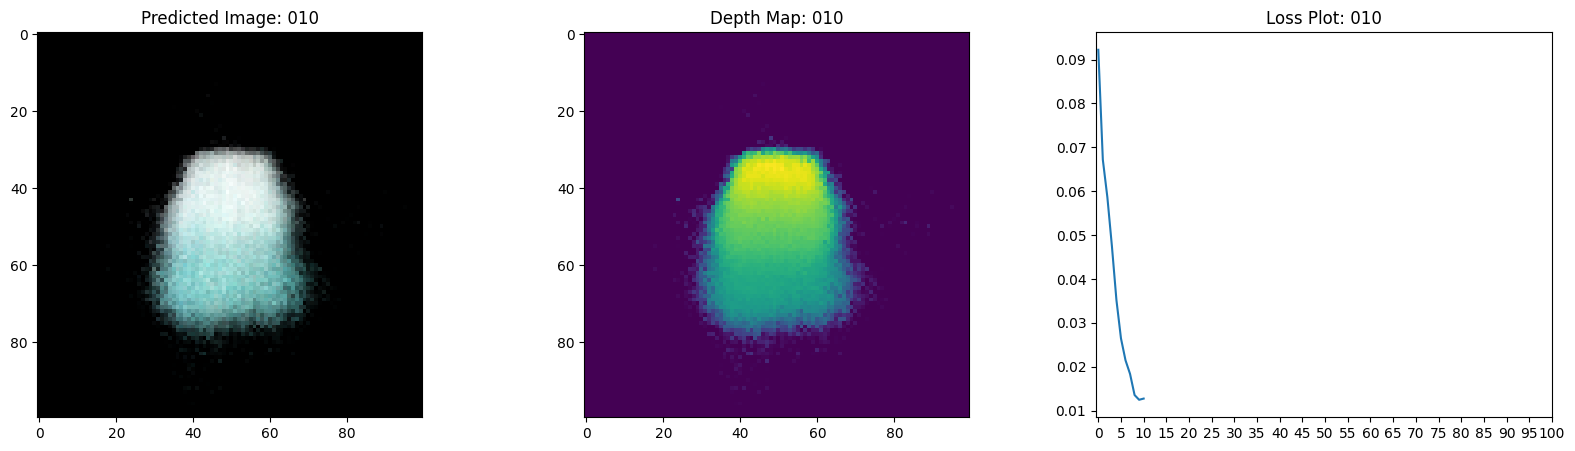

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0139 - psnr: 18.6611 - val_loss: 0.0172 - val_psnr: 17.6892
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/stepep - loss: 0.0129 - psnr: 18.97


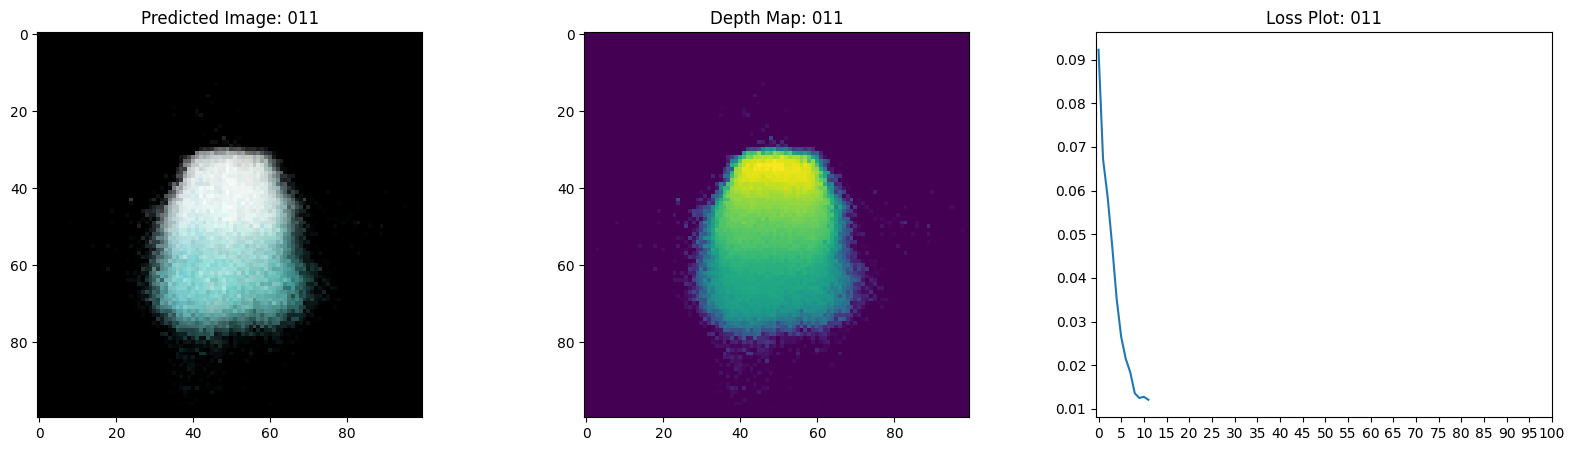

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0128 - psnr: 18.9899 - val_loss: 0.0159 - val_psnr: 18.0415
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/stepep - loss: 0.0121 - psnr: 19.27


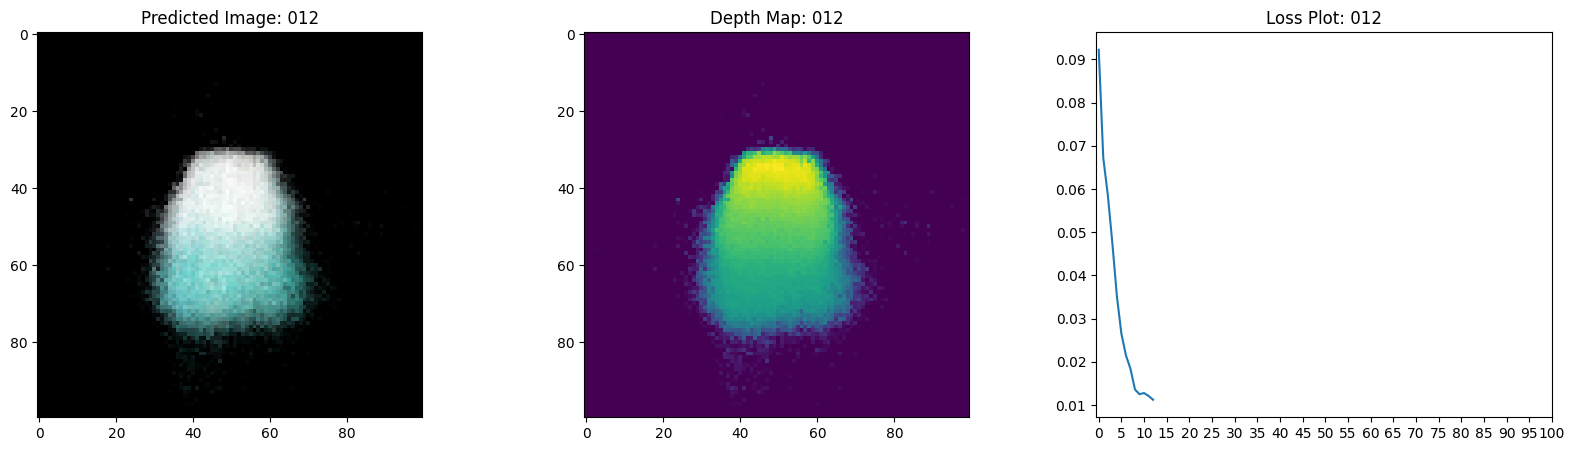

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0120 - psnr: 19.3002 - val_loss: 0.0166 - val_psnr: 17.8691
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/stepep - loss: 0.0119 - psnr: 19.36


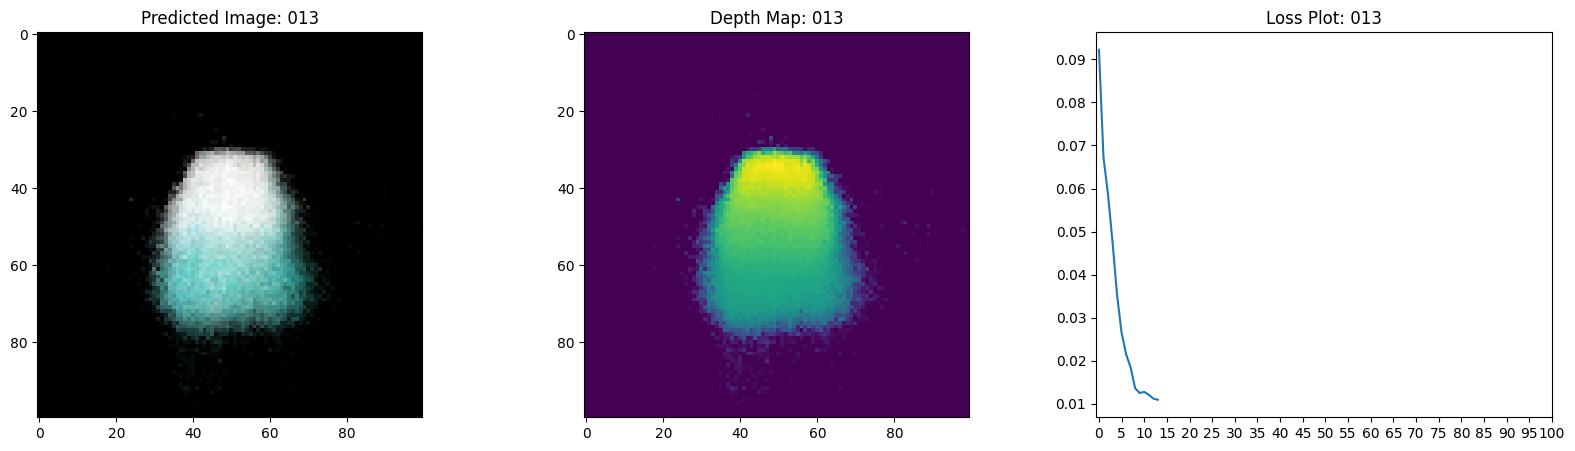

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0118 - psnr: 19.3848 - val_loss: 0.0168 - val_psnr: 17.8151
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/stepep - loss: 0.0120 - psnr: 19.33


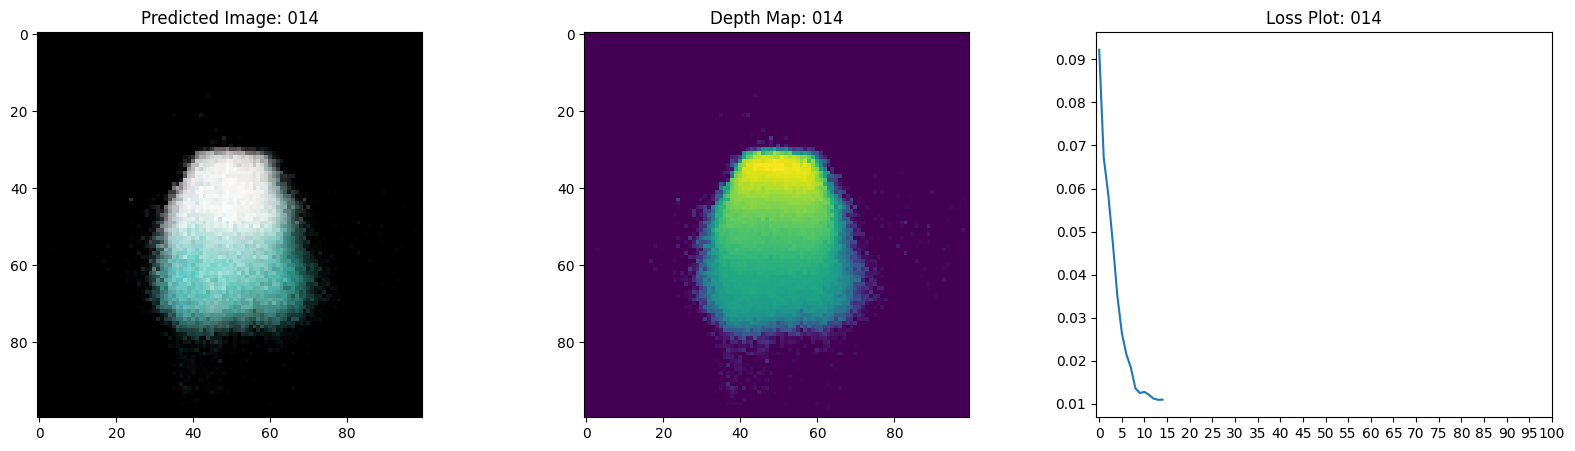

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0119 - psnr: 19.3554 - val_loss: 0.0157 - val_psnr: 18.1149
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/stepep - loss: 0.0115 - psnr: 19.50


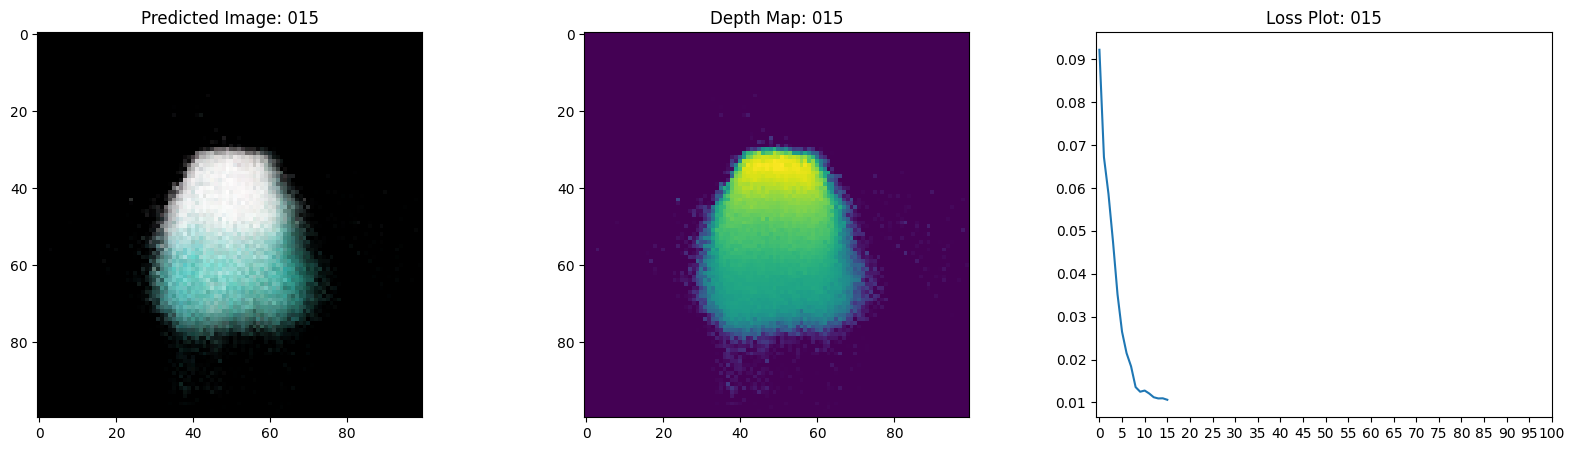

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0115 - psnr: 19.5237 - val_loss: 0.0155 - val_psnr: 18.1949
Epoch 17/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/stepep - loss: 0.0113 - psnr: 19.62


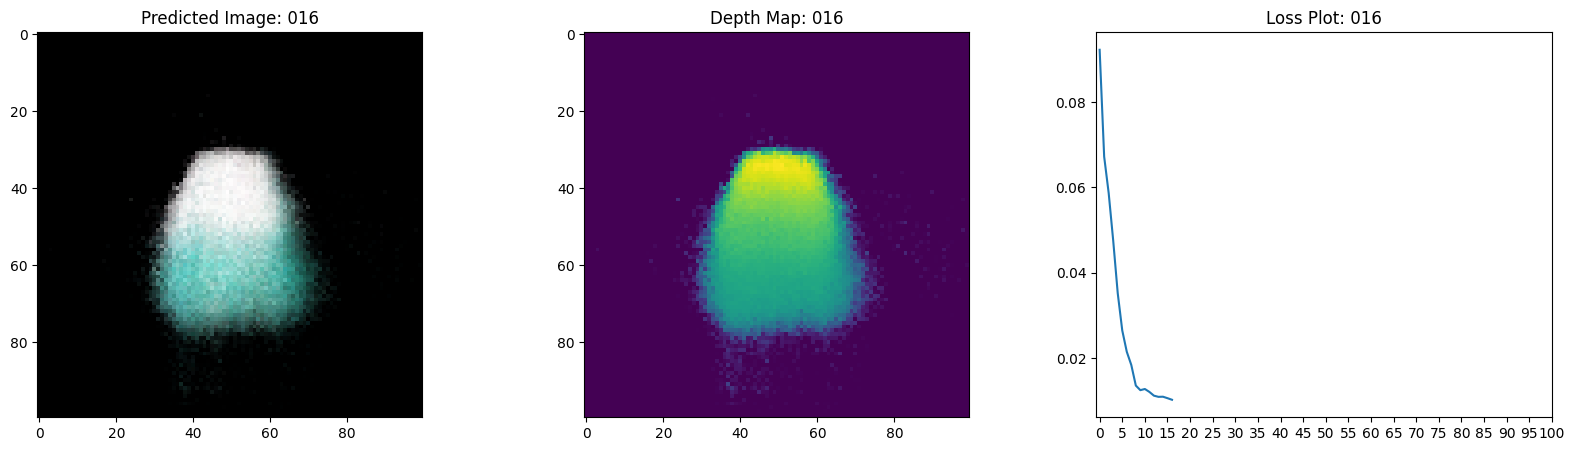

16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0112 - psnr: 19.6522 - val_loss: 0.0158 - val_psnr: 18.1131
Epoch 18/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/stepep - loss: 0.0113 - psnr: 19.63


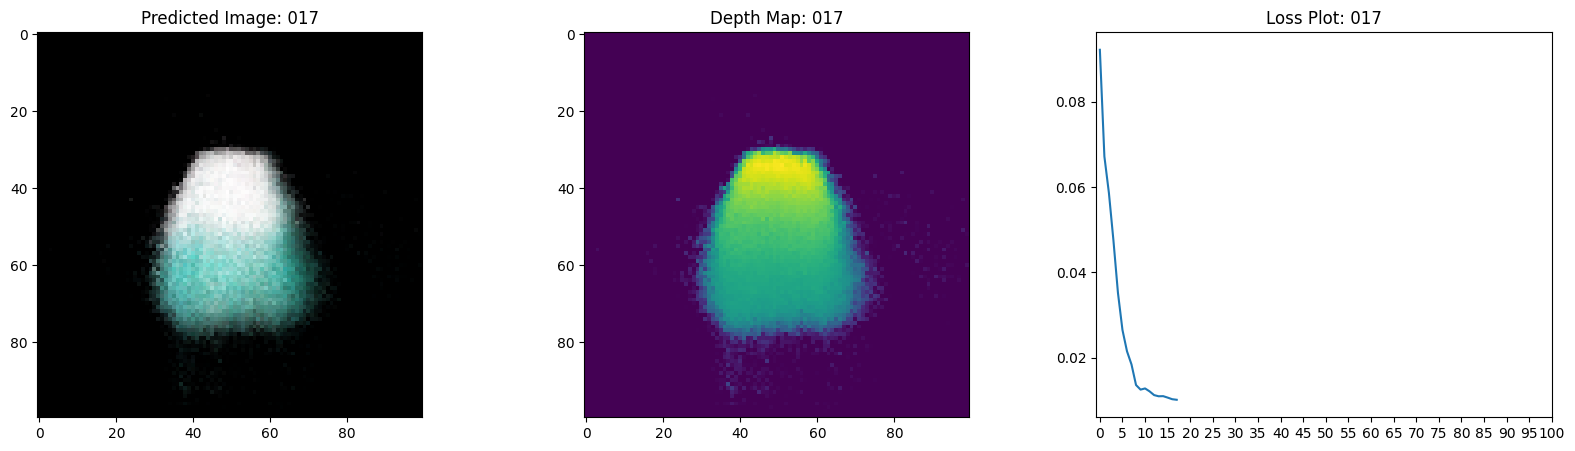

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0112 - psnr: 19.6614 - val_loss: 0.0158 - val_psnr: 18.1011
Epoch 19/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/stepep - loss: 0.0111 - psnr: 19.70


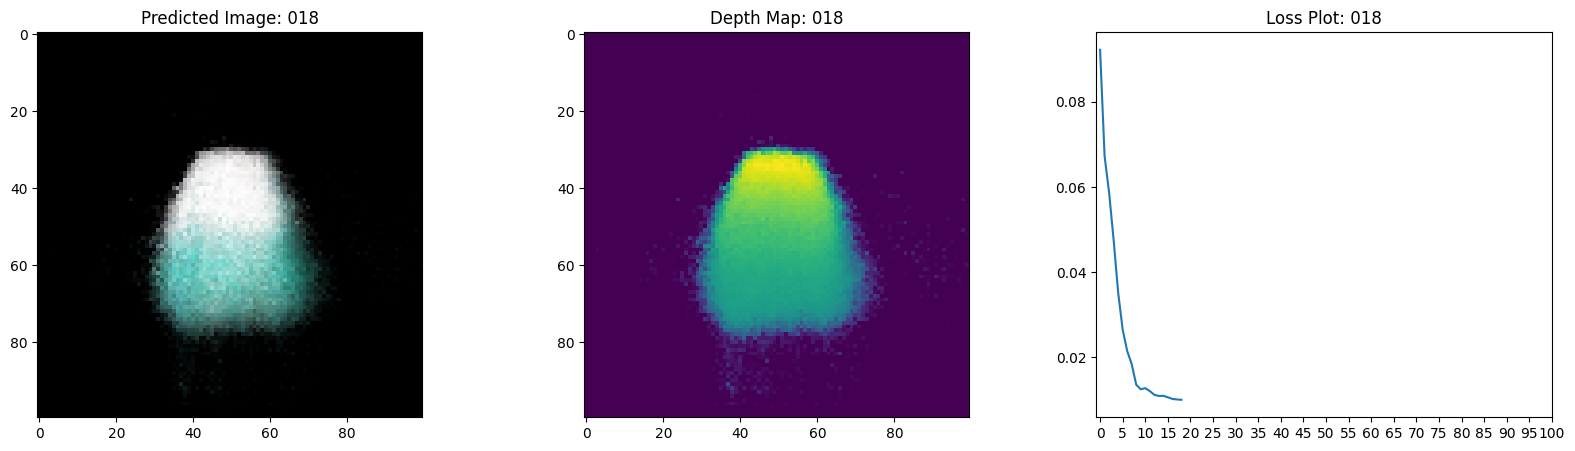

16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0110 - psnr: 19.7298 - val_loss: 0.0155 - val_psnr: 18.2028
Epoch 20/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/stepep - loss: 0.0111 - psnr: 19.70


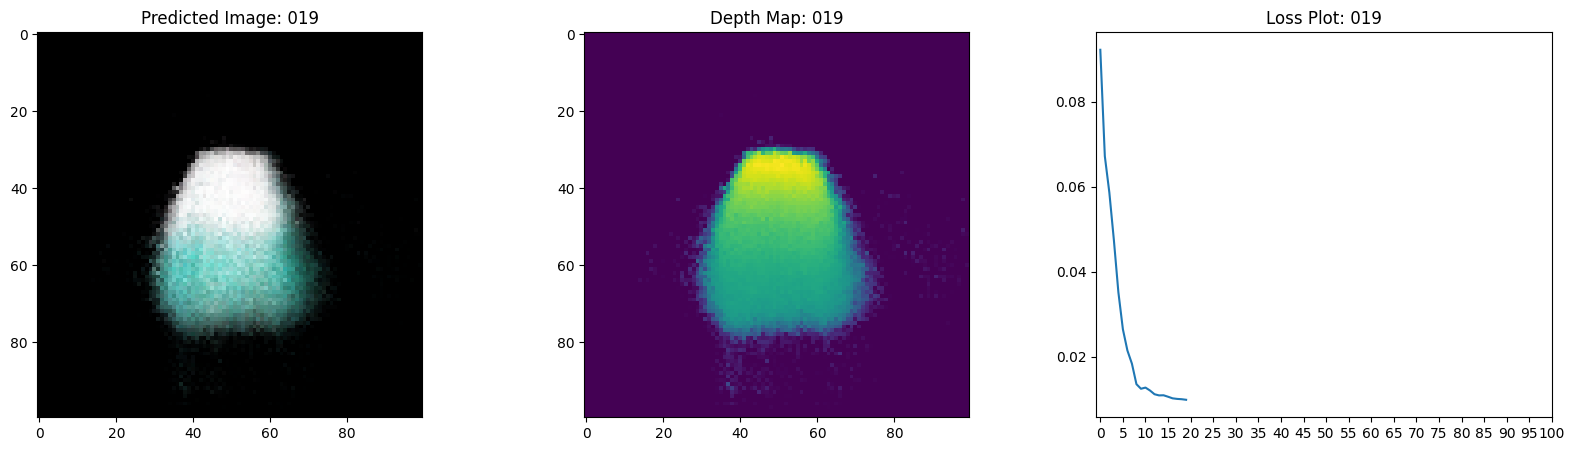

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0110 - psnr: 19.7387 - val_loss: 0.0154 - val_psnr: 18.2275
Epoch 21/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/stepep - loss: 0.0109 - psnr: 19.79


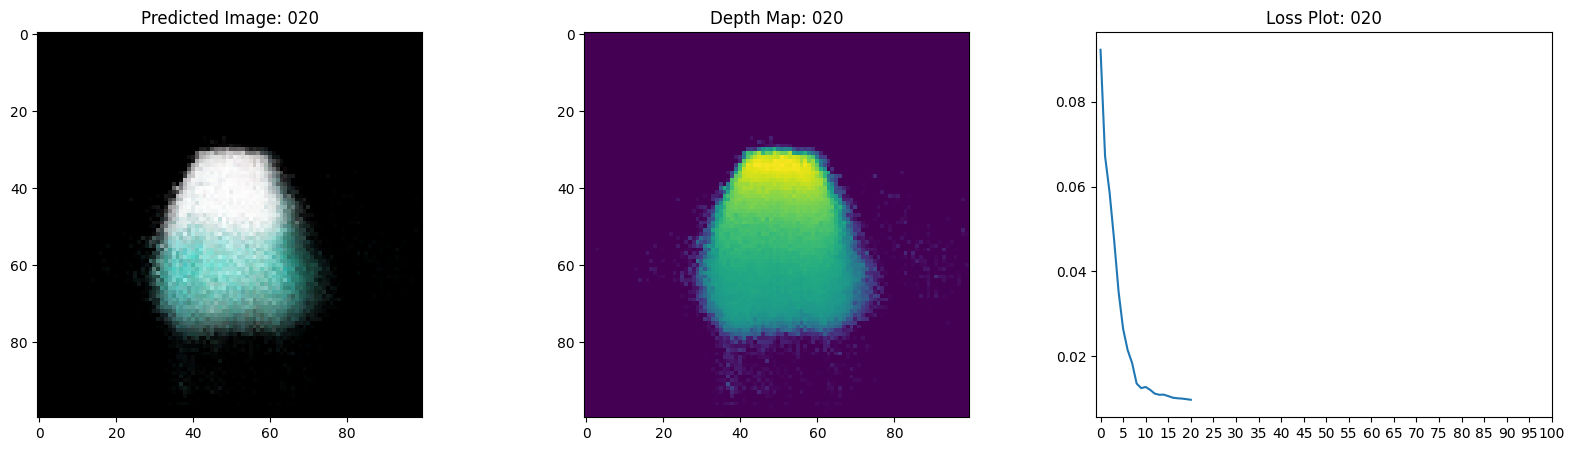

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0108 - psnr: 19.8226 - val_loss: 0.0151 - val_psnr: 18.3424
Epoch 22/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/stepep - loss: 0.0106 - psnr: 19.89


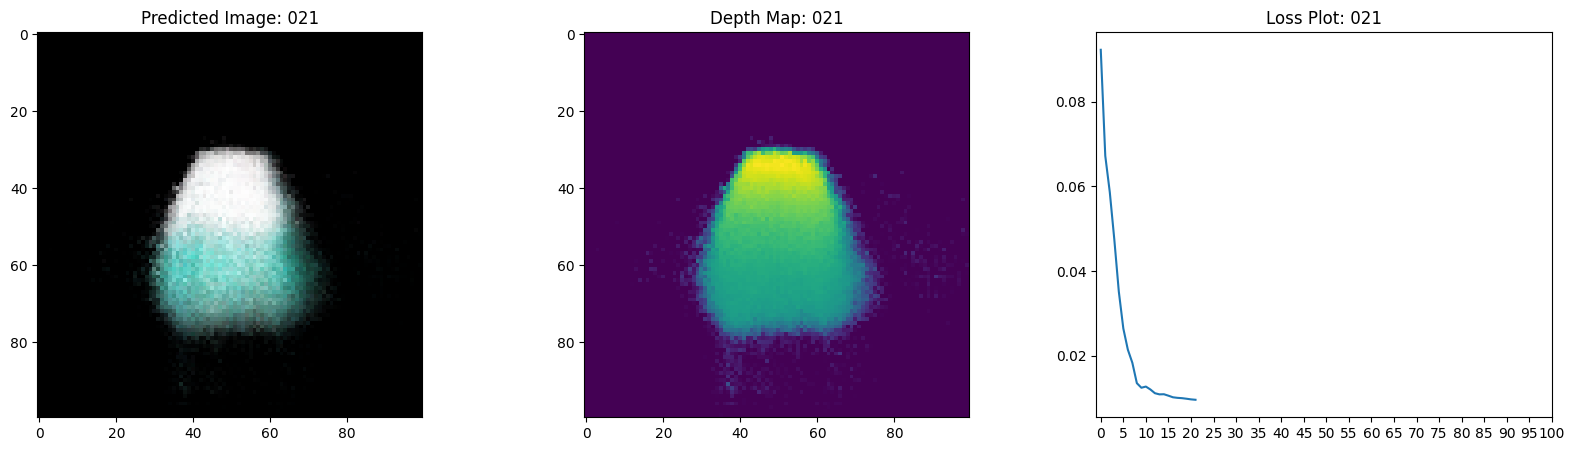

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0106 - psnr: 19.9218 - val_loss: 0.0150 - val_psnr: 18.3820
Epoch 23/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/stepep - loss: 0.0107 - psnr: 19.90


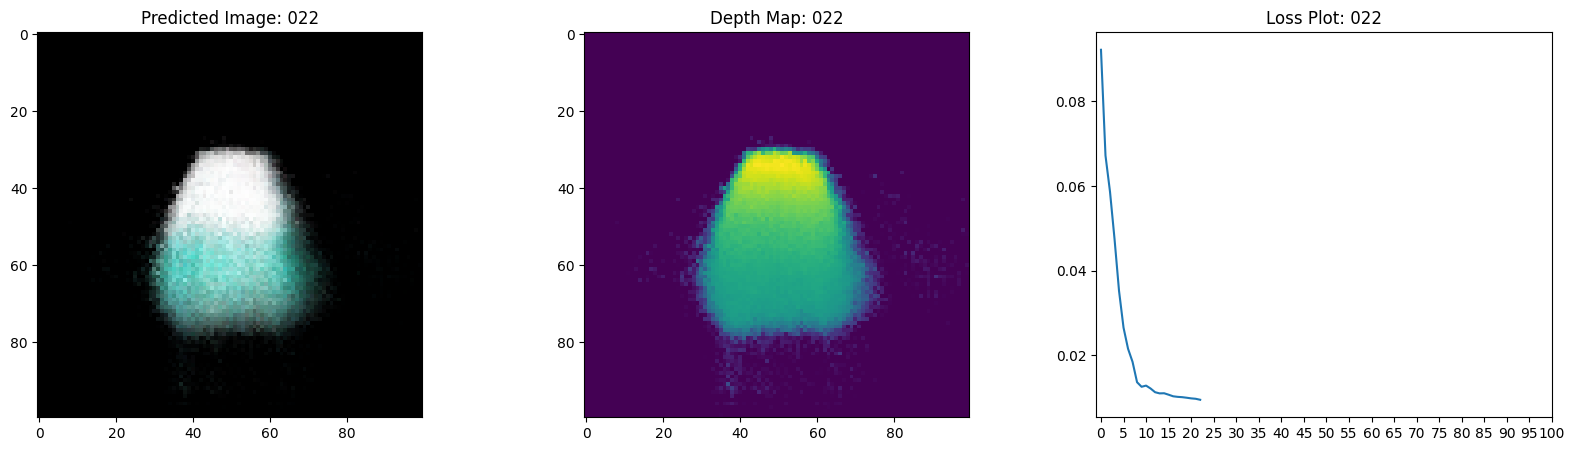

16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0106 - psnr: 19.9418 - val_loss: 0.0151 - val_psnr: 18.3422
Epoch 24/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/stepep - loss: 0.0104 - psnr: 20.02


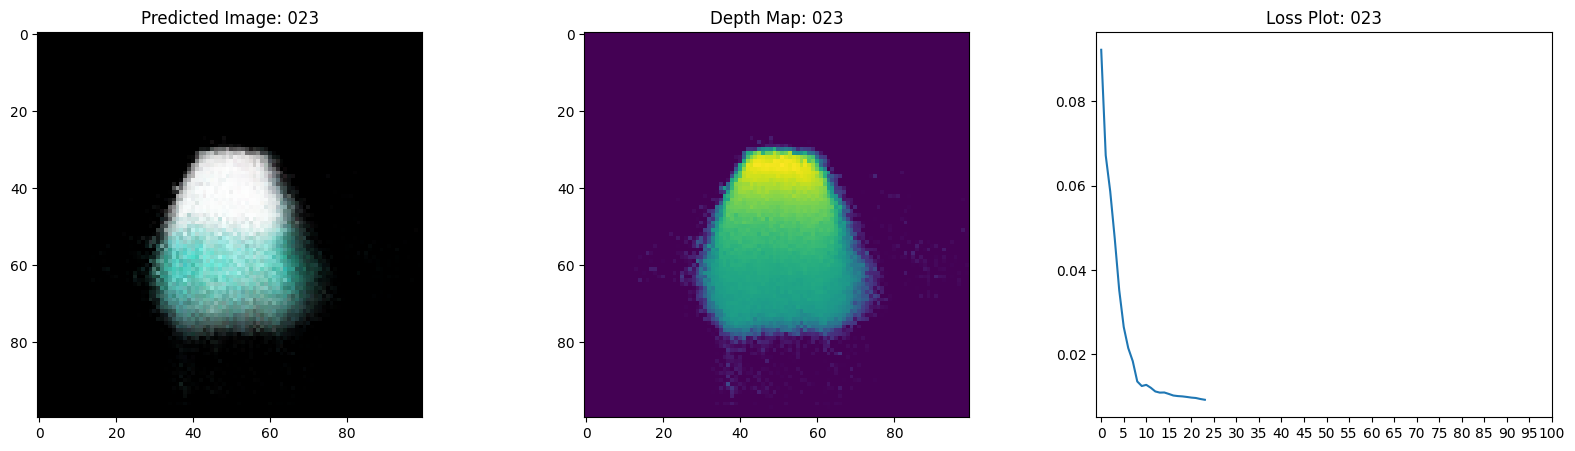

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0103 - psnr: 20.0519 - val_loss: 0.0154 - val_psnr: 18.2350
Epoch 25/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/stepep - loss: 0.0105 - psnr: 19.99


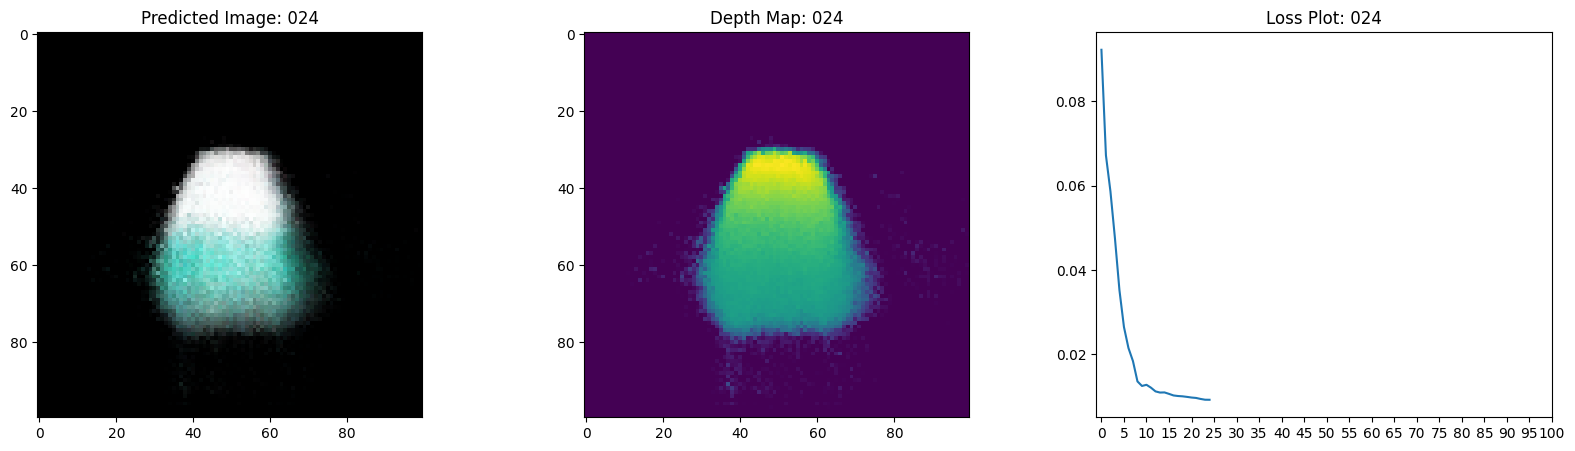

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0104 - psnr: 20.0278 - val_loss: 0.0154 - val_psnr: 18.2403
Epoch 26/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/stepep - loss: 0.0105 - psnr: 19.97


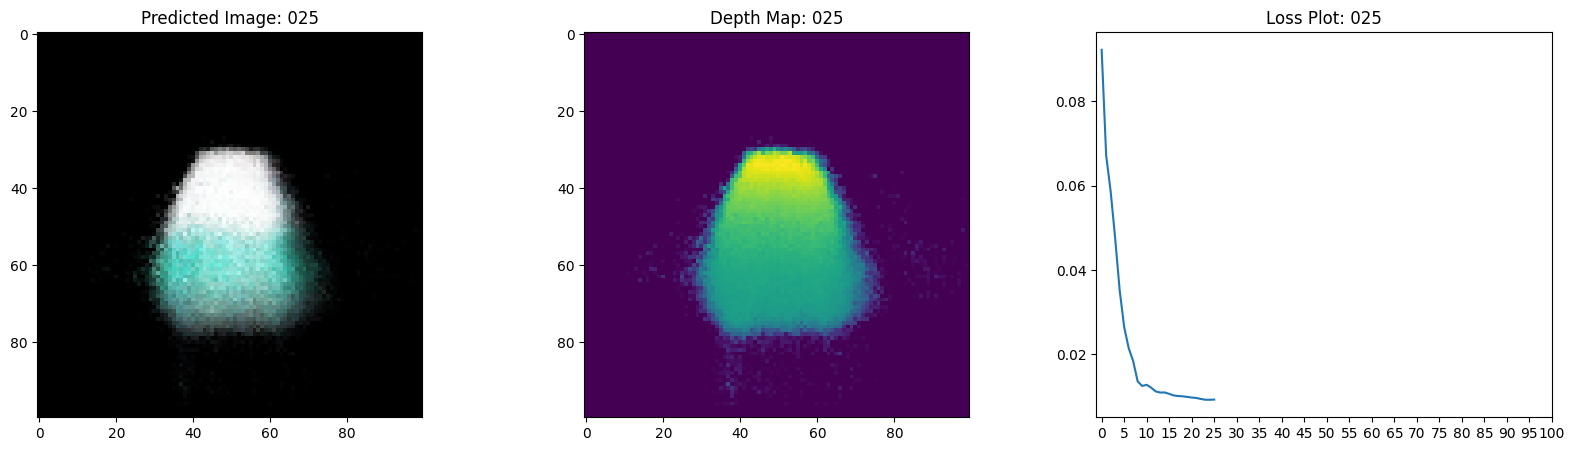

16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0104 - psnr: 20.0109 - val_loss: 0.0149 - val_psnr: 18.4095
Epoch 27/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/stepep - loss: 0.0102 - psnr: 20.08


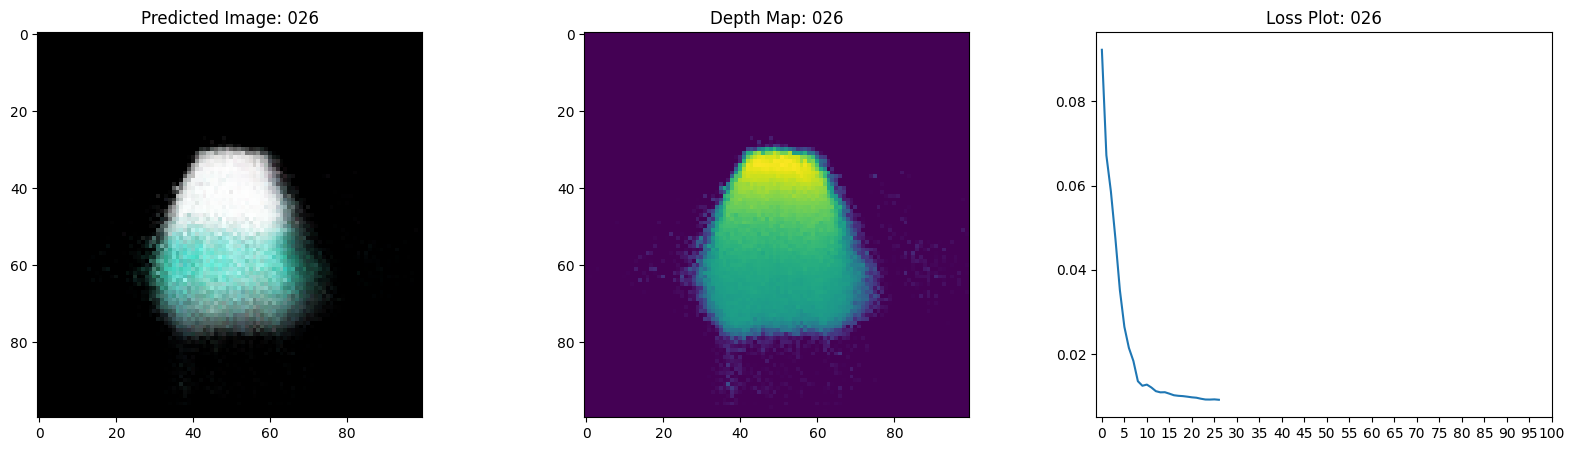

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0102 - psnr: 20.1162 - val_loss: 0.0147 - val_psnr: 18.4771
Epoch 28/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/stepep - loss: 0.0101 - psnr: 20.15


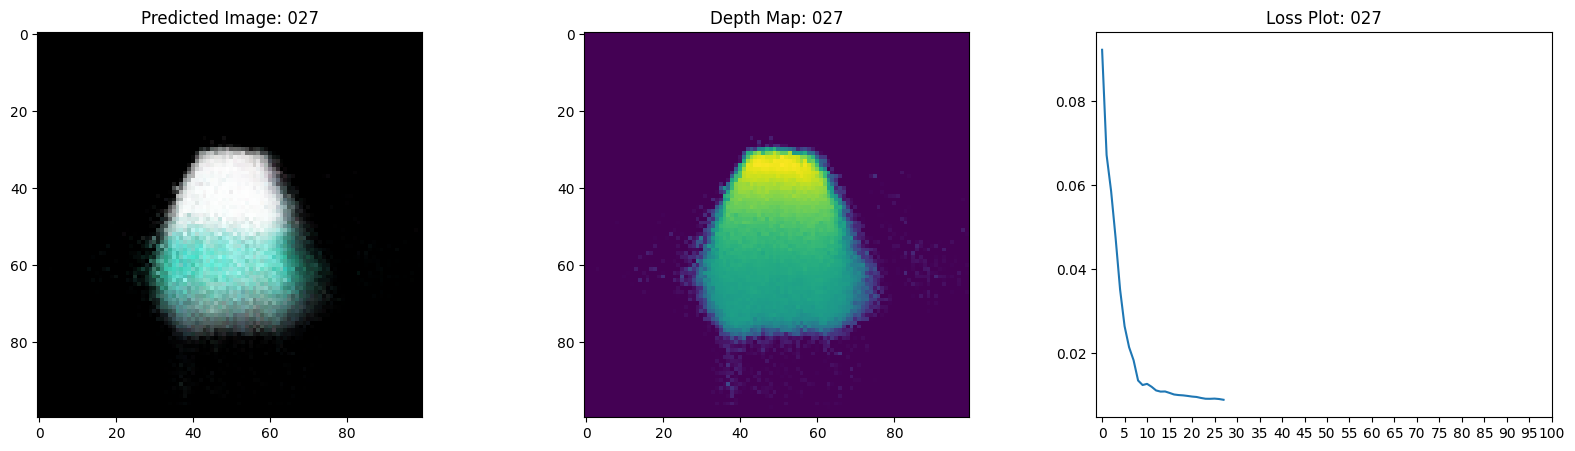

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0100 - psnr: 20.1885 - val_loss: 0.0148 - val_psnr: 18.4359
Epoch 29/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/stepep - loss: 0.0102 - psnr: 20.13


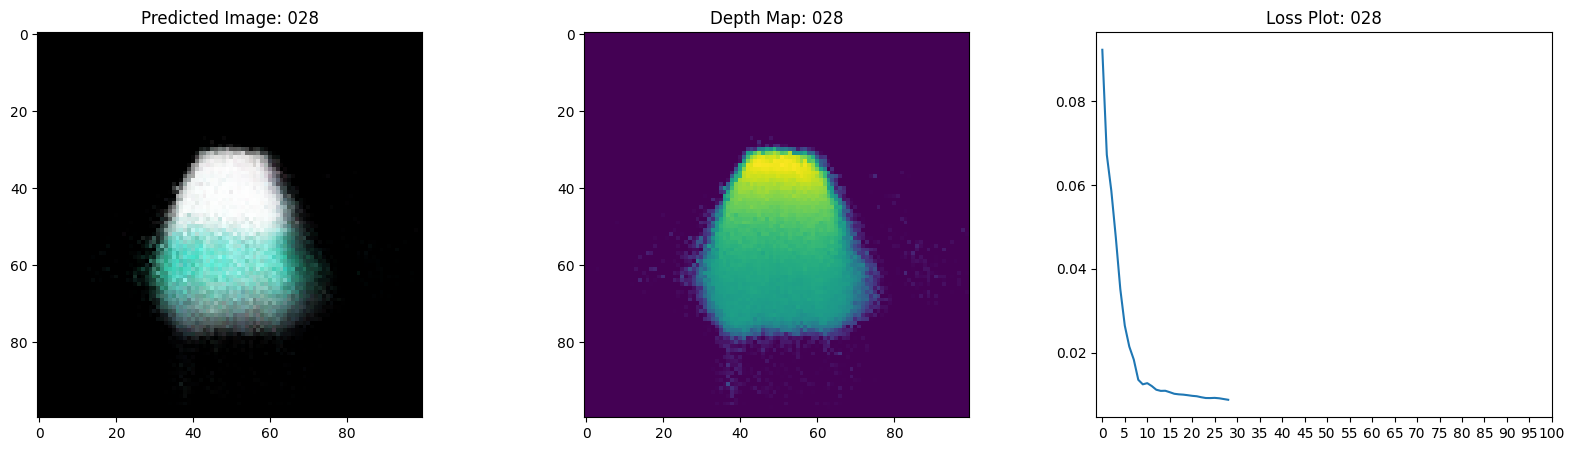

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0101 - psnr: 20.1773 - val_loss: 0.0151 - val_psnr: 18.3588
Epoch 30/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/stepep - loss: 0.0101 - psnr: 20.19


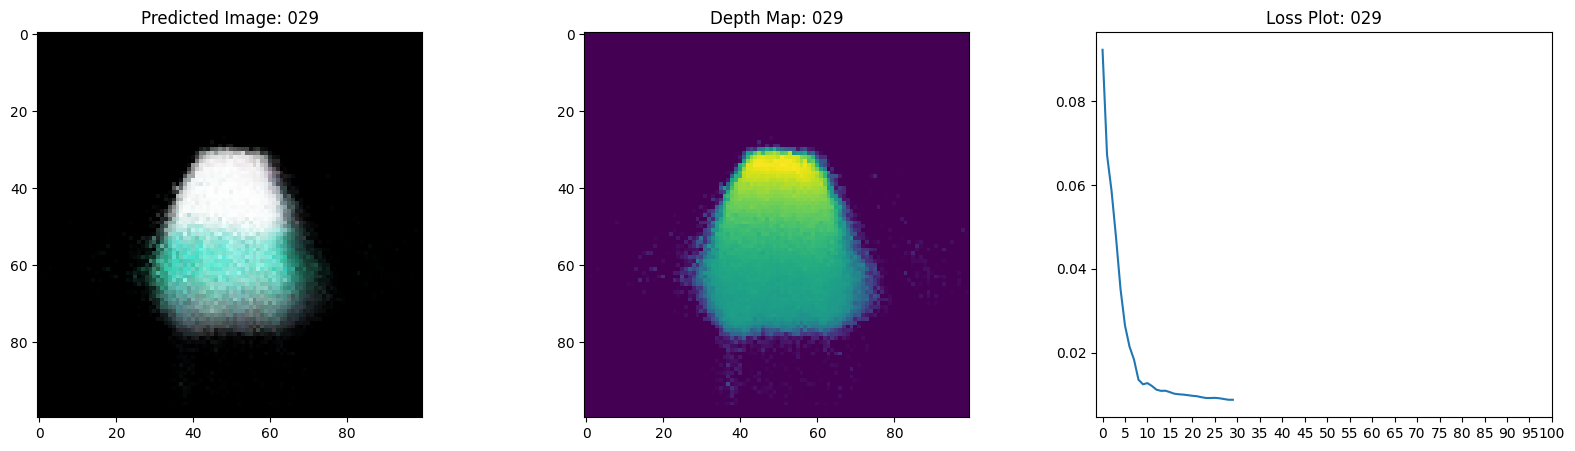

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0100 - psnr: 20.2353 - val_loss: 0.0151 - val_psnr: 18.3710
Epoch 31/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/stepep - loss: 0.0101 - psnr: 20.20


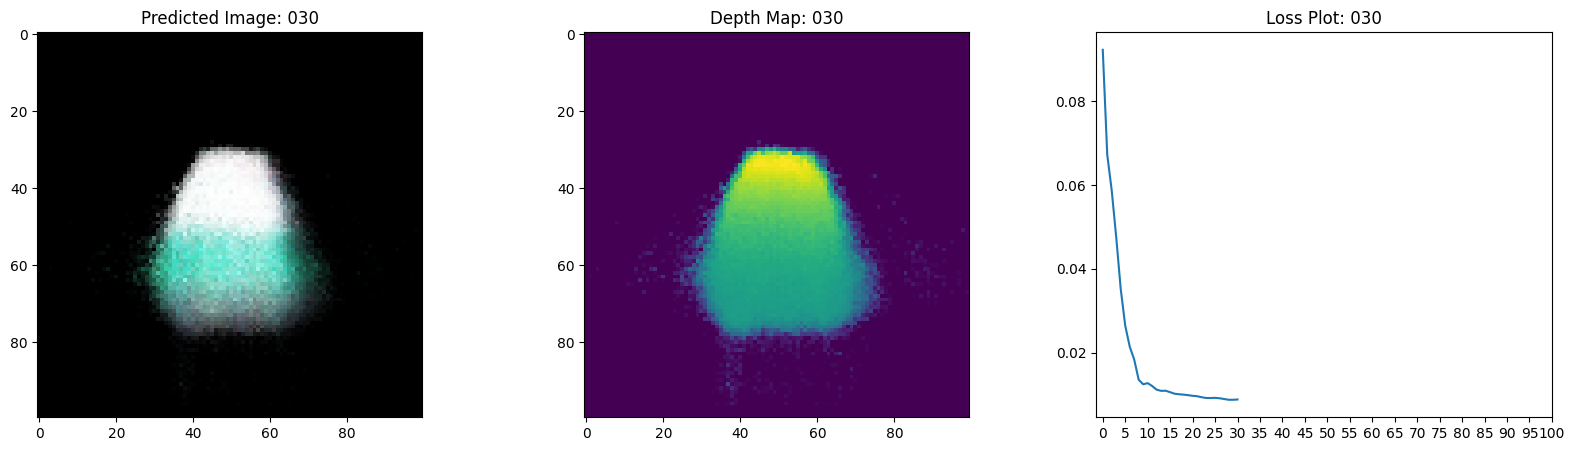

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0100 - psnr: 20.2363 - val_loss: 0.0145 - val_psnr: 18.5418
Epoch 32/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/stepep - loss: 0.0101 - psnr: 20.18


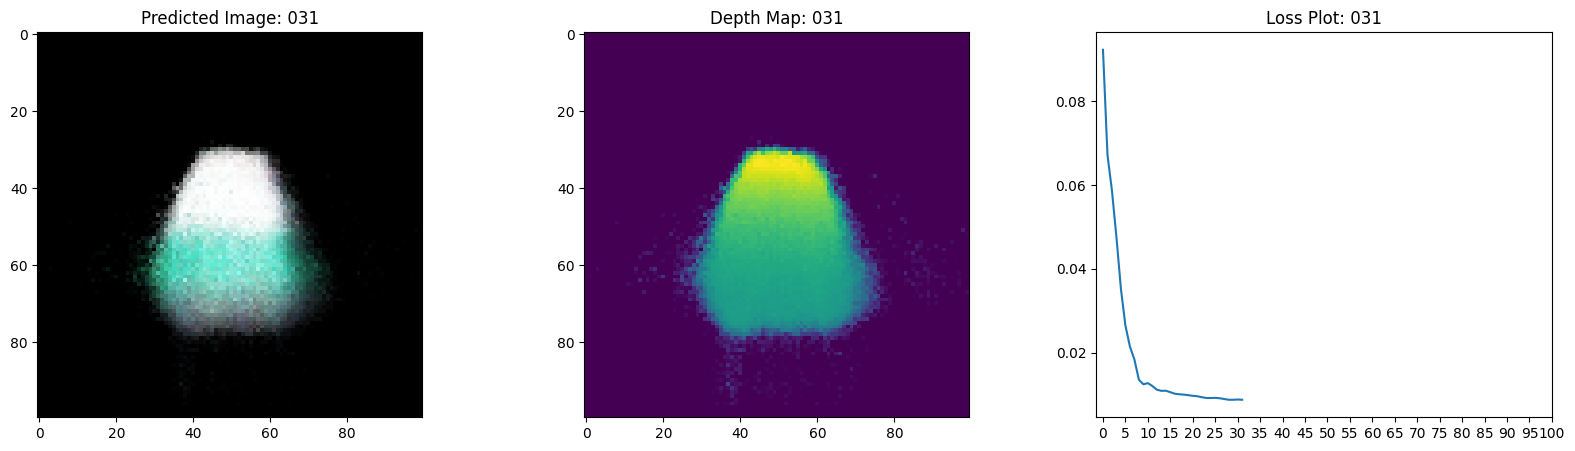

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0100 - psnr: 20.2196 - val_loss: 0.0144 - val_psnr: 18.5990
Epoch 33/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/stepep - loss: 0.0099 - psnr: 20.25


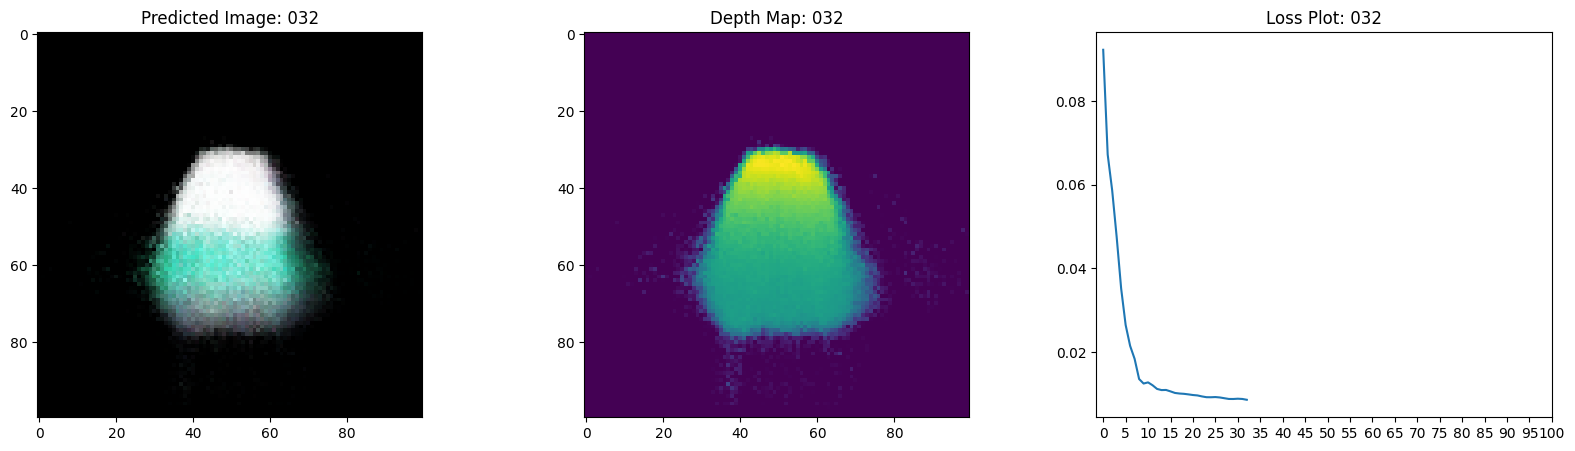

16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0099 - psnr: 20.2980 - val_loss: 0.0146 - val_psnr: 18.5490
Epoch 34/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/stepep - loss: 0.0099 - psnr: 20.31


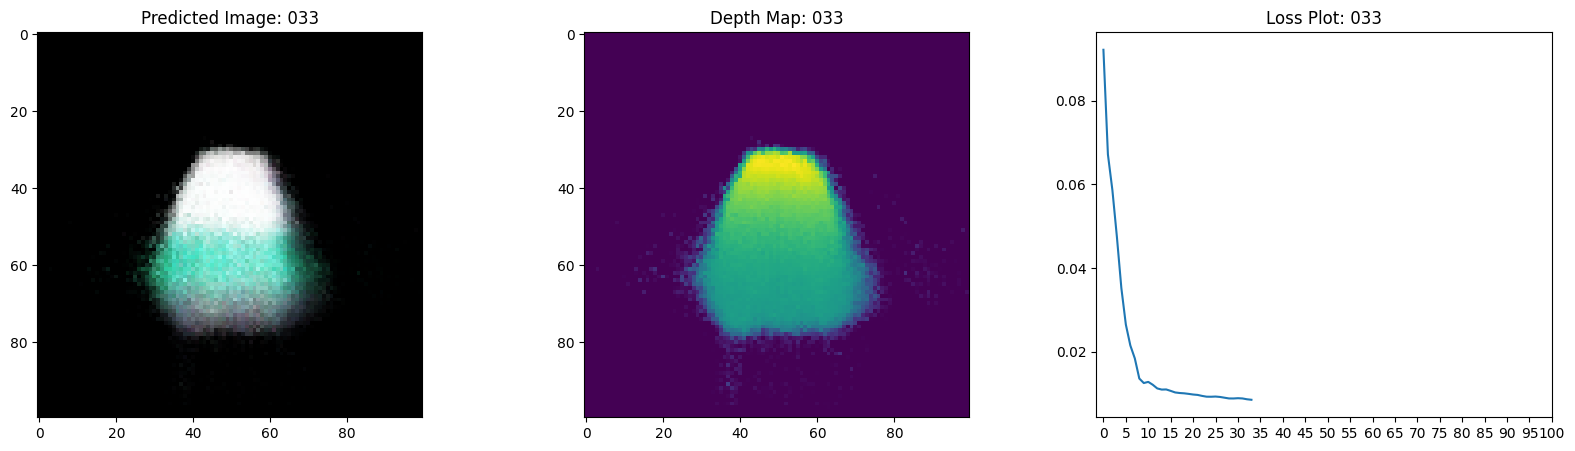

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0098 - psnr: 20.3511 - val_loss: 0.0148 - val_psnr: 18.4704
Epoch 35/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/stepep - loss: 0.0098 - psnr: 20.35


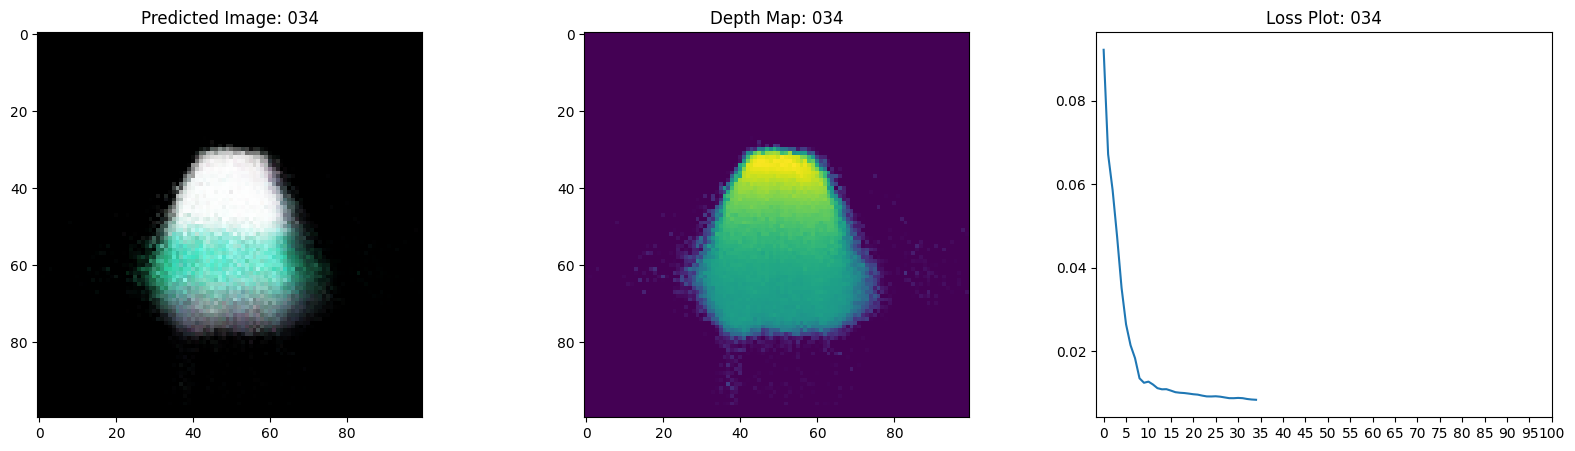

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0097 - psnr: 20.3909 - val_loss: 0.0149 - val_psnr: 18.4275
Epoch 36/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/stepep - loss: 0.0098 - psnr: 20.37


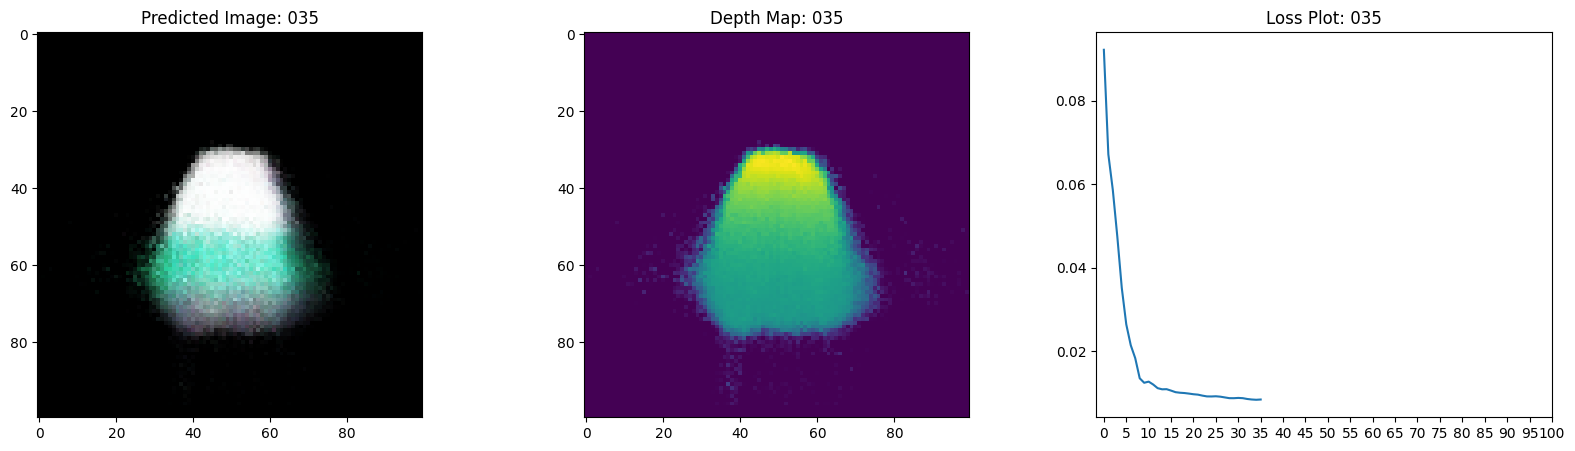

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0097 - psnr: 20.4083 - val_loss: 0.0145 - val_psnr: 18.5699
Epoch 37/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/stepep - loss: 0.0098 - psnr: 20.36


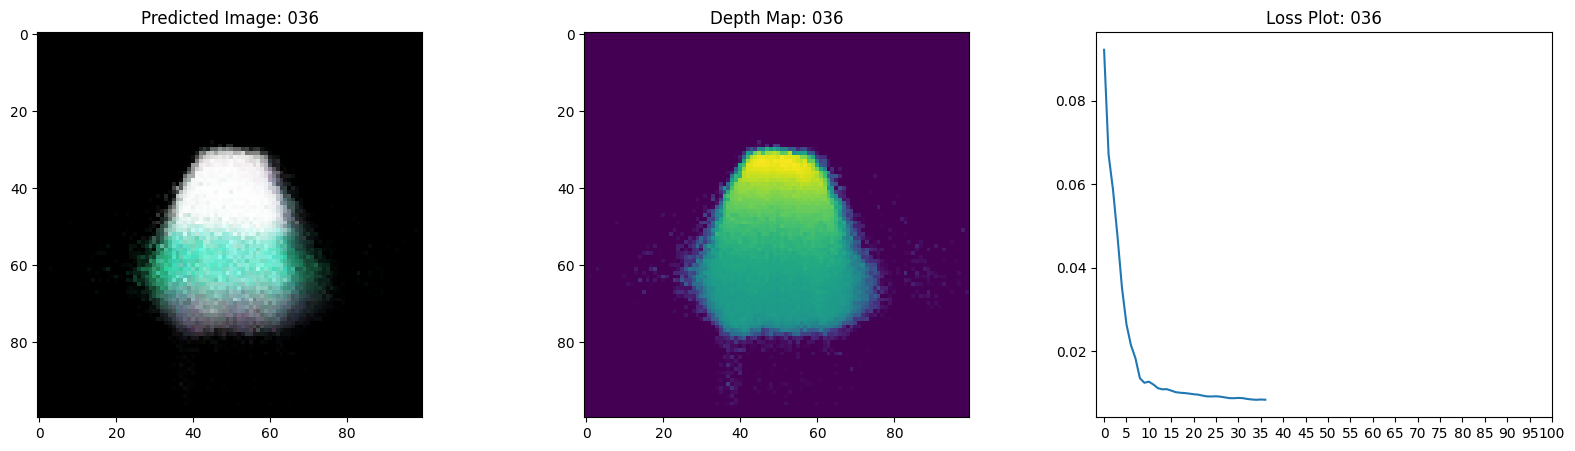

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0097 - psnr: 20.4083 - val_loss: 0.0145 - val_psnr: 18.5868
Epoch 38/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/stepep - loss: 0.0096 - psnr: 20.45


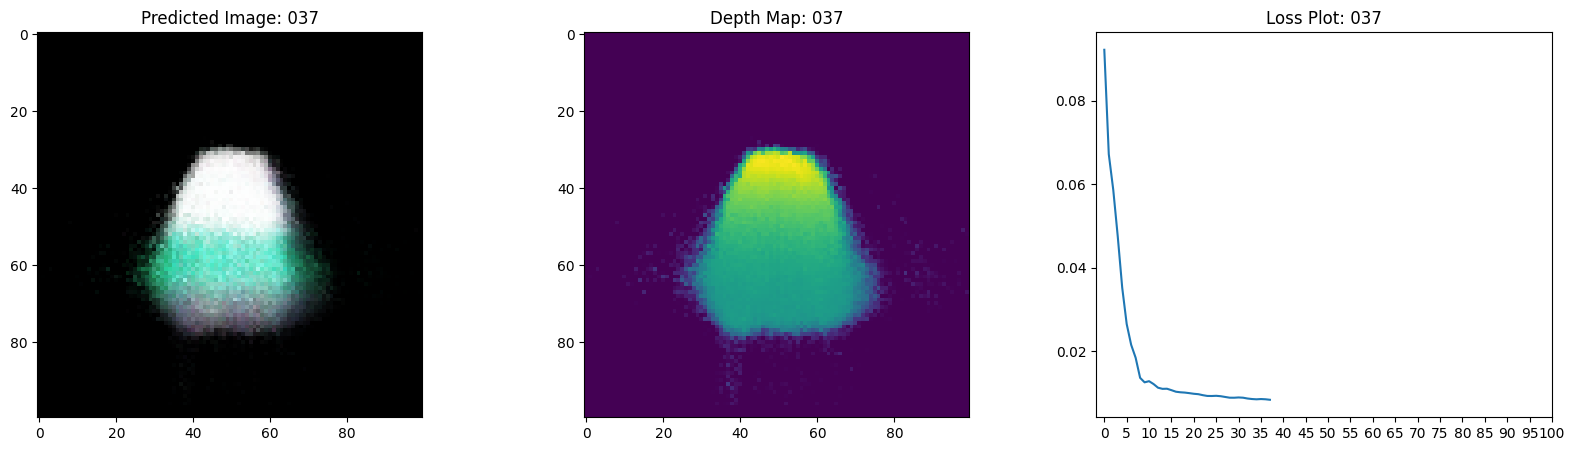

16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0095 - psnr: 20.4897 - val_loss: 0.0144 - val_psnr: 18.6132
Epoch 39/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/stepep - loss: 0.0093 - psnr: 20.55


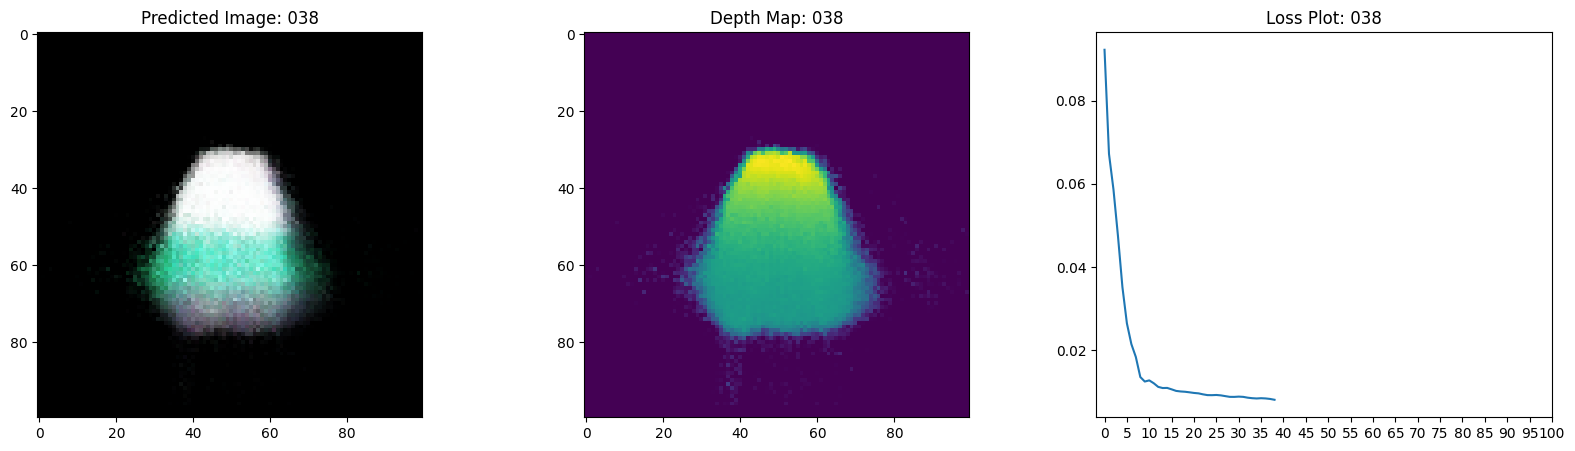

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0092 - psnr: 20.5976 - val_loss: 0.0147 - val_psnr: 18.5225
Epoch 40/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/stepep - loss: 0.0094 - psnr: 20.55


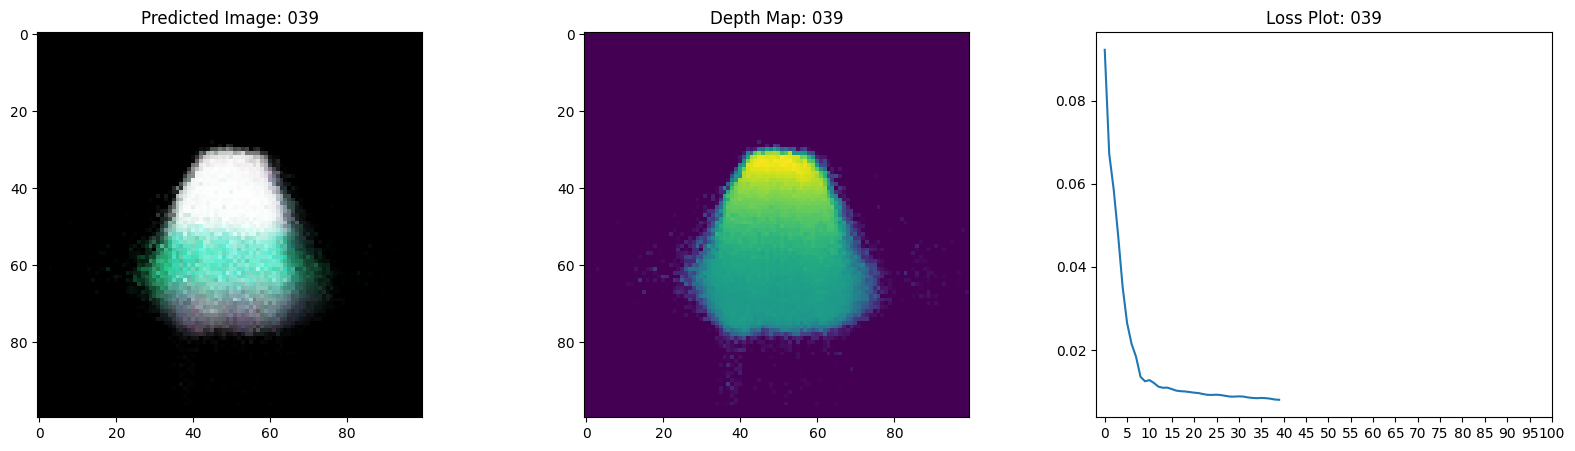

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0093 - psnr: 20.6010 - val_loss: 0.0150 - val_psnr: 18.4432
Epoch 41/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/stepep - loss: 0.0097 - psnr: 20.45


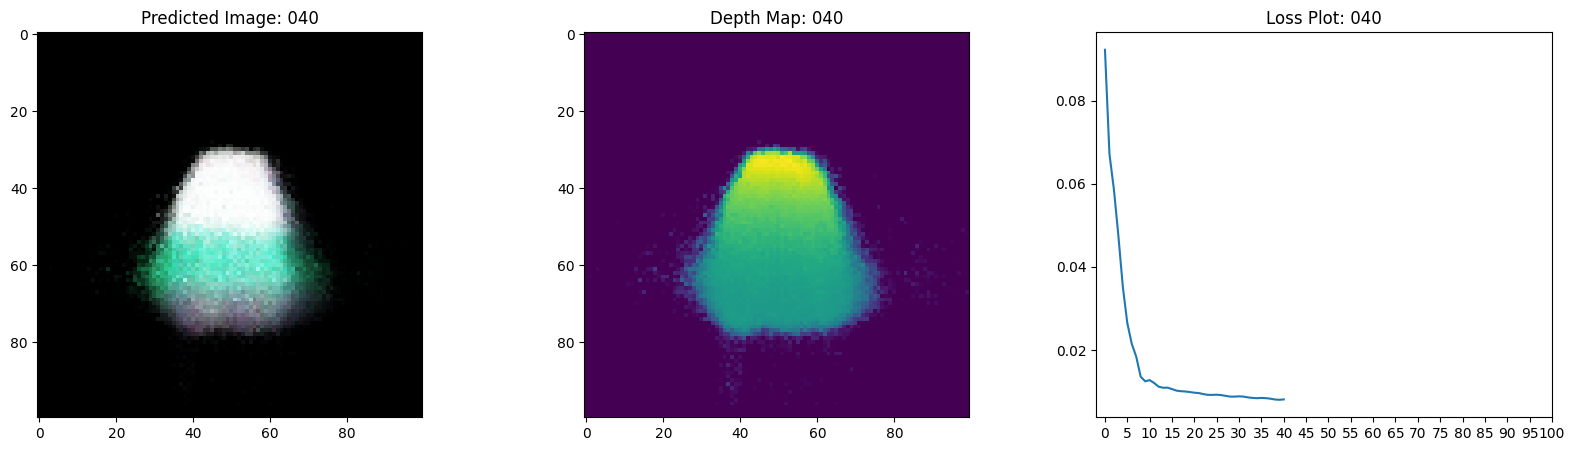

16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0096 - psnr: 20.4957 - val_loss: 0.0146 - val_psnr: 18.5494
Epoch 42/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/stepep - loss: 0.0096 - psnr: 20.47


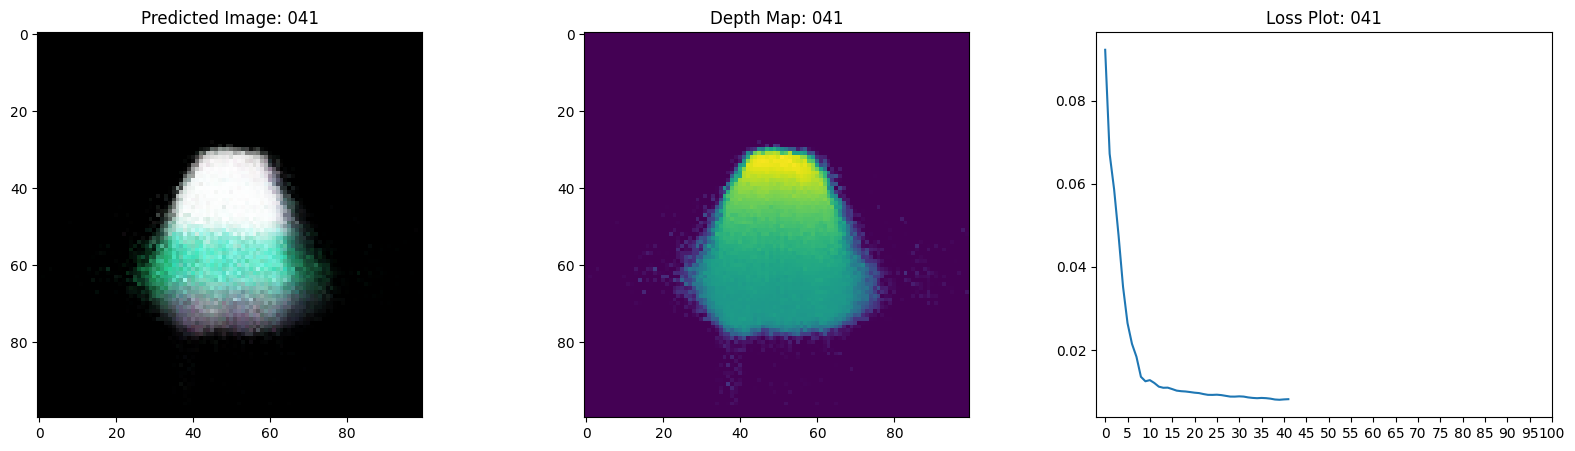

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0095 - psnr: 20.5153 - val_loss: 0.0145 - val_psnr: 18.6020
Epoch 43/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/stepep - loss: 0.0095 - psnr: 20.51


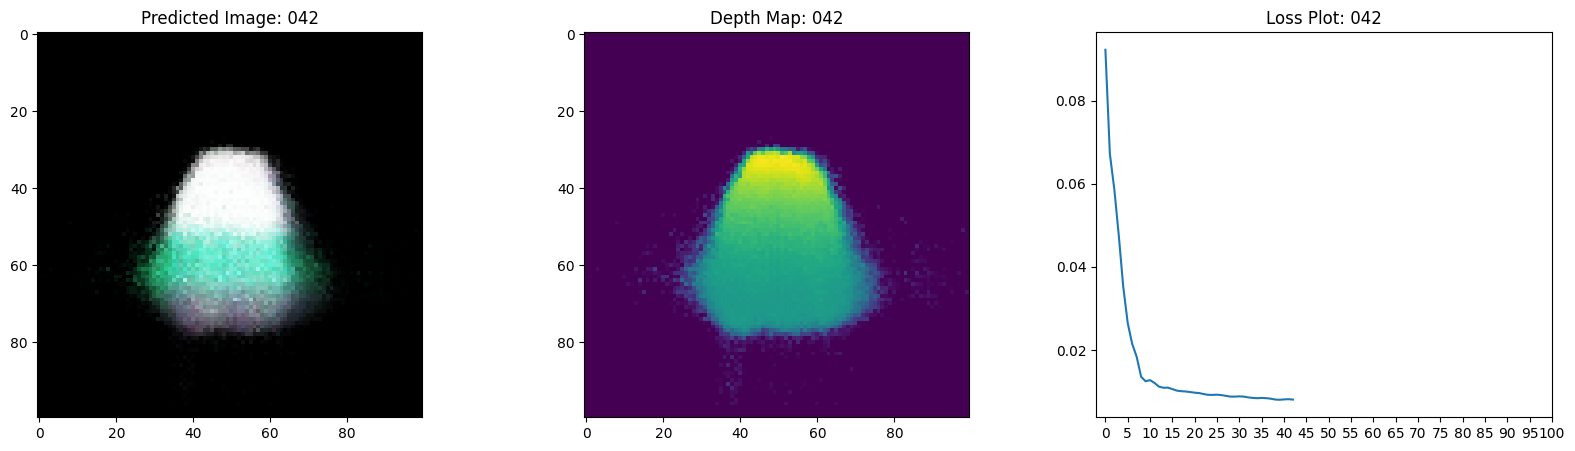

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0094 - psnr: 20.5605 - val_loss: 0.0144 - val_psnr: 18.6569
Epoch 44/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/stepep - loss: 0.0095 - psnr: 20.54


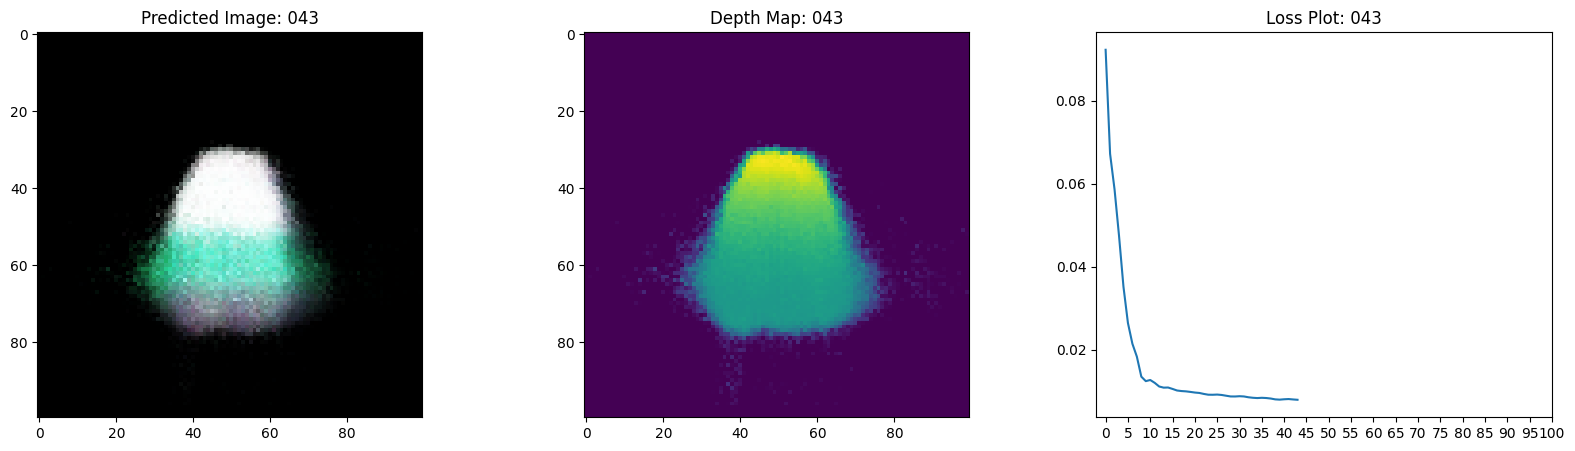

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0094 - psnr: 20.5849 - val_loss: 0.0143 - val_psnr: 18.6649
Epoch 45/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/stepep - loss: 0.0095 - psnr: 20.54


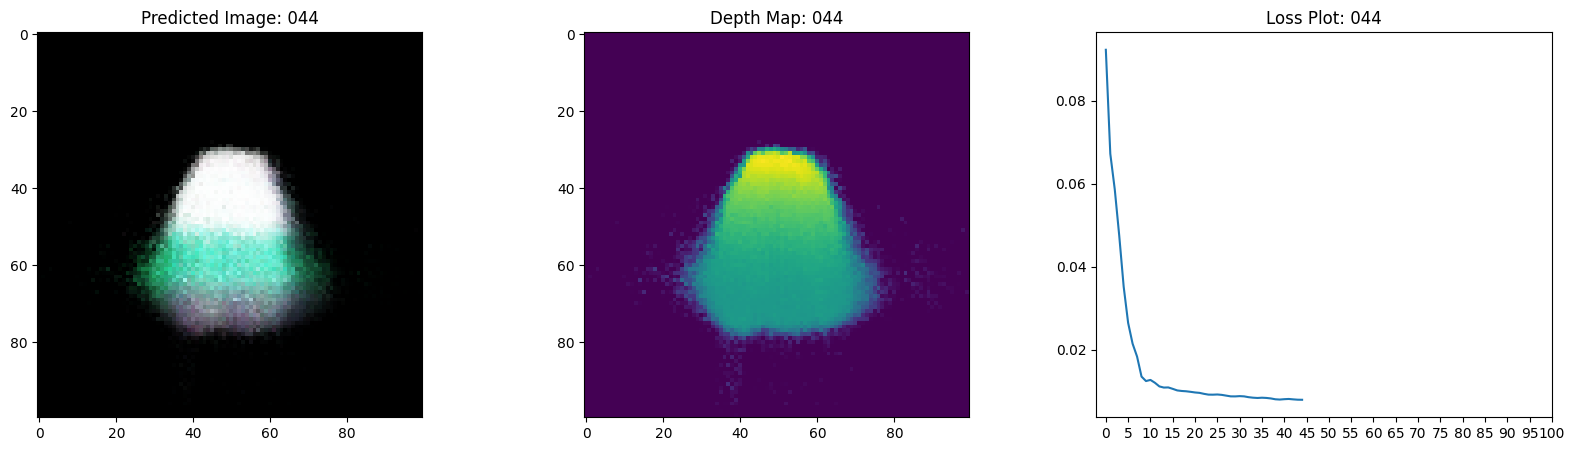

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0094 - psnr: 20.5932 - val_loss: 0.0144 - val_psnr: 18.6477
Epoch 46/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/stepep - loss: 0.0094 - psnr: 20.60


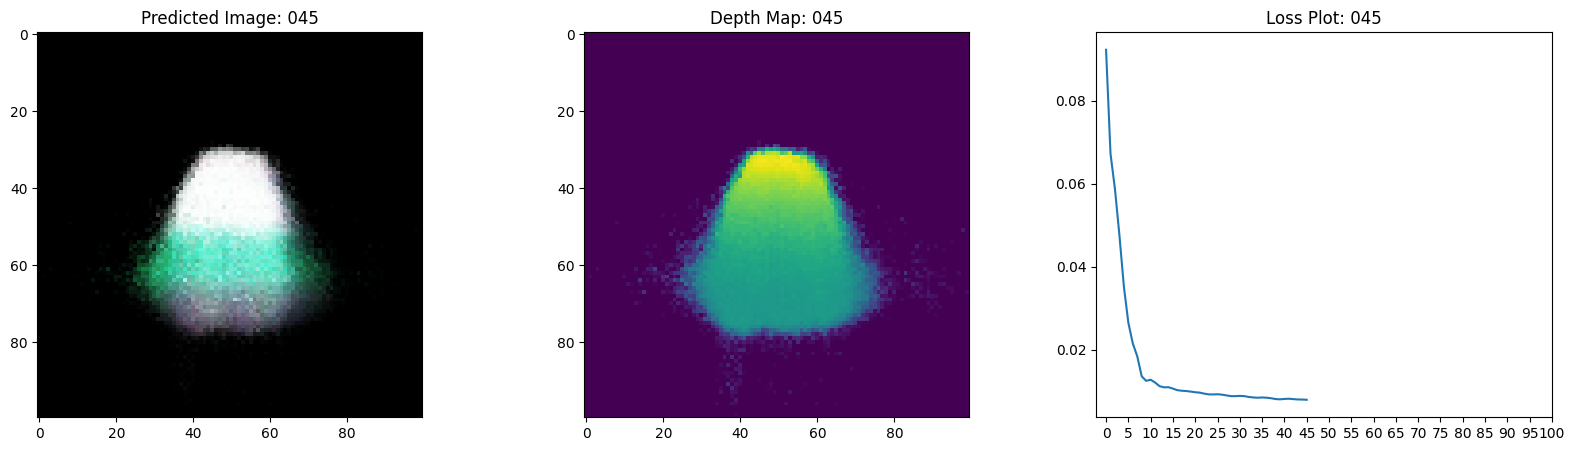

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0093 - psnr: 20.6438 - val_loss: 0.0142 - val_psnr: 18.7248
Epoch 47/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/stepep - loss: 0.0093 - psnr: 20.62


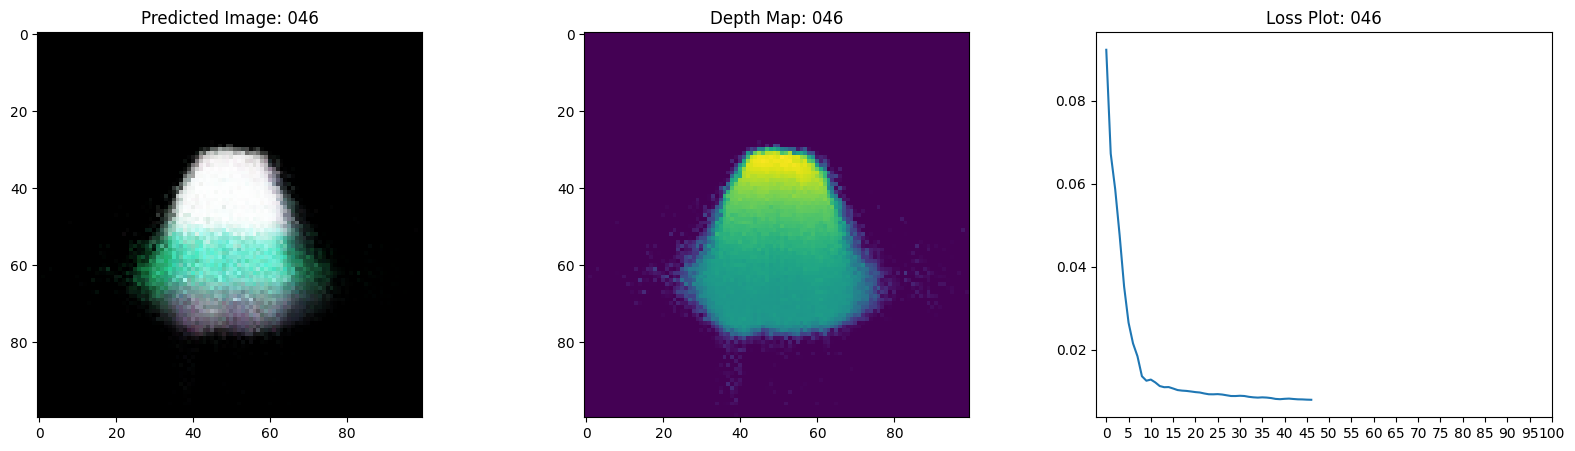

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0092 - psnr: 20.6712 - val_loss: 0.0142 - val_psnr: 18.7267
Epoch 48/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/stepep - loss: 0.0093 - psnr: 20.65


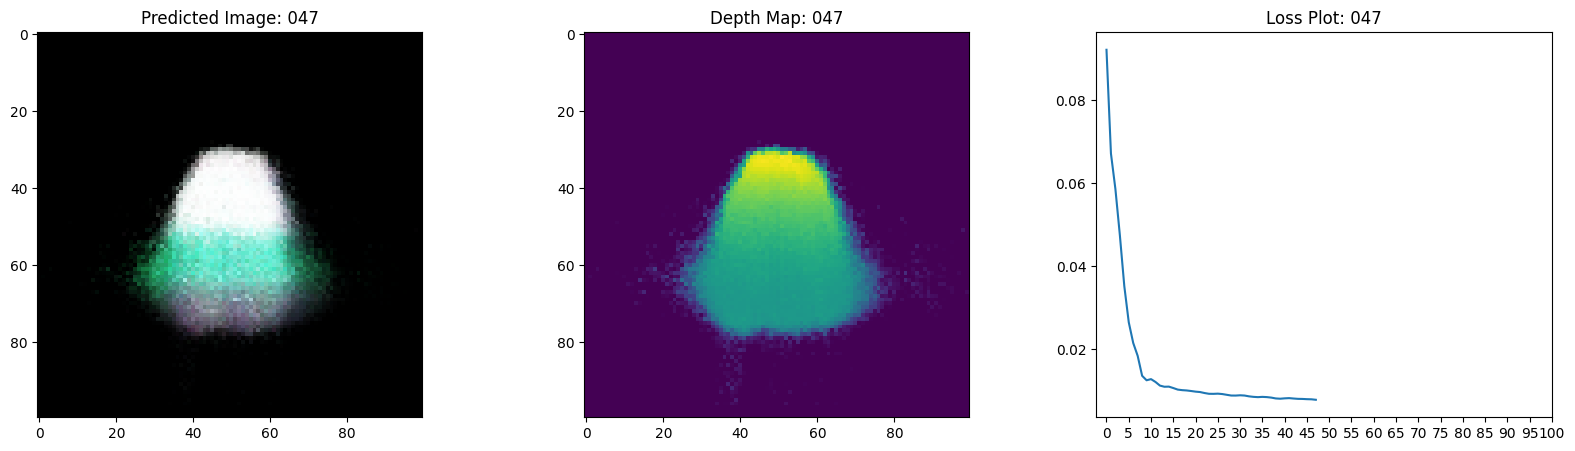

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0092 - psnr: 20.6986 - val_loss: 0.0143 - val_psnr: 18.6811
Epoch 49/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/stepep - loss: 0.0094 - psnr: 20.63


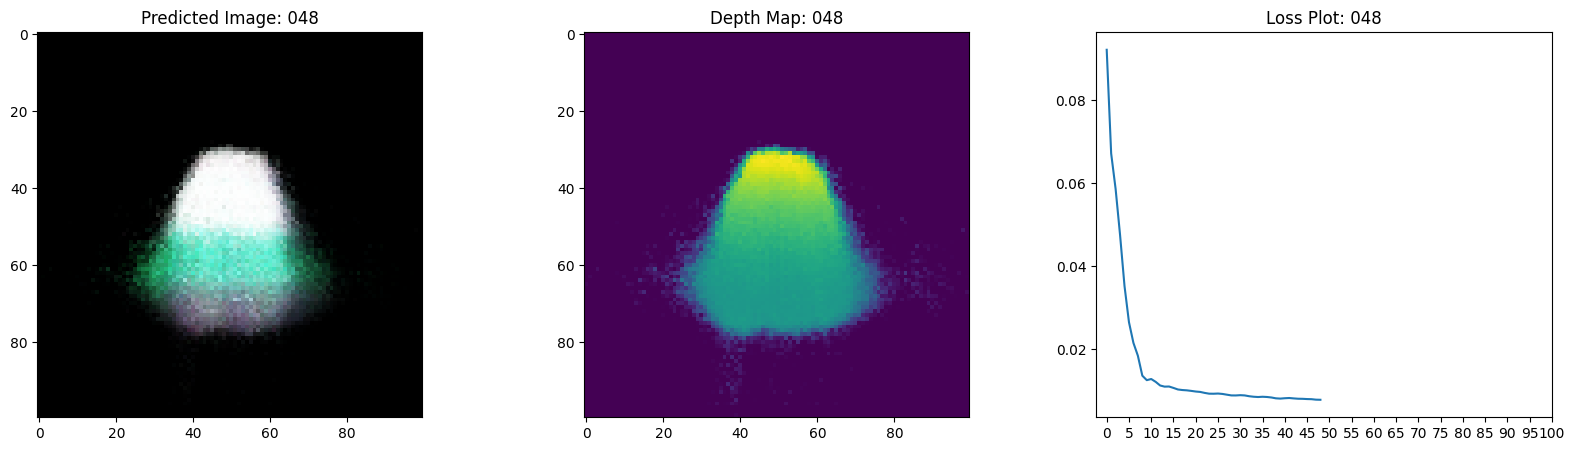

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0093 - psnr: 20.6789 - val_loss: 0.0144 - val_psnr: 18.6861
Epoch 50/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/stepep - loss: 0.0092 - psnr: 20.72


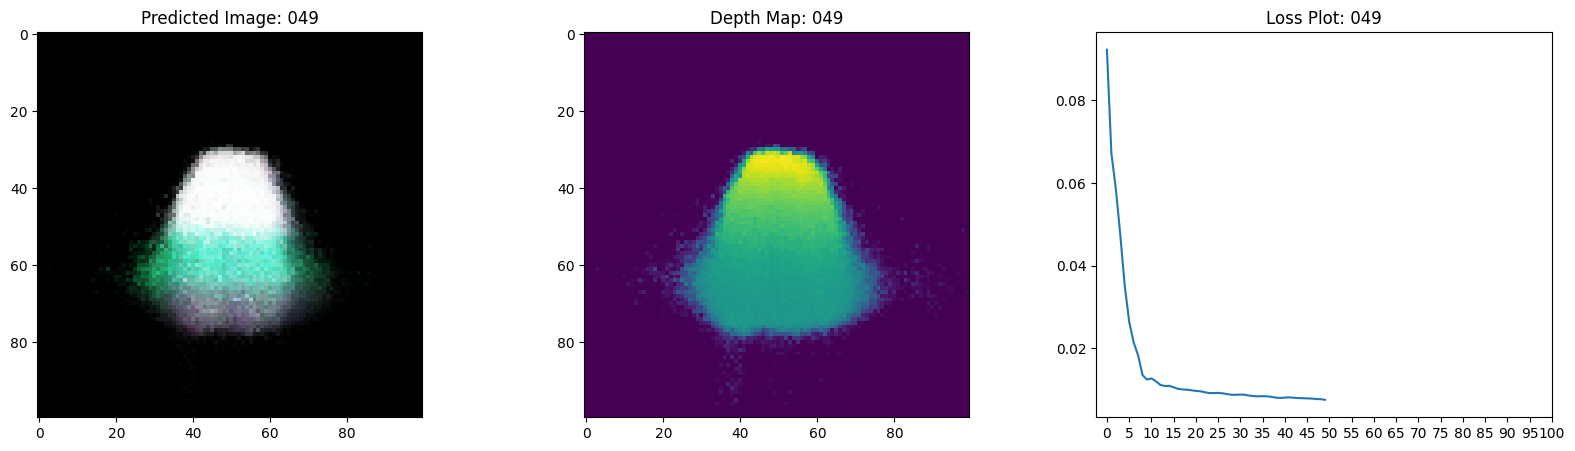

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0091 - psnr: 20.7757 - val_loss: 0.0145 - val_psnr: 18.6575
Epoch 51/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/stepep - loss: 0.0091 - psnr: 20.75


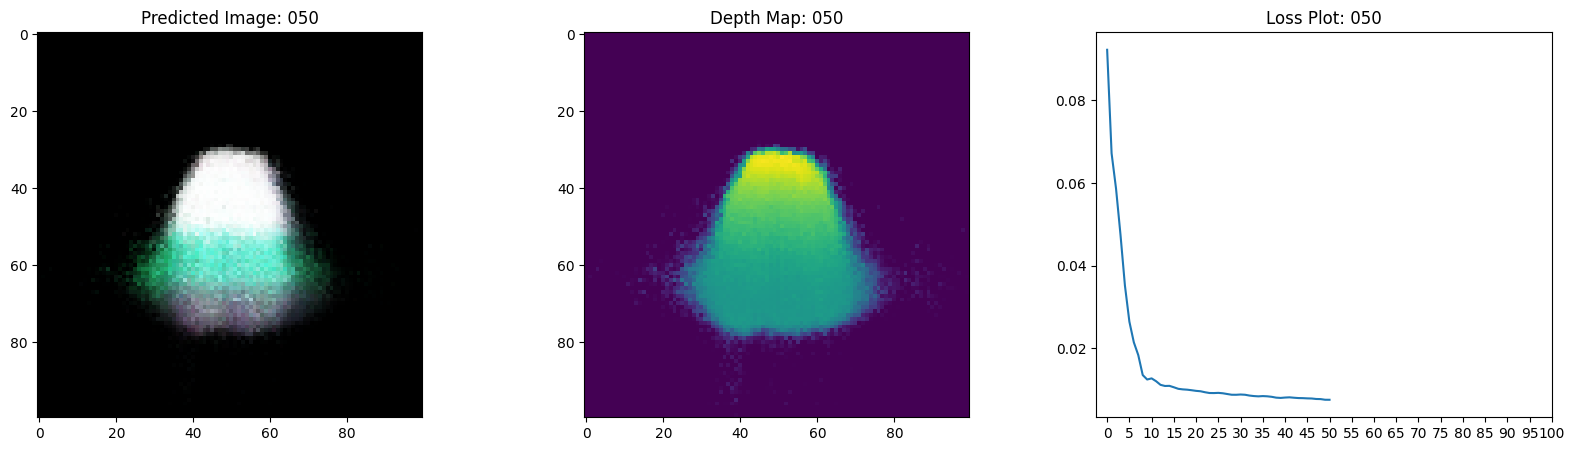

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0091 - psnr: 20.8045 - val_loss: 0.0147 - val_psnr: 18.5785
Epoch 52/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/stepep - loss: 0.0091 - psnr: 20.74


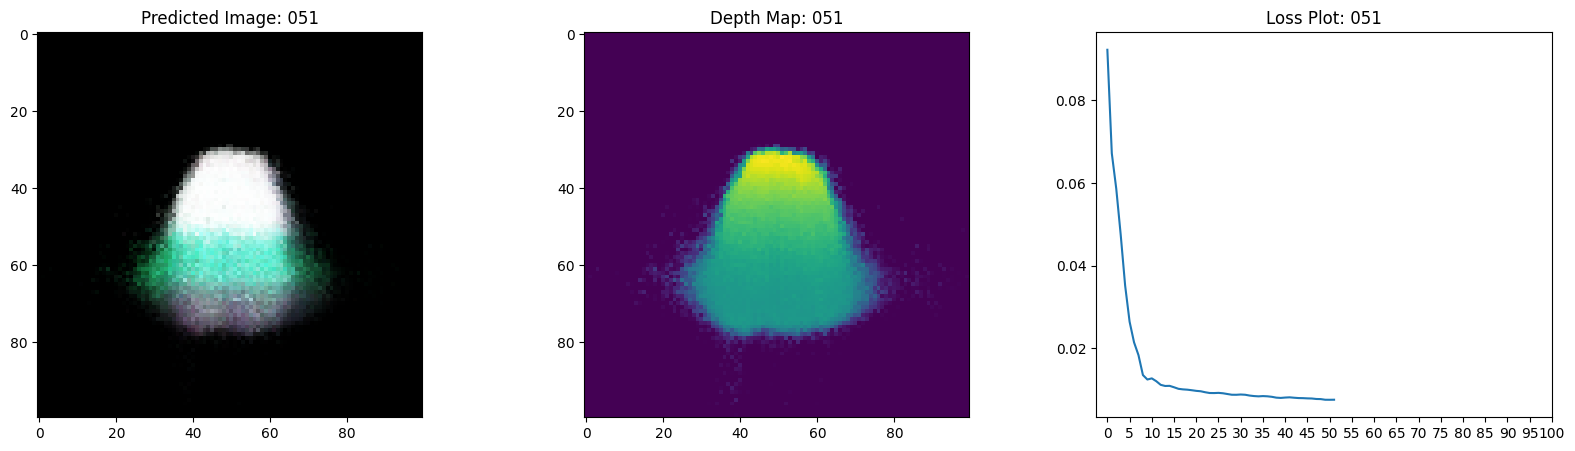

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0091 - psnr: 20.7955 - val_loss: 0.0147 - val_psnr: 18.5756
Epoch 53/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/stepep - loss: 0.0092 - psnr: 20.71


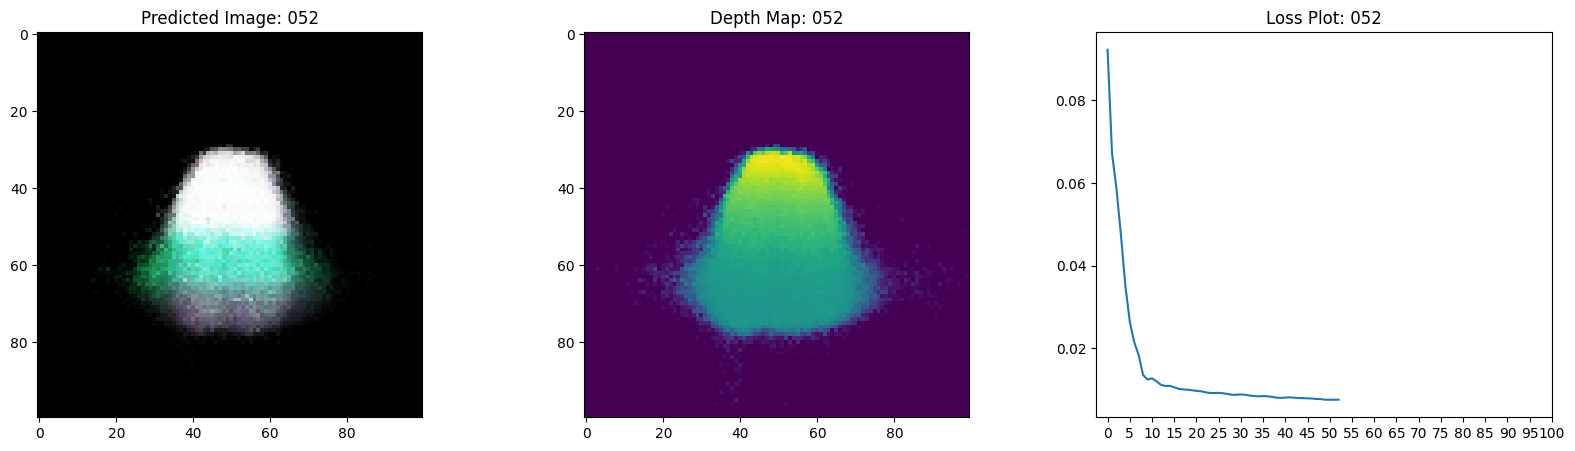

16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0091 - psnr: 20.7672 - val_loss: 0.0144 - val_psnr: 18.6761
Epoch 54/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/stepep - loss: 0.0091 - psnr: 20.77


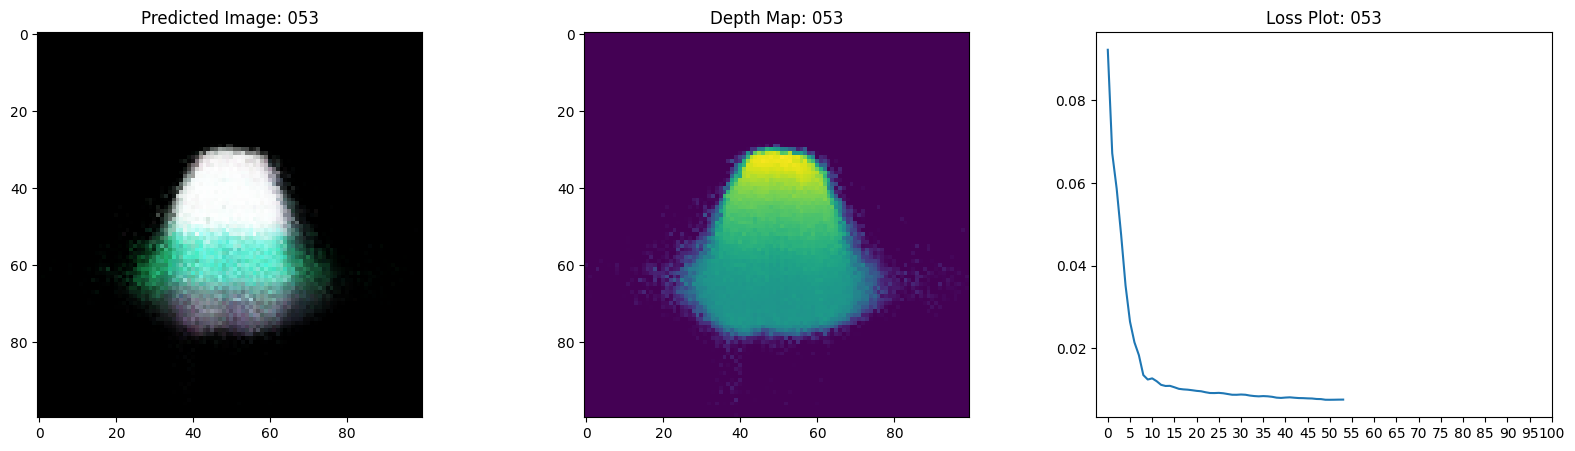

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0090 - psnr: 20.8182 - val_loss: 0.0143 - val_psnr: 18.7260
Epoch 55/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/stepep - loss: 0.0089 - psnr: 20.84


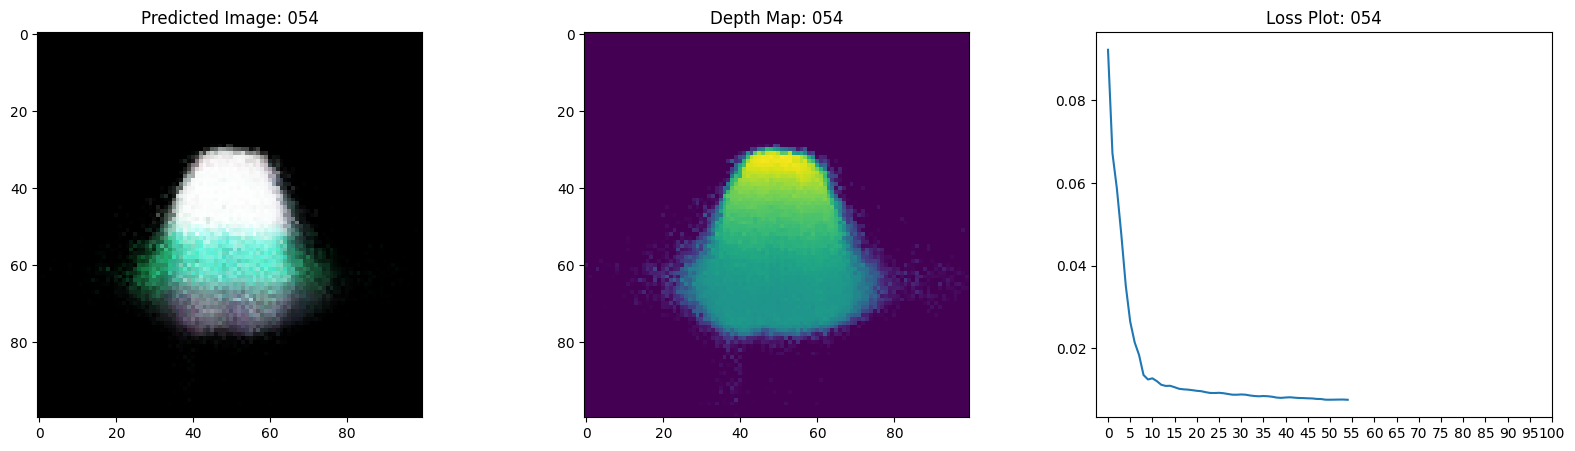

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0089 - psnr: 20.8819 - val_loss: 0.0141 - val_psnr: 18.8242
Epoch 56/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/stepep - loss: 0.0091 - psnr: 20.78


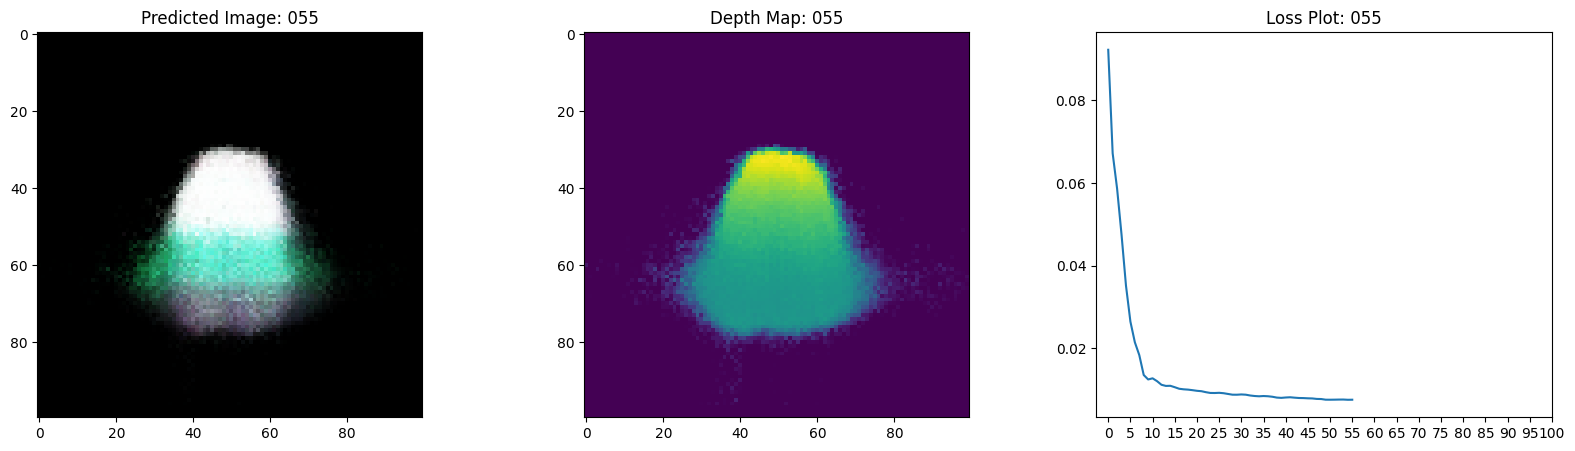

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0090 - psnr: 20.8275 - val_loss: 0.0141 - val_psnr: 18.7921
Epoch 57/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/stepep - loss: 0.0089 - psnr: 20.89


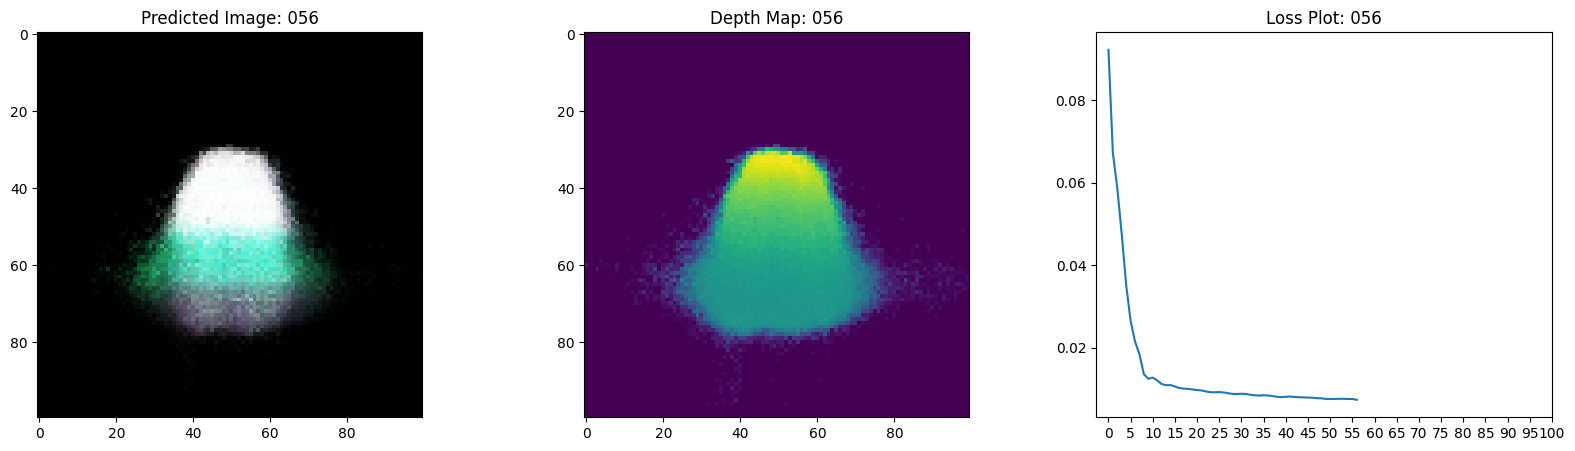

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0088 - psnr: 20.9387 - val_loss: 0.0141 - val_psnr: 18.8052
Epoch 58/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/stepep - loss: 0.0088 - psnr: 20.94


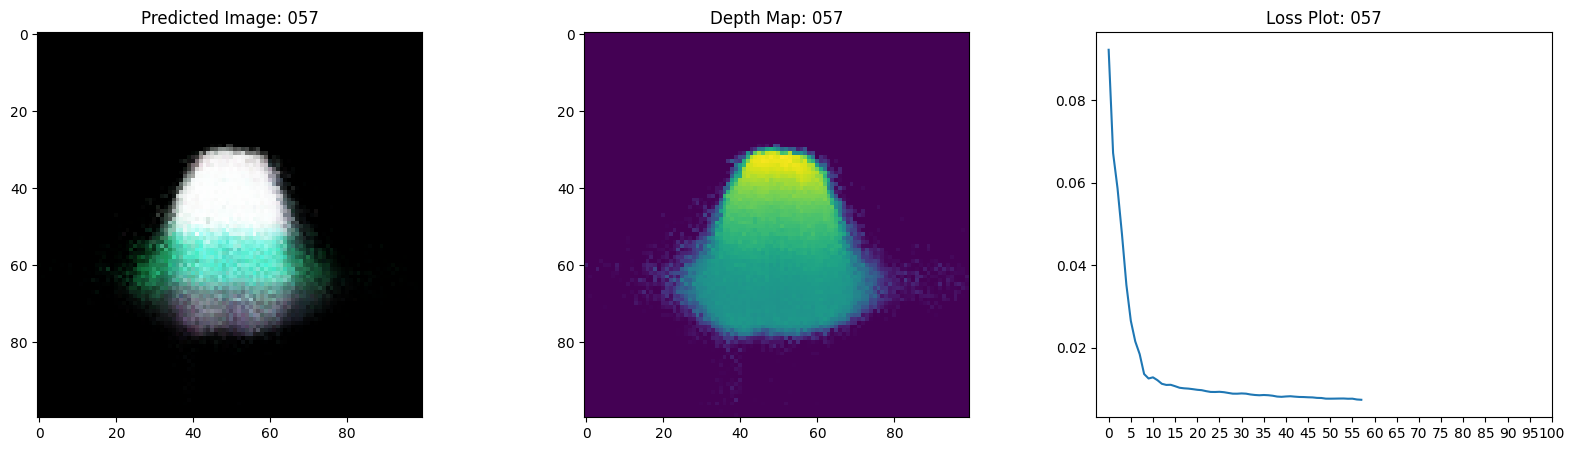

16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0087 - psnr: 20.9854 - val_loss: 0.0145 - val_psnr: 18.6831
Epoch 59/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/stepep - loss: 0.0088 - psnr: 20.95


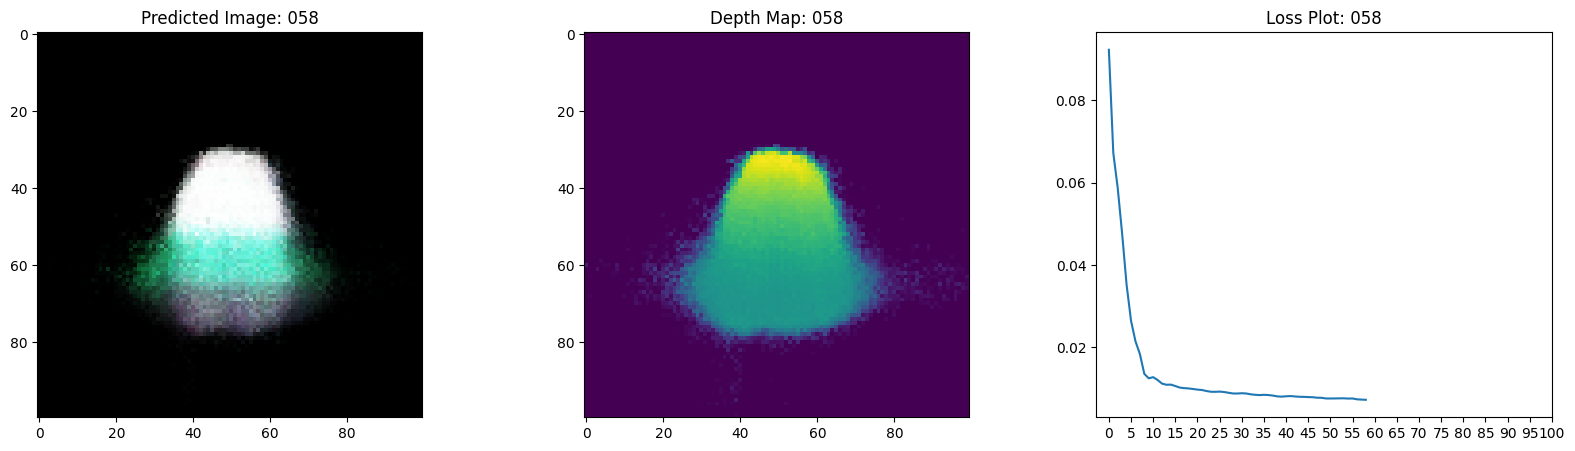

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0087 - psnr: 20.9982 - val_loss: 0.0147 - val_psnr: 18.6268
Epoch 60/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/stepep - loss: 0.0088 - psnr: 20.94


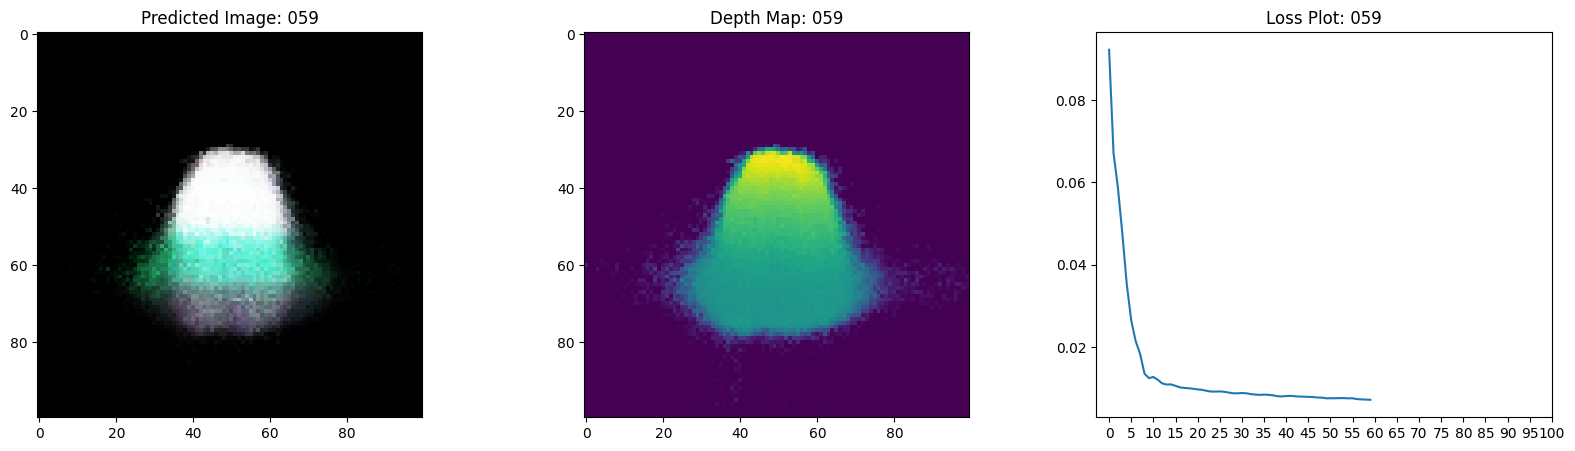

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0087 - psnr: 20.9968 - val_loss: 0.0147 - val_psnr: 18.6359
Epoch 61/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/stepep - loss: 0.0090 - psnr: 20.90


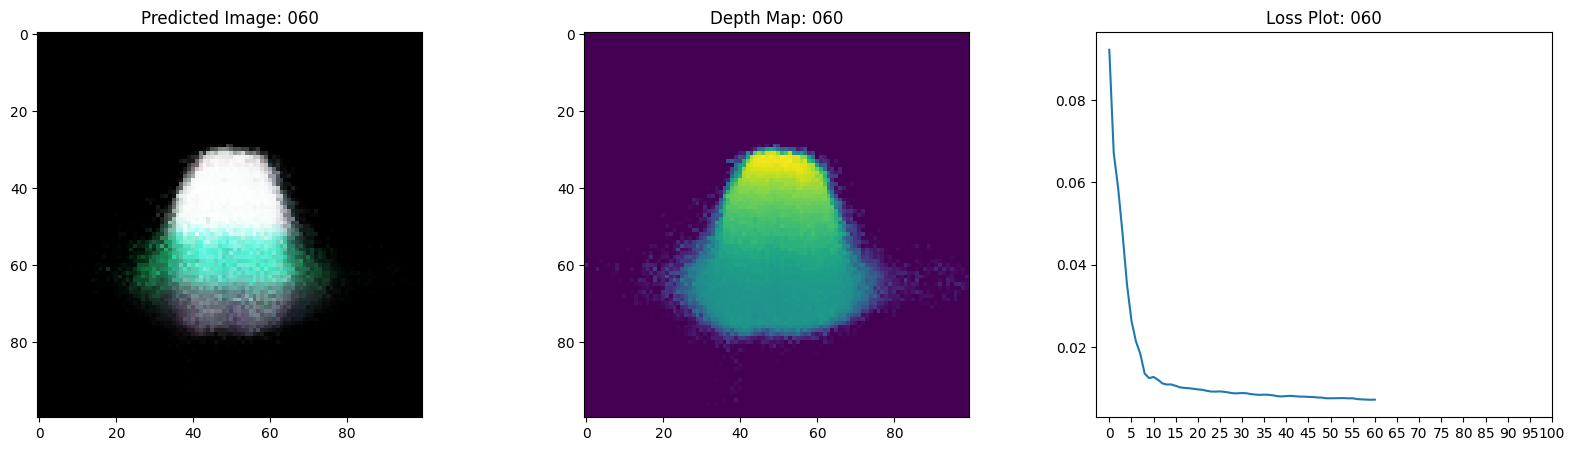

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0089 - psnr: 20.9534 - val_loss: 0.0147 - val_psnr: 18.6150
Epoch 62/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/stepep - loss: 0.0090 - psnr: 20.87


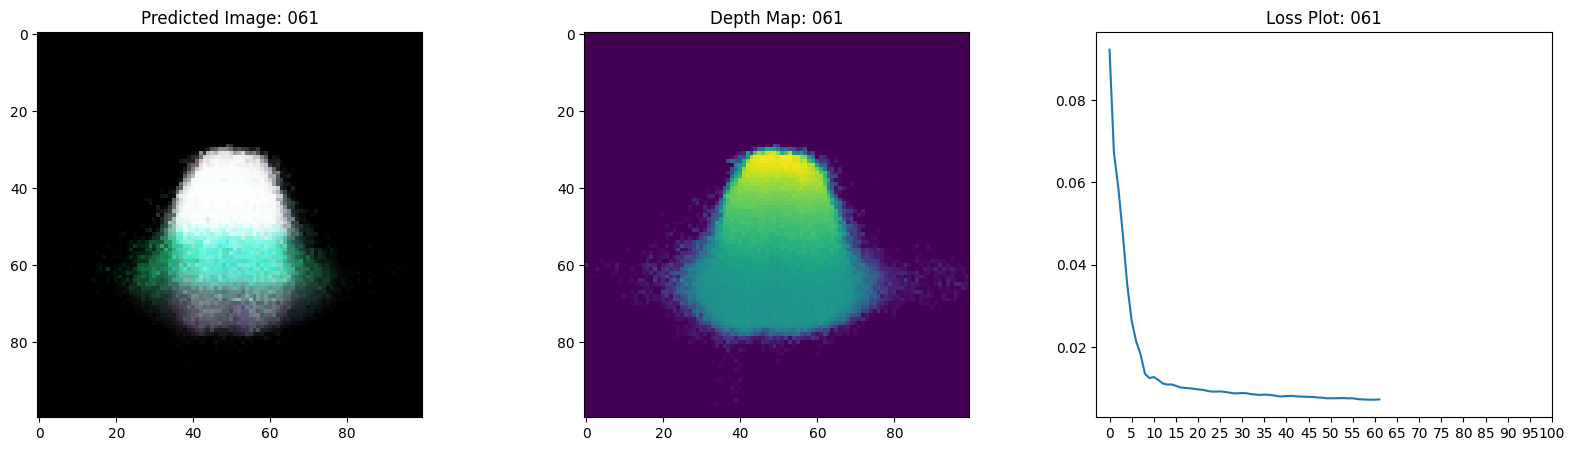

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0089 - psnr: 20.9281 - val_loss: 0.0145 - val_psnr: 18.6797
Epoch 63/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/stepep - loss: 0.0089 - psnr: 20.95


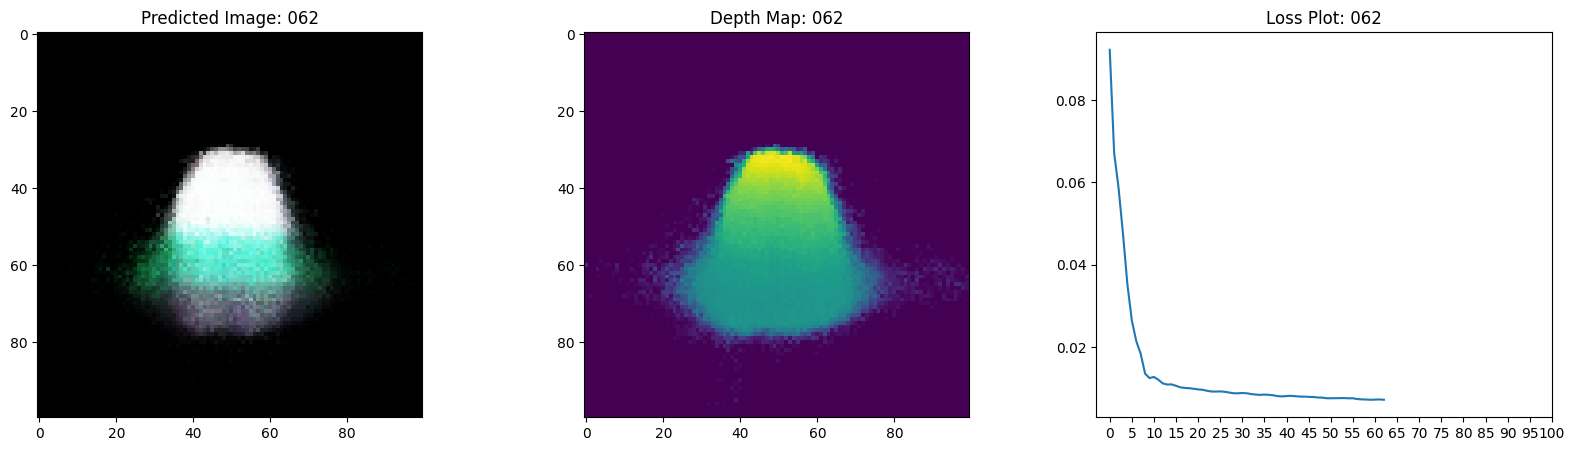

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0088 - psnr: 21.0084 - val_loss: 0.0145 - val_psnr: 18.7015
Epoch 64/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/stepep - loss: 0.0089 - psnr: 20.94


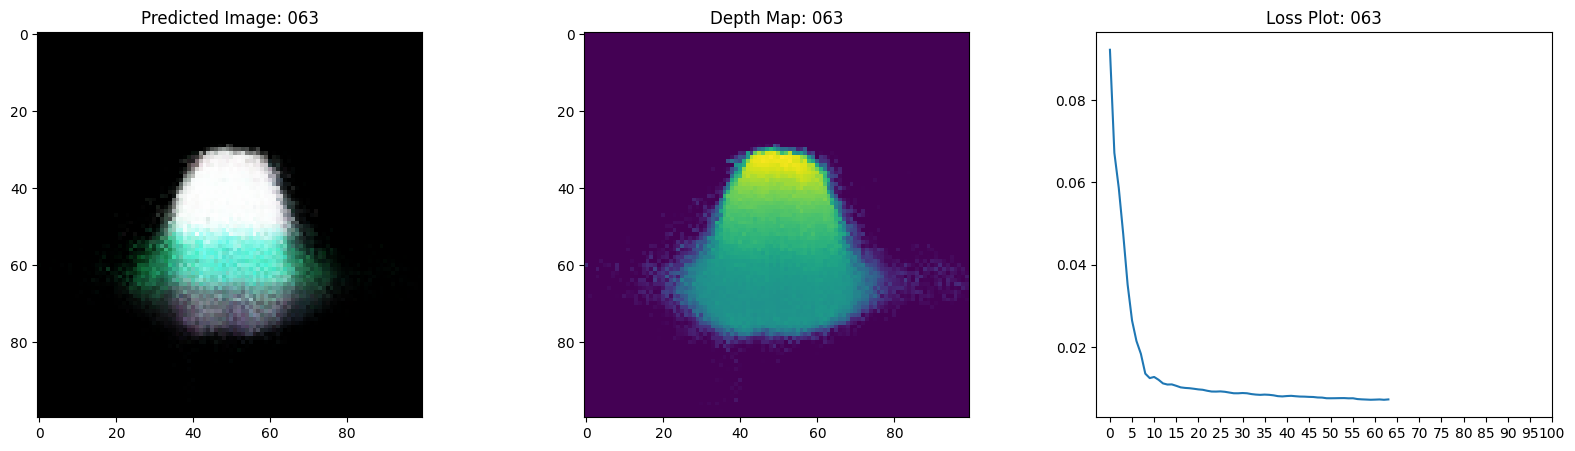

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0088 - psnr: 20.9890 - val_loss: 0.0144 - val_psnr: 18.7333
Epoch 65/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/stepep - loss: 0.0089 - psnr: 20.91


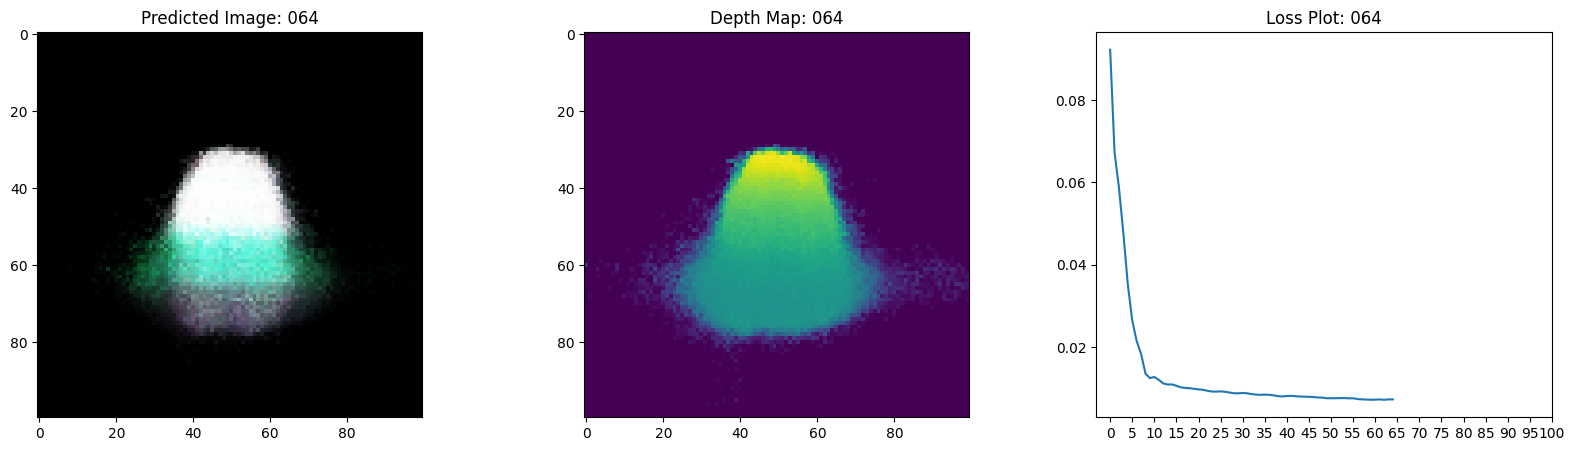

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0088 - psnr: 20.9674 - val_loss: 0.0142 - val_psnr: 18.8086
Epoch 66/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/stepep - loss: 0.0087 - psnr: 21.03


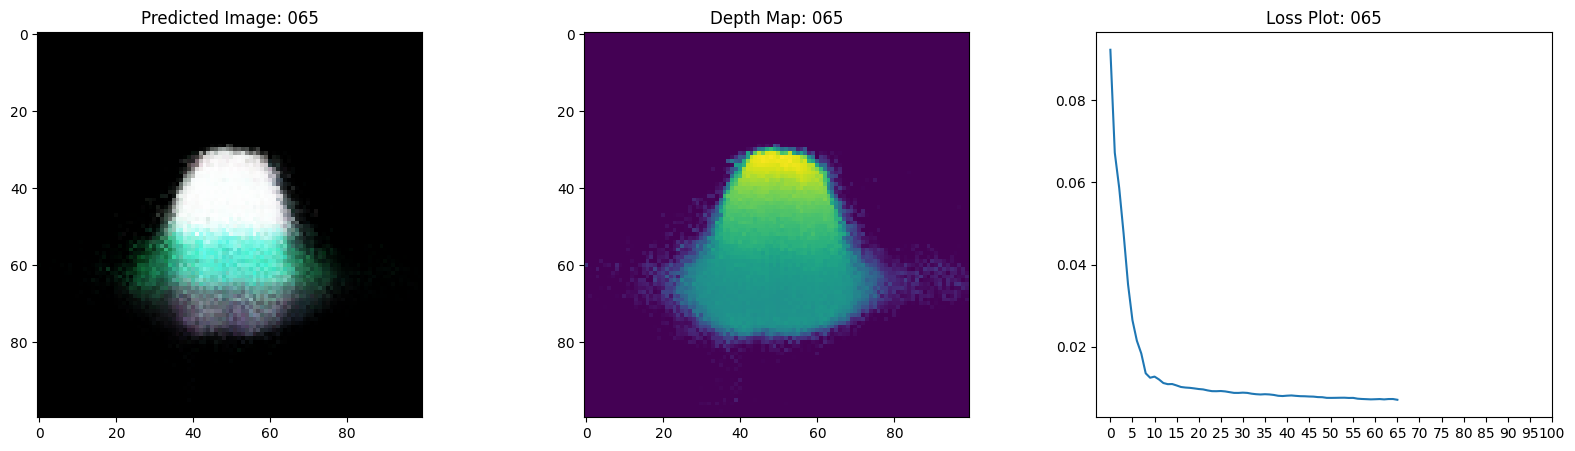

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0086 - psnr: 21.0795 - val_loss: 0.0142 - val_psnr: 18.8247
Epoch 67/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/stepep - loss: 0.0087 - psnr: 21.07


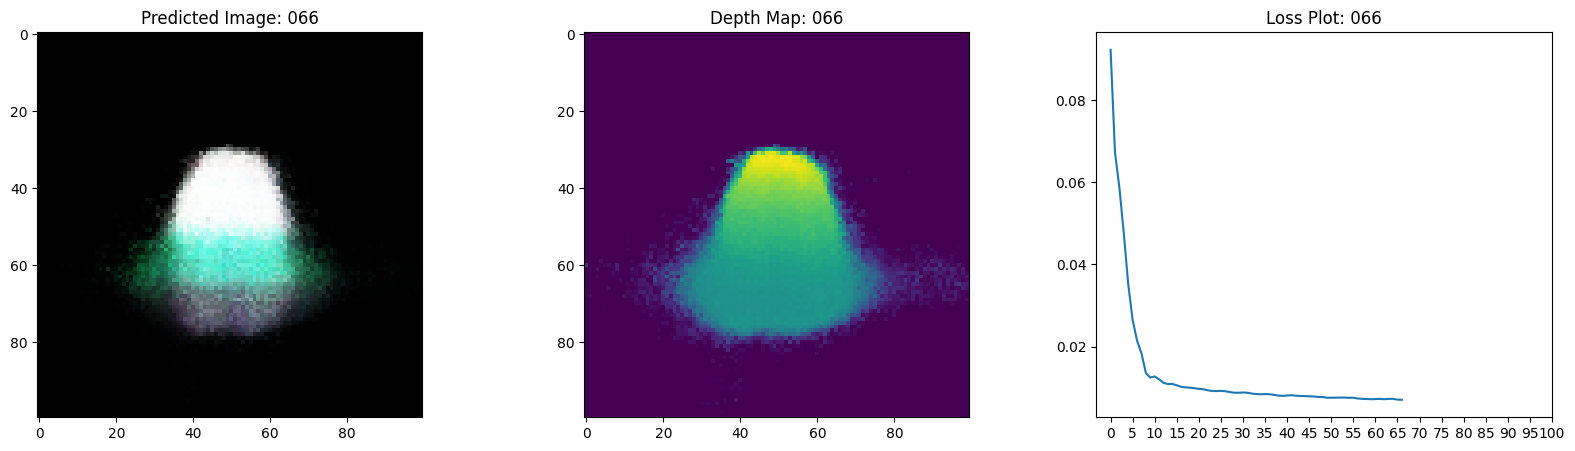

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0086 - psnr: 21.1209 - val_loss: 0.0145 - val_psnr: 18.7306
Epoch 68/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/stepep - loss: 0.0086 - psnr: 21.08


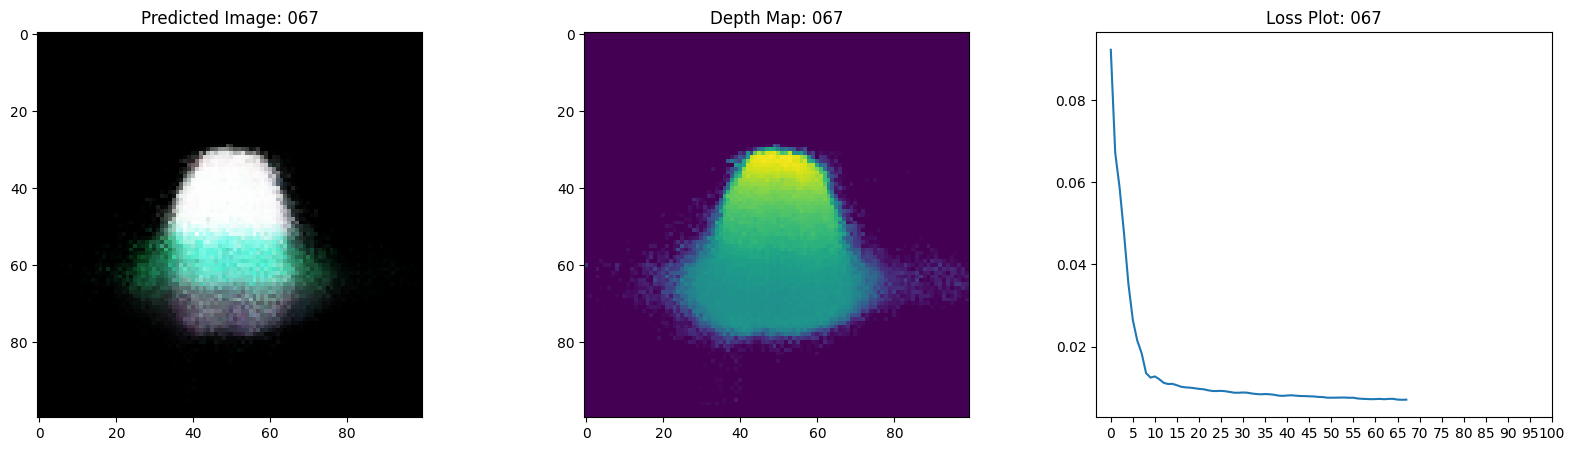

16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0085 - psnr: 21.1353 - val_loss: 0.0143 - val_psnr: 18.8003
Epoch 69/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/stepep - loss: 0.0086 - psnr: 21.08


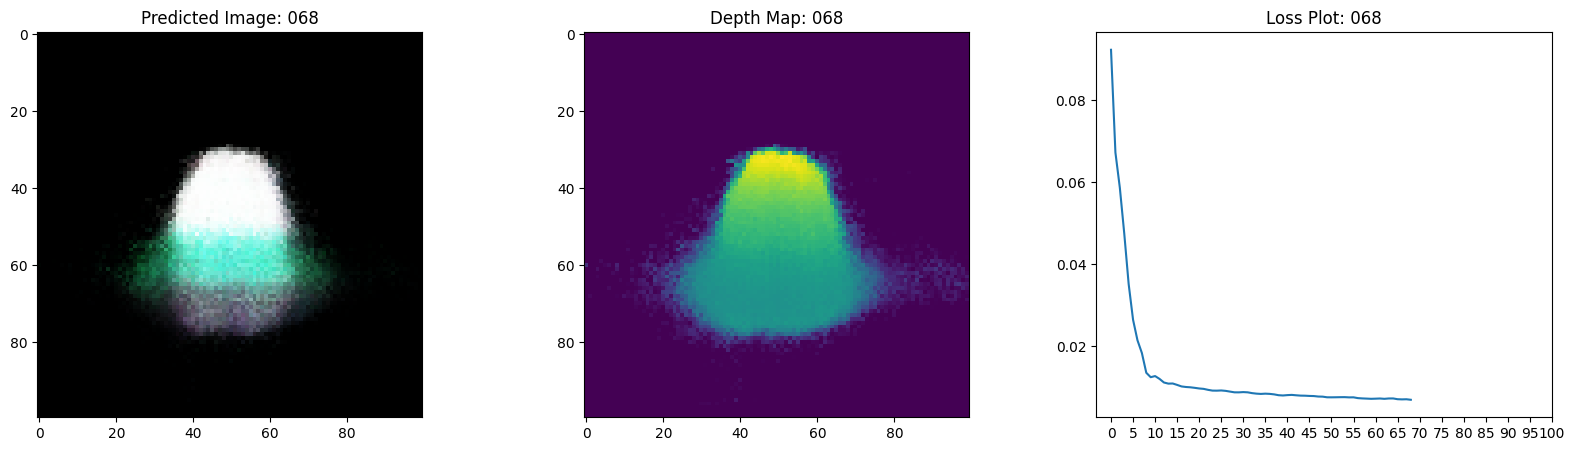

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0085 - psnr: 21.1343 - val_loss: 0.0145 - val_psnr: 18.7157
Epoch 70/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/stepep - loss: 0.0085 - psnr: 21.14


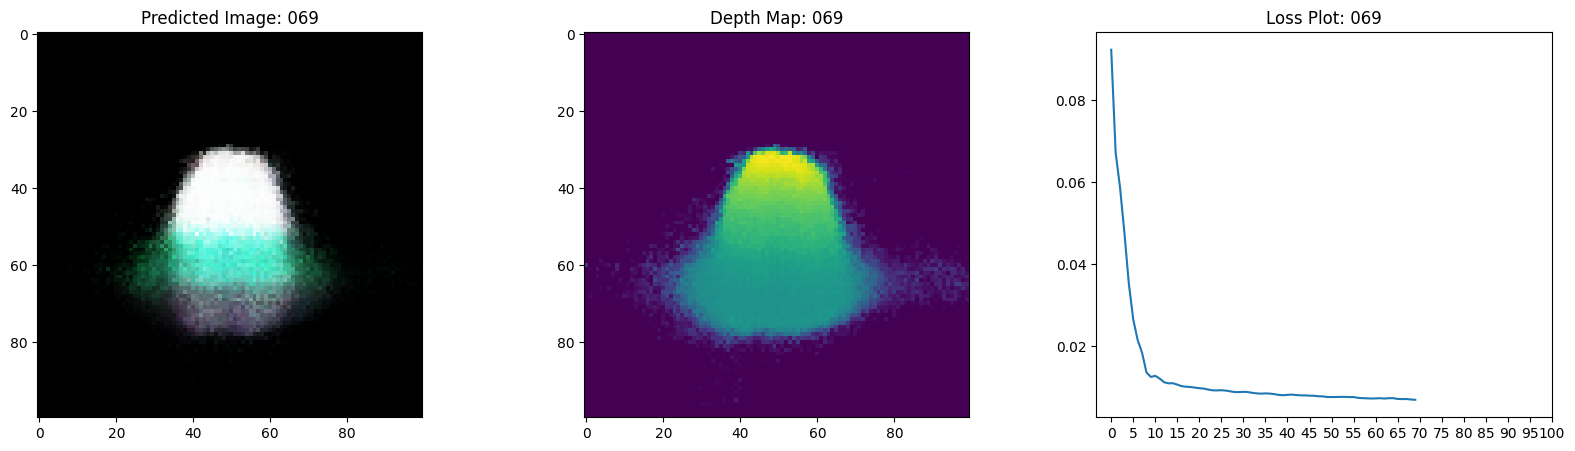

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0084 - psnr: 21.1957 - val_loss: 0.0145 - val_psnr: 18.7238
Epoch 71/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/stepep - loss: 0.0085 - psnr: 21.17


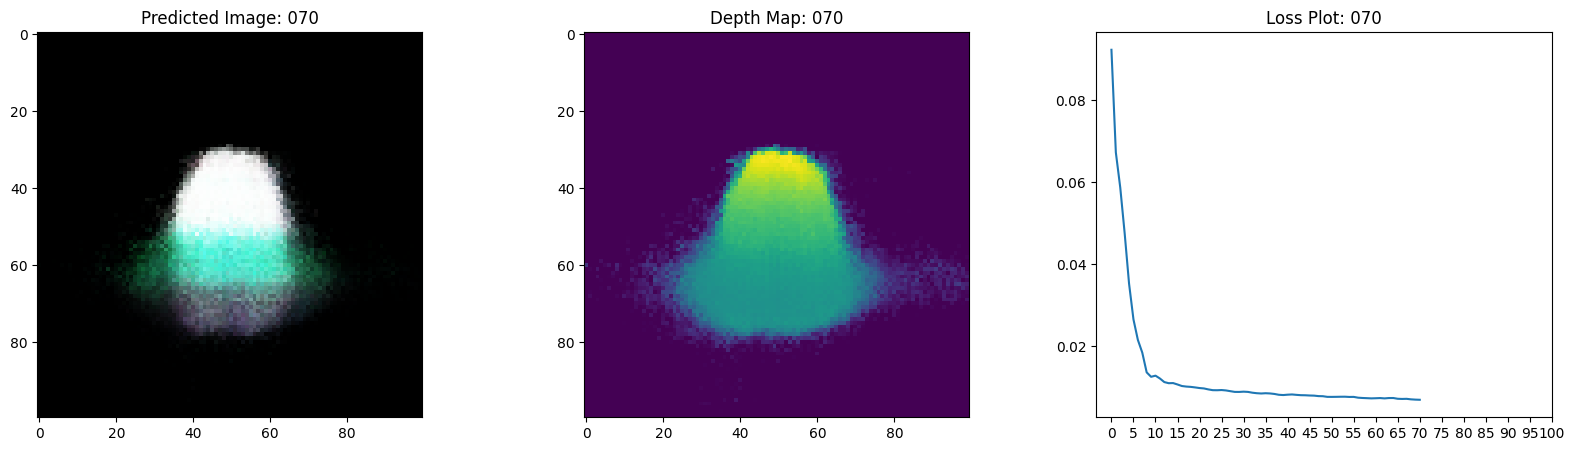

16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0084 - psnr: 21.2237 - val_loss: 0.0150 - val_psnr: 18.5666
Epoch 72/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/stepep - loss: 0.0087 - psnr: 21.10


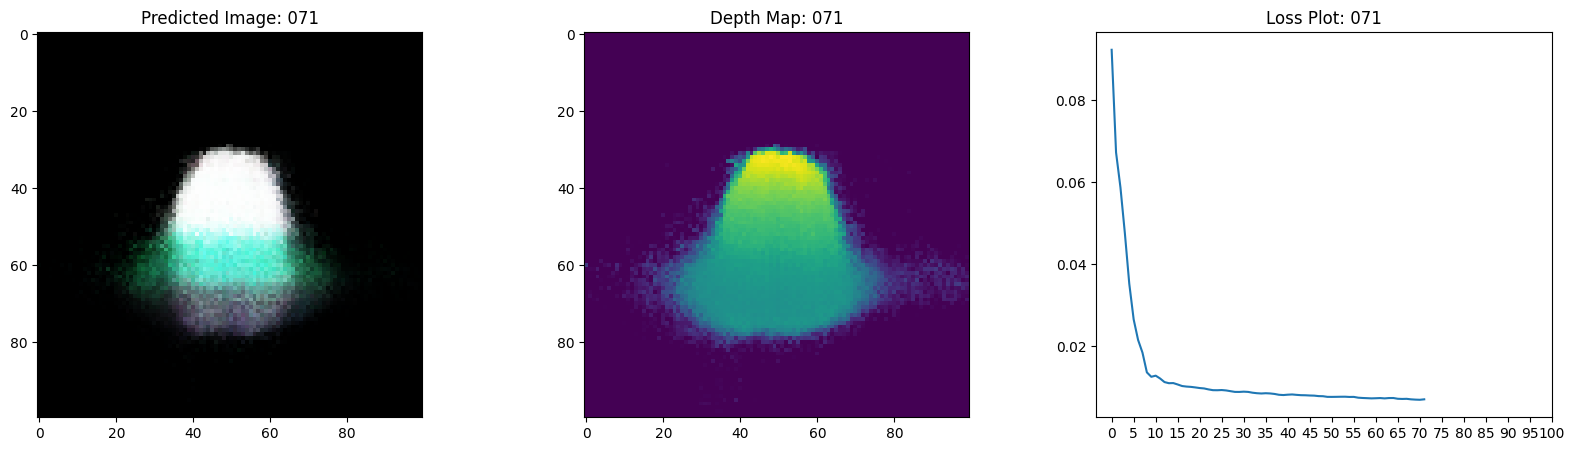

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0086 - psnr: 21.1502 - val_loss: 0.0147 - val_psnr: 18.6769
Epoch 73/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/stepep - loss: 0.0085 - psnr: 21.16


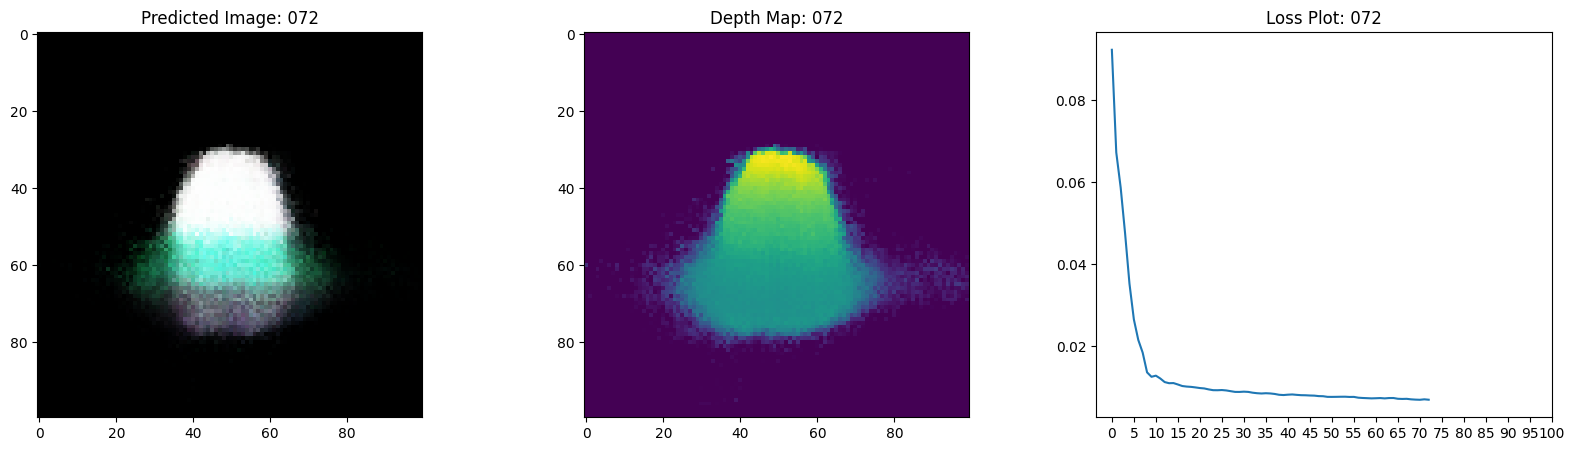

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0084 - psnr: 21.2161 - val_loss: 0.0148 - val_psnr: 18.6278
Epoch 74/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/stepep - loss: 0.0086 - psnr: 21.10


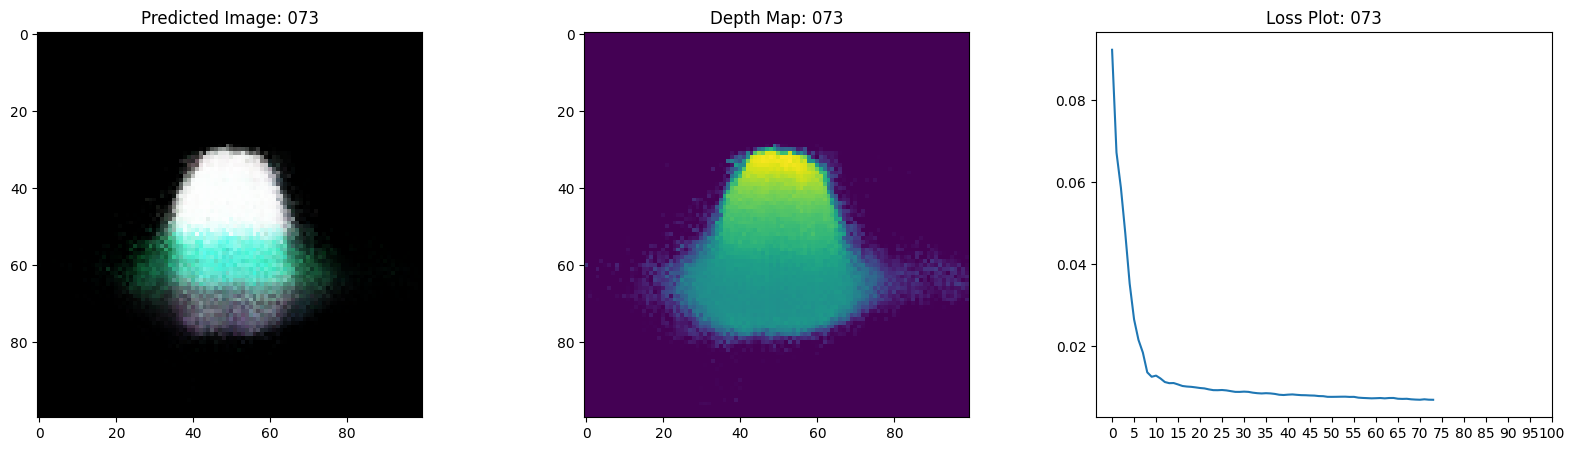

16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0085 - psnr: 21.1586 - val_loss: 0.0146 - val_psnr: 18.6880
Epoch 75/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/stepep - loss: 0.0083 - psnr: 21.26


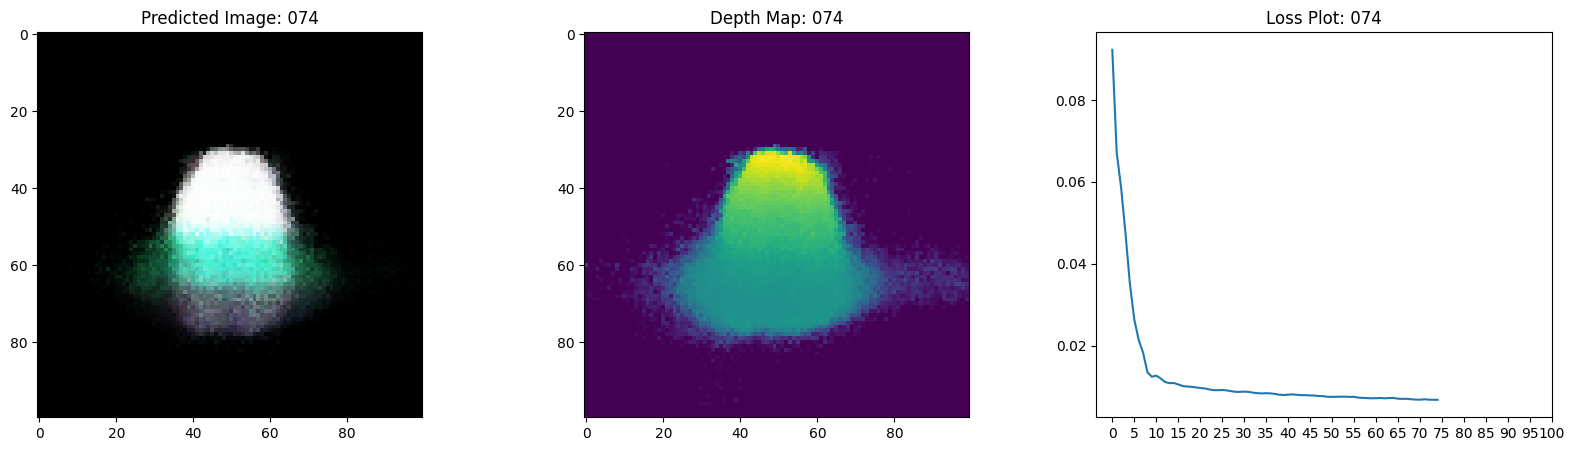

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0082 - psnr: 21.3070 - val_loss: 0.0151 - val_psnr: 18.5255
Epoch 76/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/stepep - loss: 0.0085 - psnr: 21.18


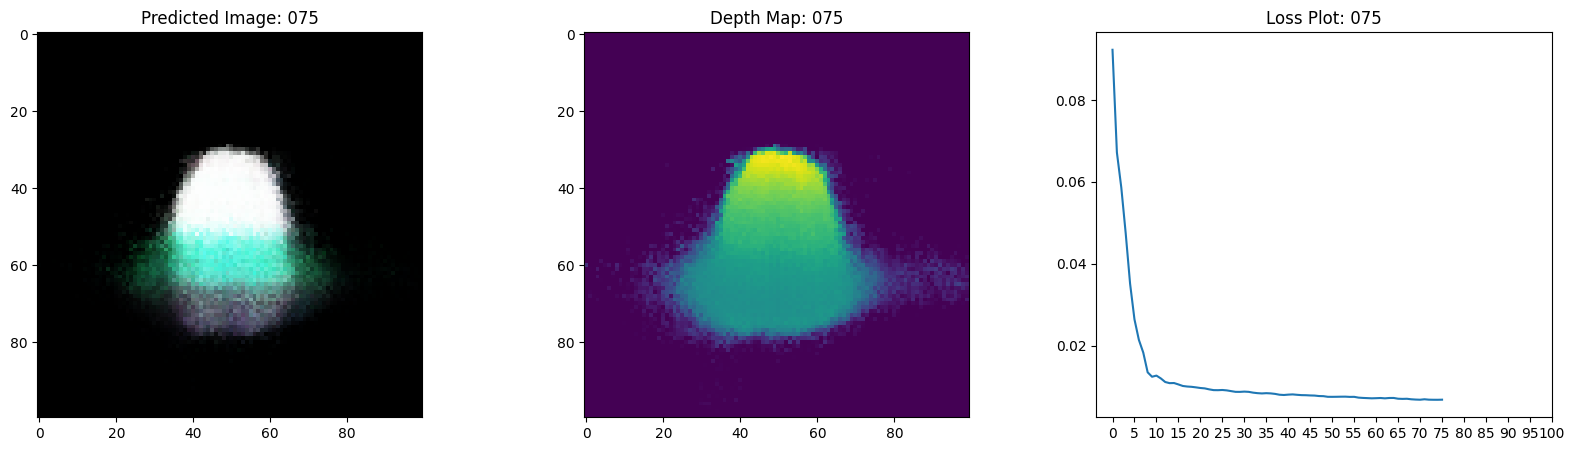

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0084 - psnr: 21.2314 - val_loss: 0.0149 - val_psnr: 18.6196
Epoch 77/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/stepep - loss: 0.0083 - psnr: 21.28


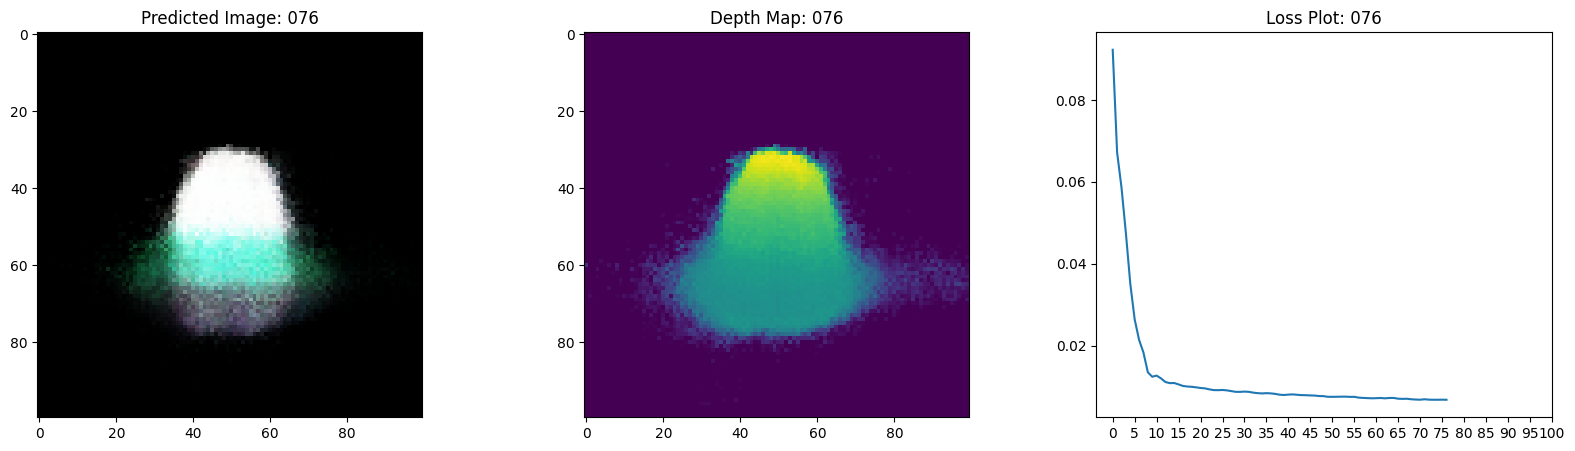

16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0082 - psnr: 21.3304 - val_loss: 0.0149 - val_psnr: 18.6350
Epoch 78/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/stepep - loss: 0.0084 - psnr: 21.18


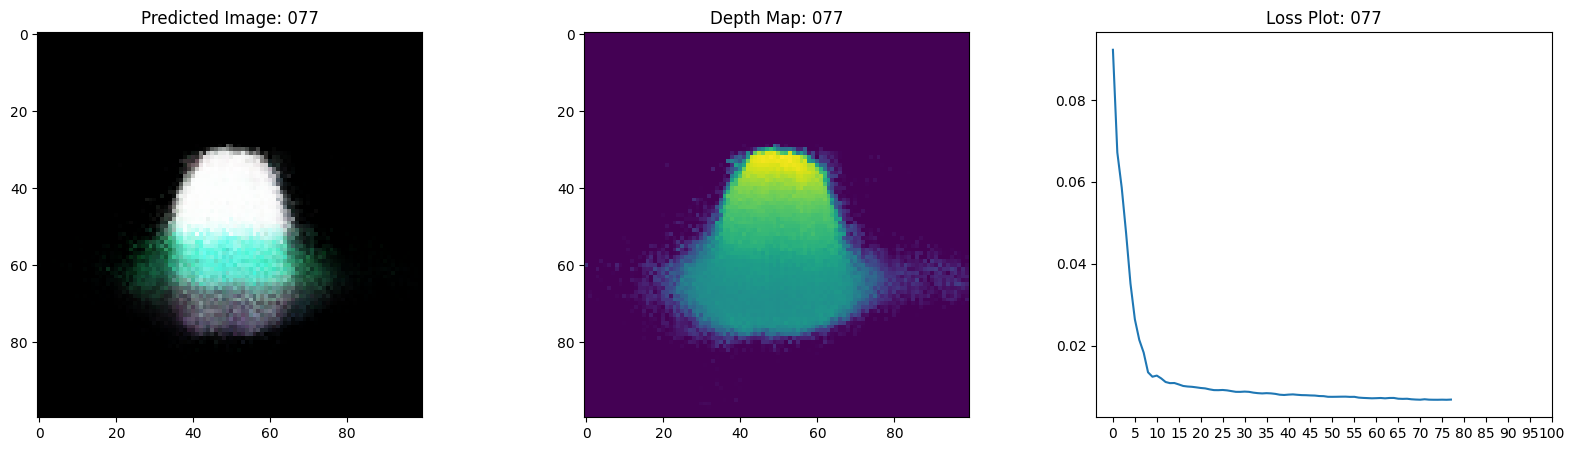

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0083 - psnr: 21.2280 - val_loss: 0.0147 - val_psnr: 18.6710
Epoch 79/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/stepep - loss: 0.0083 - psnr: 21.22


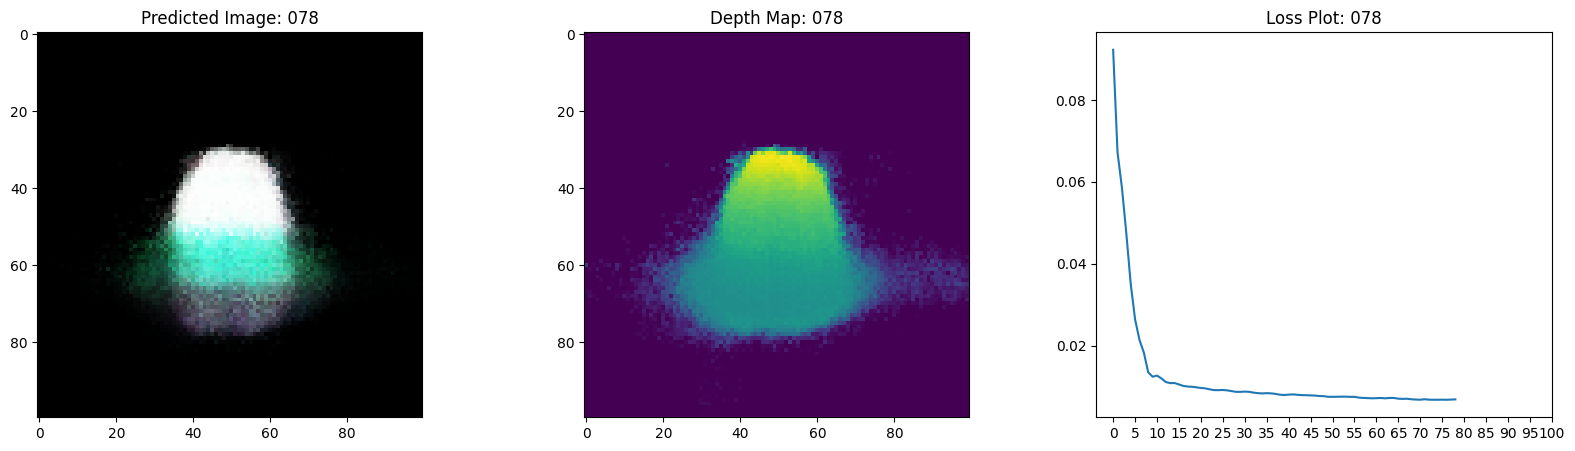

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0083 - psnr: 21.2670 - val_loss: 0.0145 - val_psnr: 18.7394
Epoch 80/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/stepep - loss: 0.0086 - psnr: 21.08


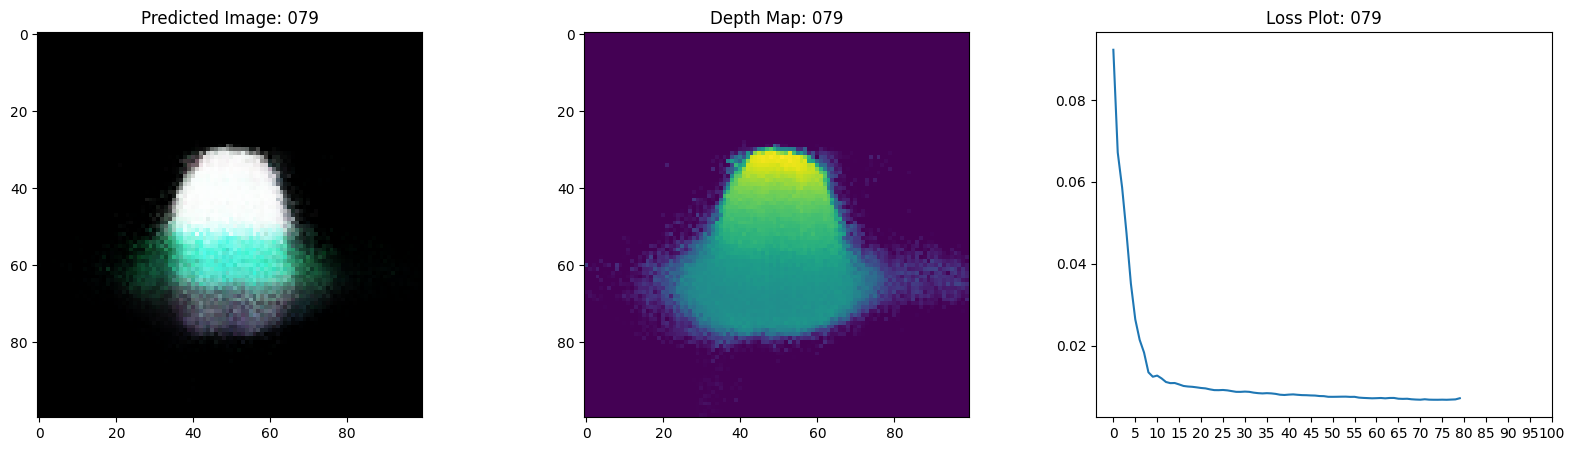

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0086 - psnr: 21.1227 - val_loss: 0.0143 - val_psnr: 18.8166
Epoch 81/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/stepep - loss: 0.0087 - psnr: 21.01


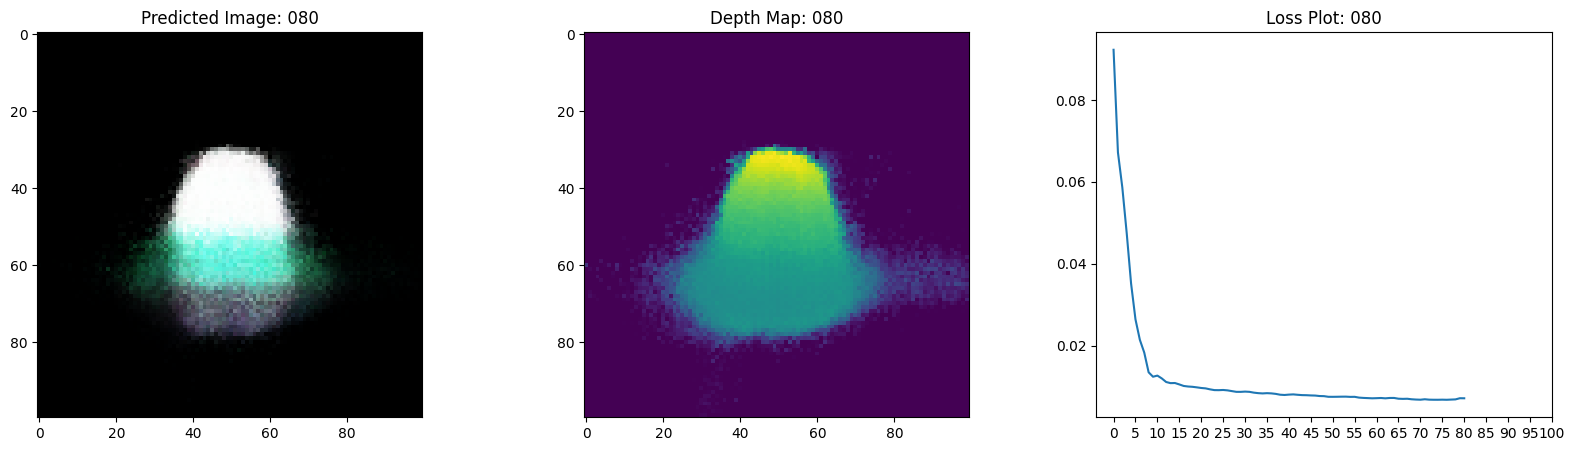

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0087 - psnr: 21.0558 - val_loss: 0.0141 - val_psnr: 18.9264
Epoch 82/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/stepep - loss: 0.0085 - psnr: 21.17


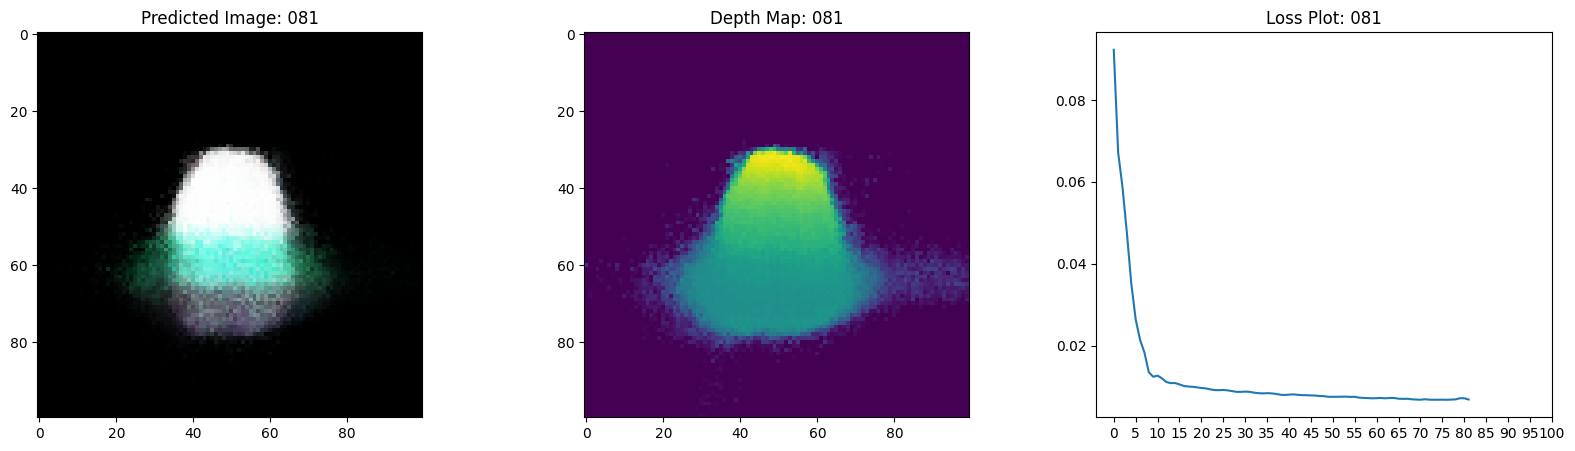

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0084 - psnr: 21.2187 - val_loss: 0.0141 - val_psnr: 18.9198
Epoch 83/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/stepep - loss: 0.0082 - psnr: 21.36


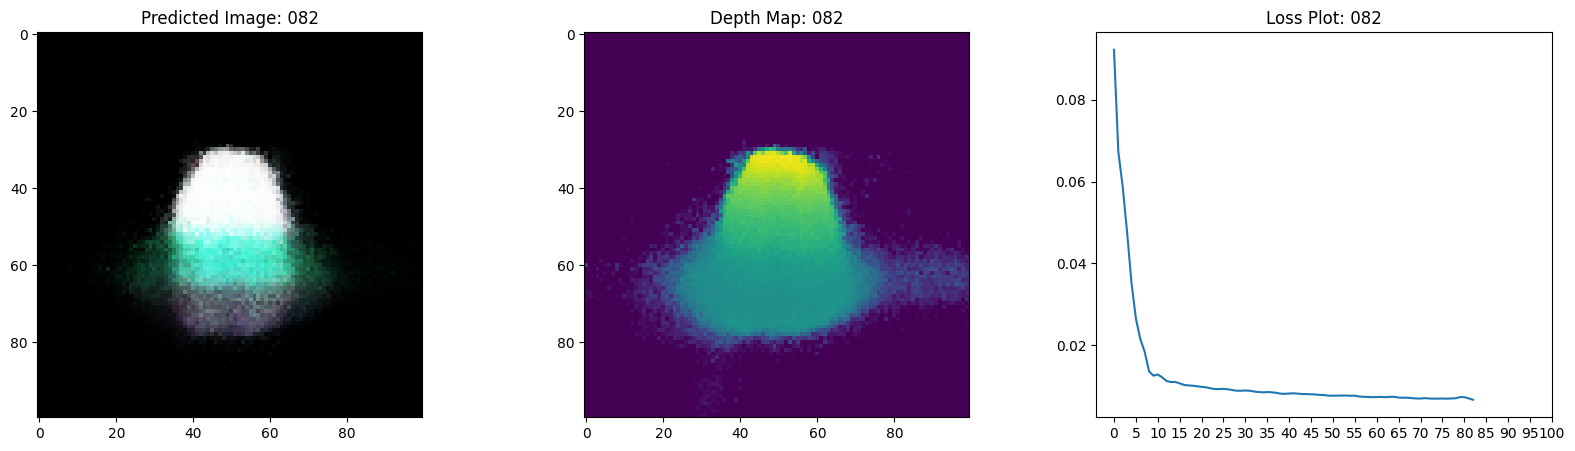

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0081 - psnr: 21.4135 - val_loss: 0.0149 - val_psnr: 18.7022
Epoch 84/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/stepep - loss: 0.0083 - psnr: 21.33


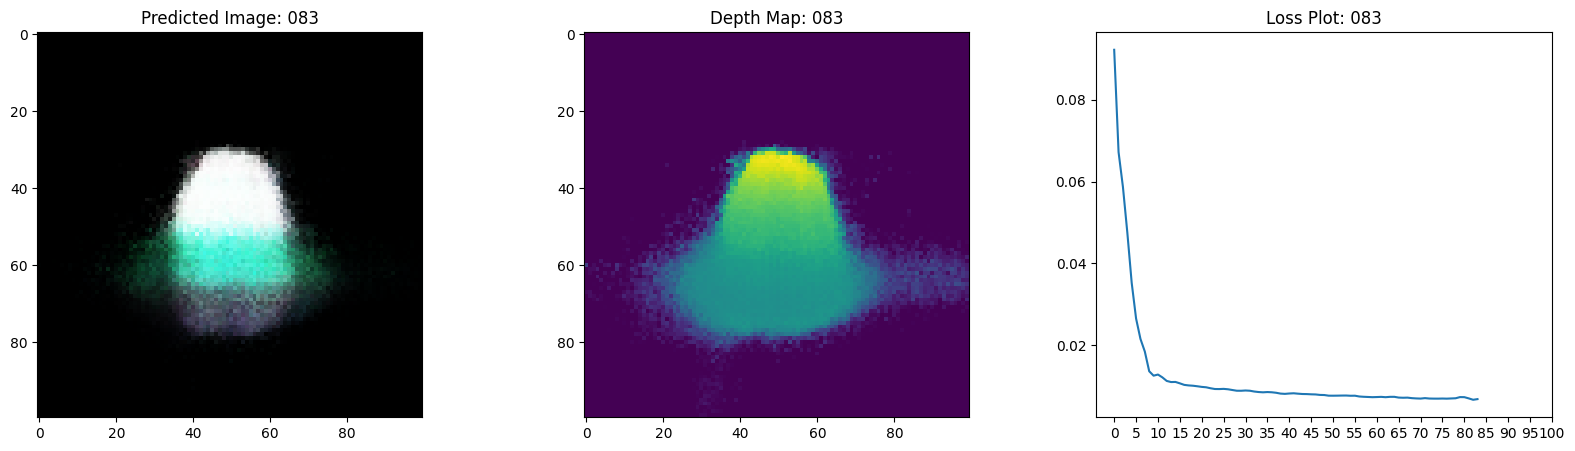

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0082 - psnr: 21.3770 - val_loss: 0.0158 - val_psnr: 18.3322
Epoch 85/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/stepep - loss: 0.0087 - psnr: 21.15


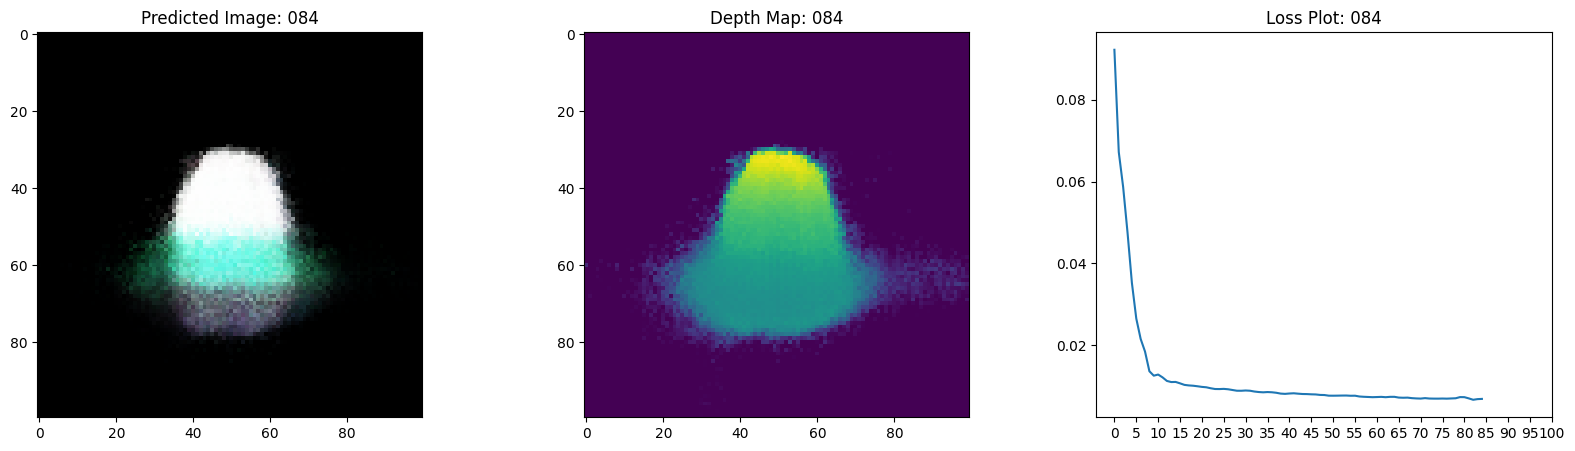

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0086 - psnr: 21.2086 - val_loss: 0.0152 - val_psnr: 18.5567
Epoch 86/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/stepep - loss: 0.0084 - psnr: 21.28


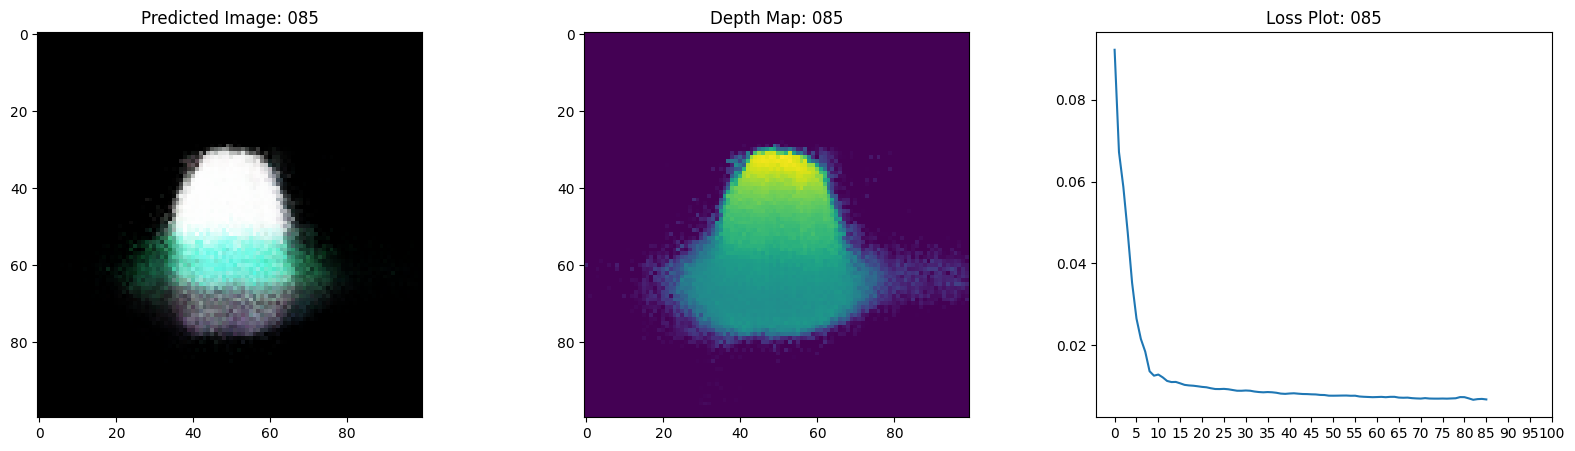

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0083 - psnr: 21.3377 - val_loss: 0.0153 - val_psnr: 18.5285
Epoch 87/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/stepep - loss: 0.0082 - psnr: 21.33


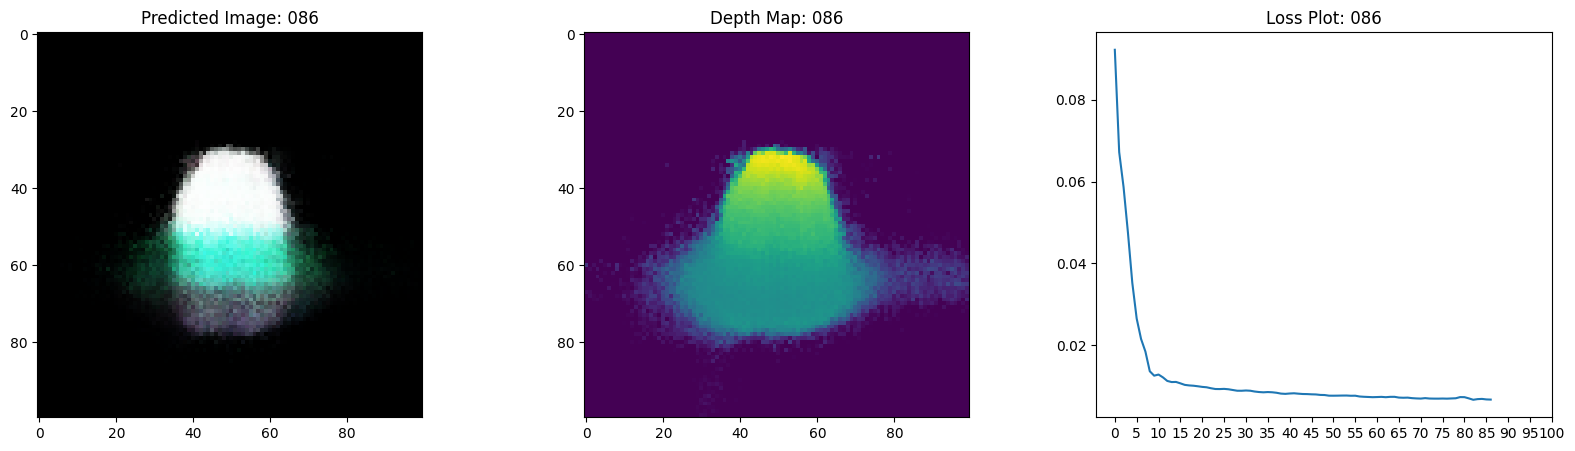

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0081 - psnr: 21.3877 - val_loss: 0.0152 - val_psnr: 18.5348
Epoch 88/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/stepep - loss: 0.0084 - psnr: 21.26


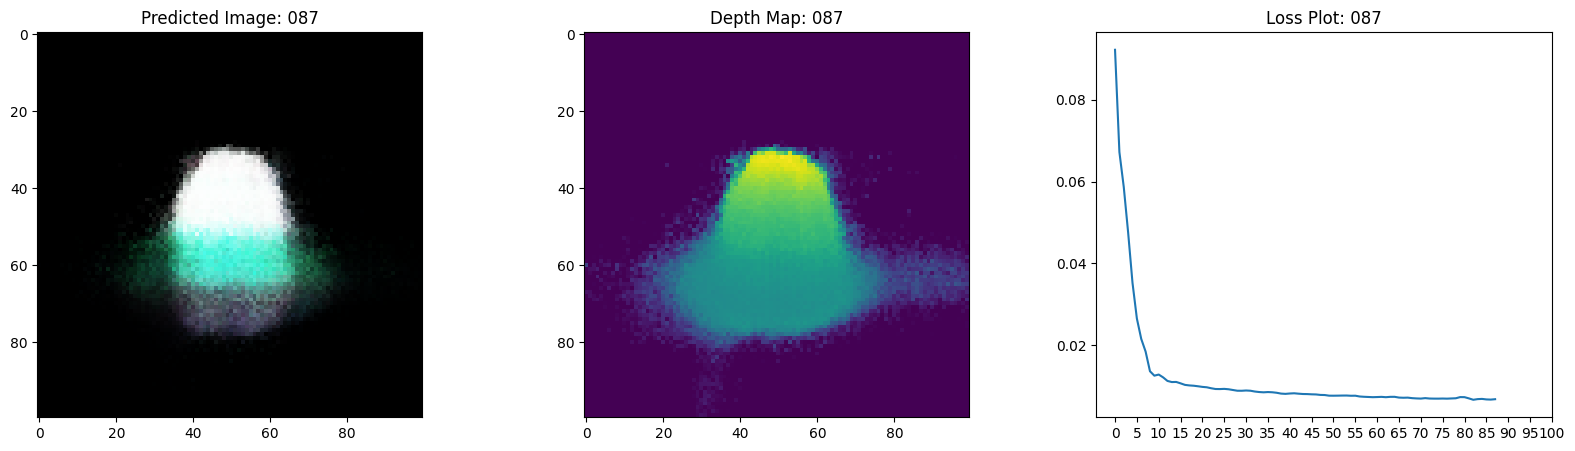

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0083 - psnr: 21.3169 - val_loss: 0.0152 - val_psnr: 18.5578
Epoch 89/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/stepep - loss: 0.0084 - psnr: 21.29


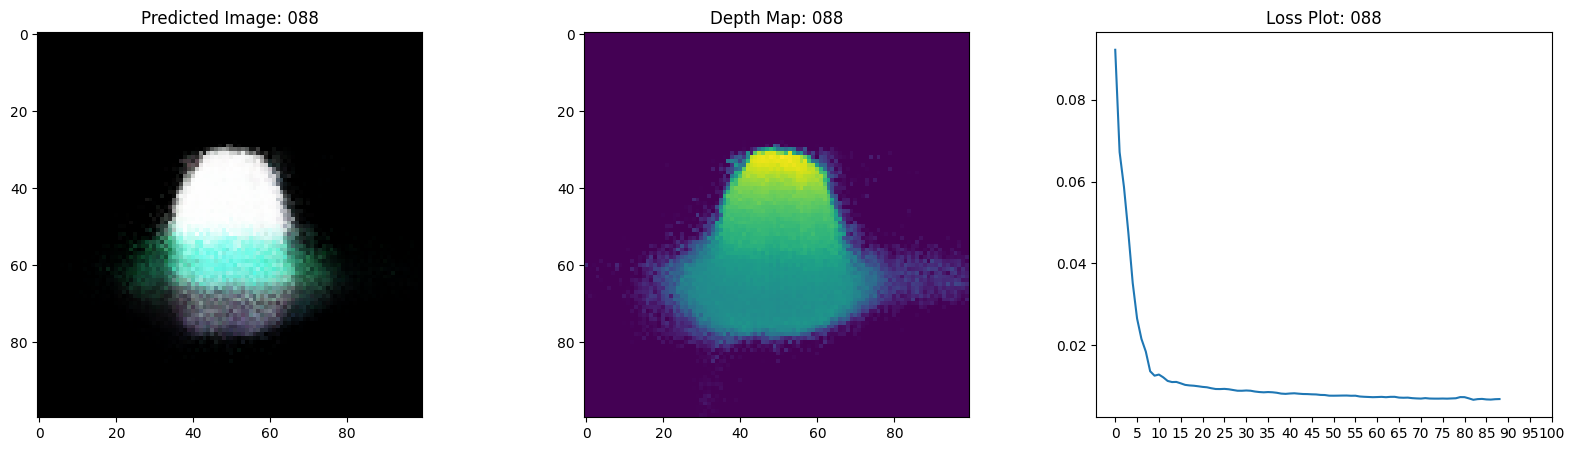

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0083 - psnr: 21.3470 - val_loss: 0.0149 - val_psnr: 18.6863
Epoch 90/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/stepep - loss: 0.0081 - psnr: 21.39


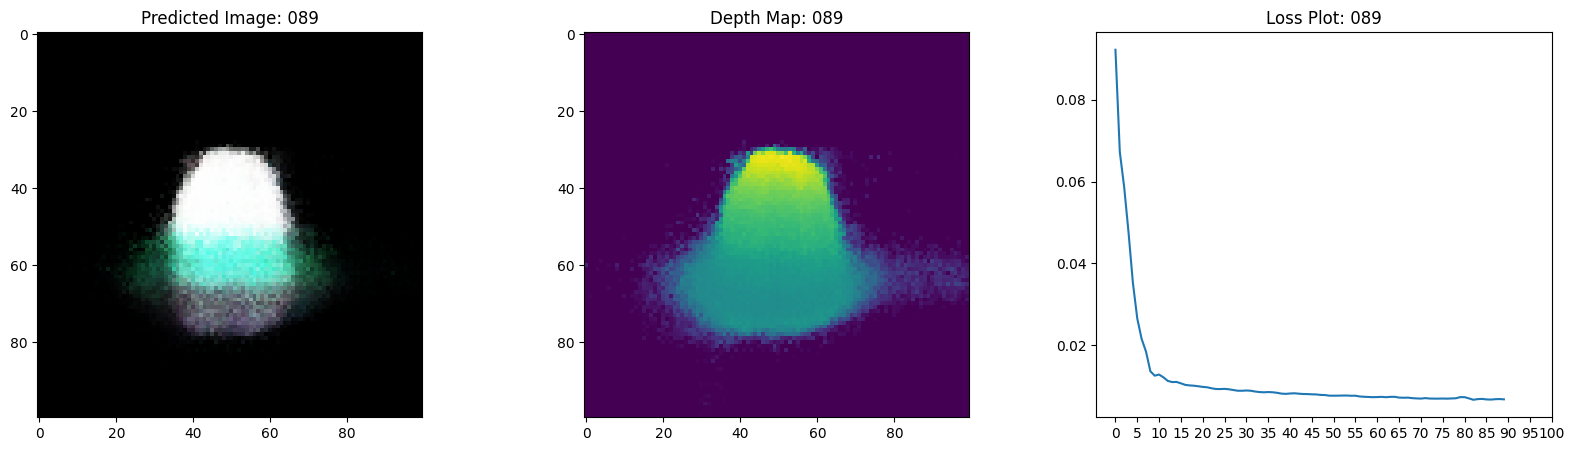

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0080 - psnr: 21.4348 - val_loss: 0.0143 - val_psnr: 18.8663
Epoch 91/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/stepep - loss: 0.0081 - psnr: 21.39


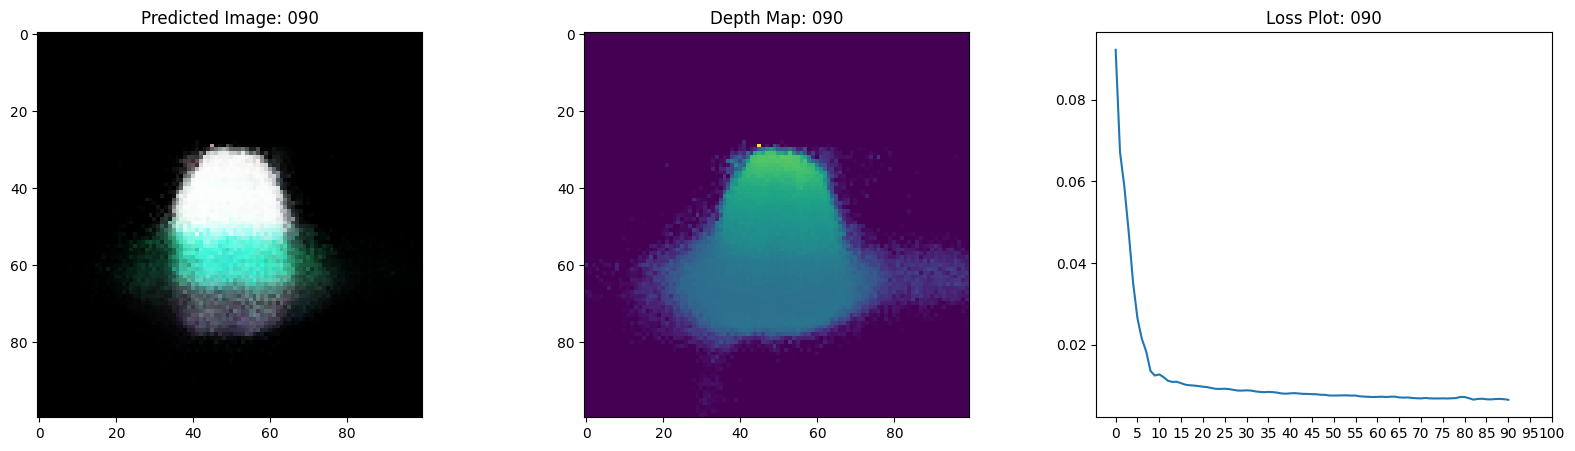

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0080 - psnr: 21.4465 - val_loss: 0.0151 - val_psnr: 18.6279
Epoch 92/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/stepep - loss: 0.0083 - psnr: 21.36


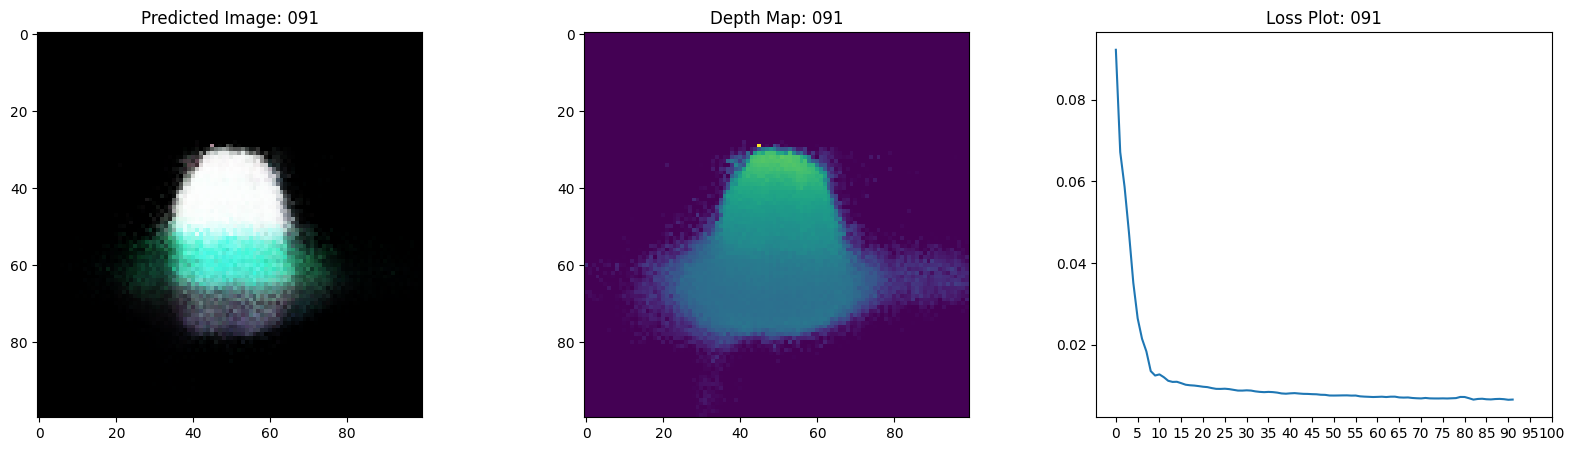

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0082 - psnr: 21.4122 - val_loss: 0.0151 - val_psnr: 18.6033
Epoch 93/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/stepep - loss: 0.0084 - psnr: 21.32


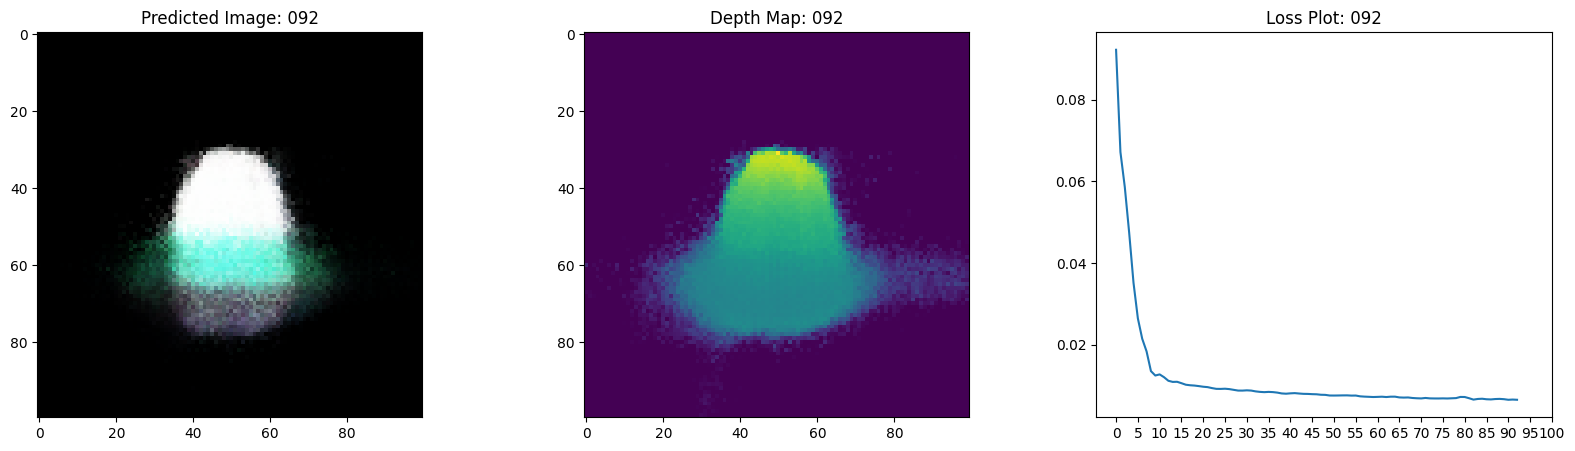

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0082 - psnr: 21.3827 - val_loss: 0.0150 - val_psnr: 18.6626
Epoch 94/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/stepep - loss: 0.0082 - psnr: 21.38


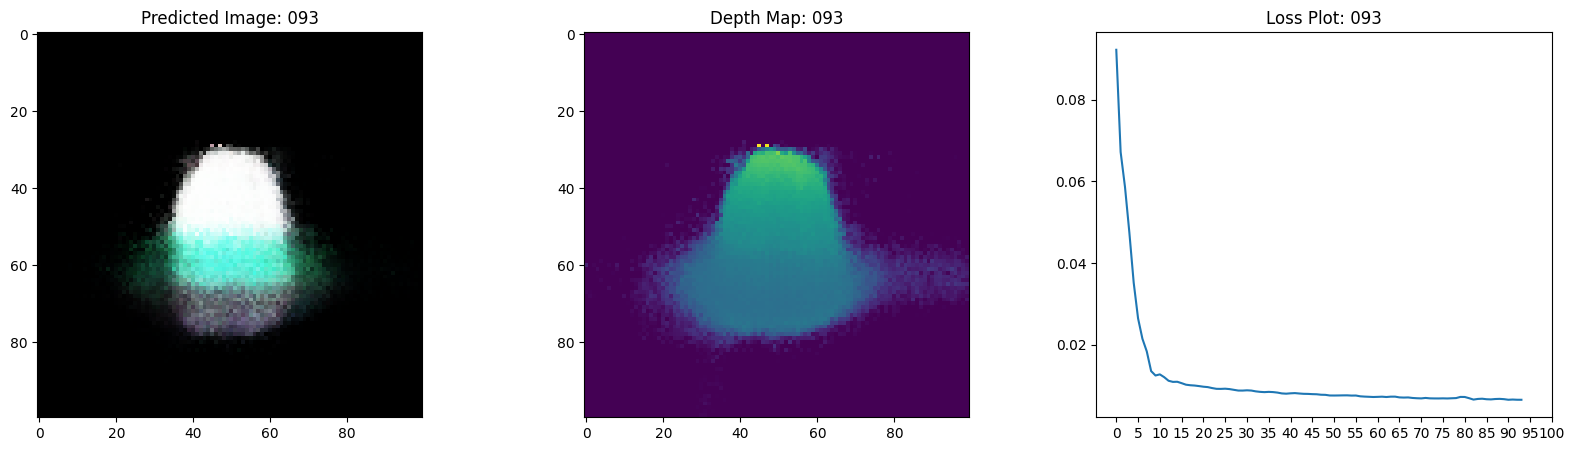

16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0081 - psnr: 21.4373 - val_loss: 0.0146 - val_psnr: 18.7704
Epoch 95/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/stepep - loss: 0.0079 - psnr: 21.51


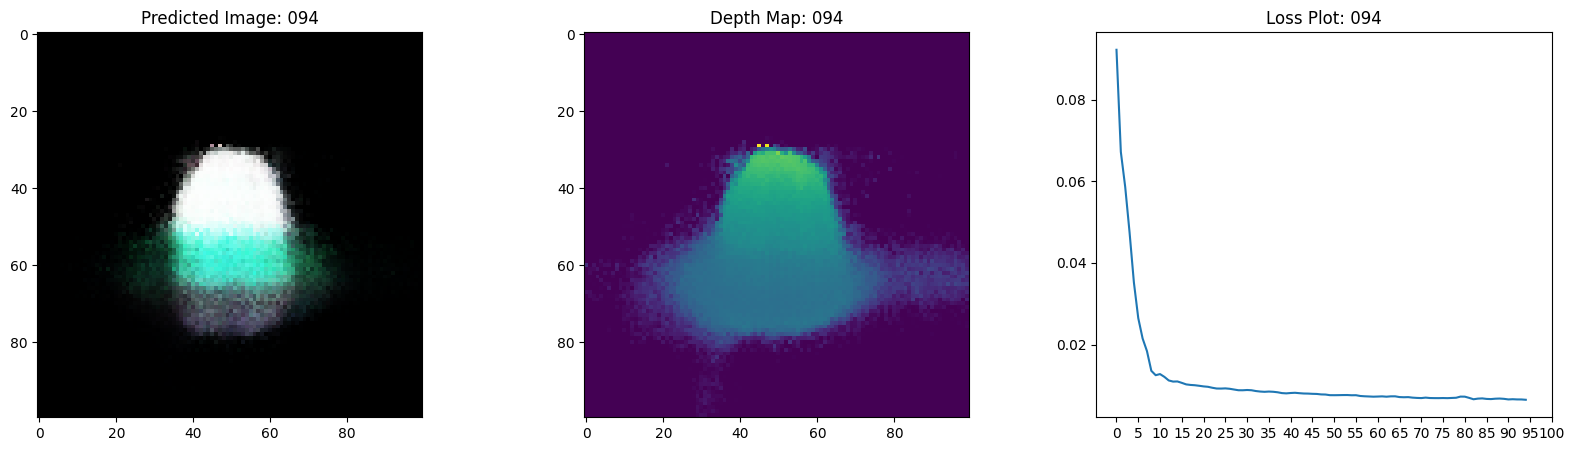

16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0078 - psnr: 21.5617 - val_loss: 0.0155 - val_psnr: 18.5032
Epoch 96/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/stepep - loss: 0.0083 - psnr: 21.37


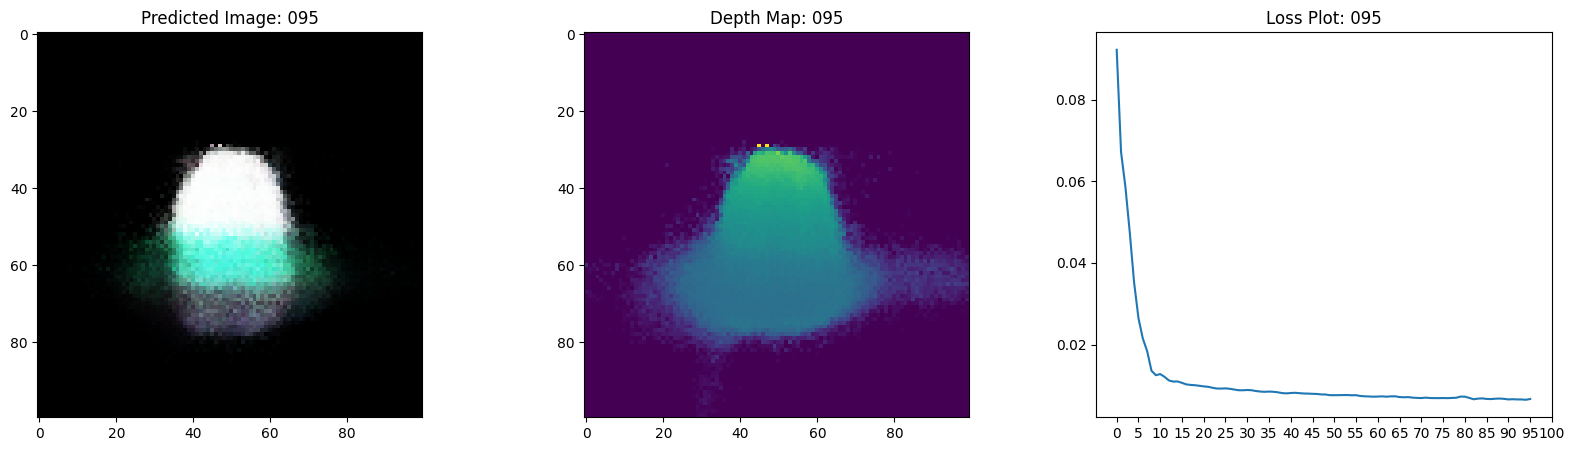

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0082 - psnr: 21.4208 - val_loss: 0.0151 - val_psnr: 18.6113
Epoch 97/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/stepep - loss: 0.0082 - psnr: 21.39


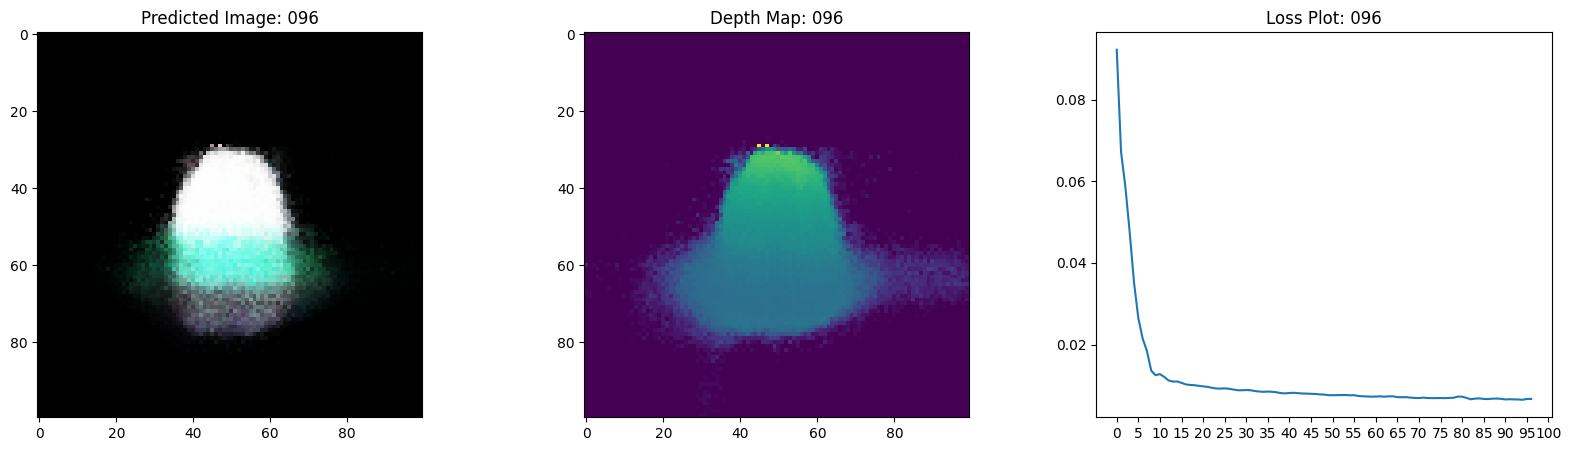

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0081 - psnr: 21.4411 - val_loss: 0.0148 - val_psnr: 18.7153
Epoch 98/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/stepep - loss: 0.0079 - psnr: 21.47


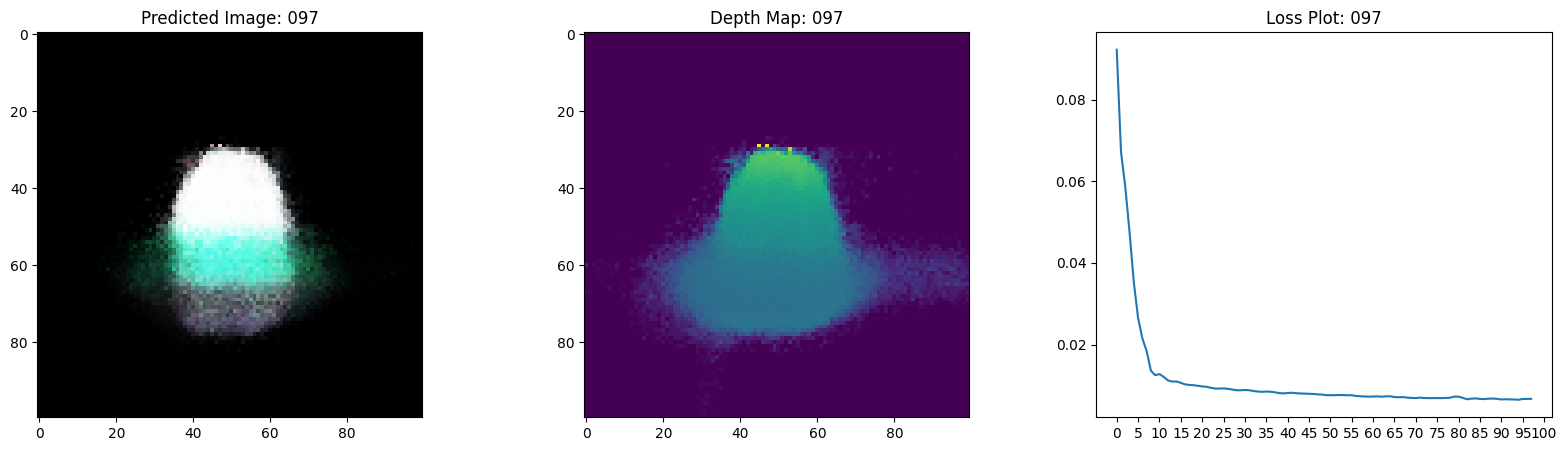

16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0078 - psnr: 21.5143 - val_loss: 0.0141 - val_psnr: 18.9431
Epoch 99/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/stepep - loss: 0.0079 - psnr: 21.44


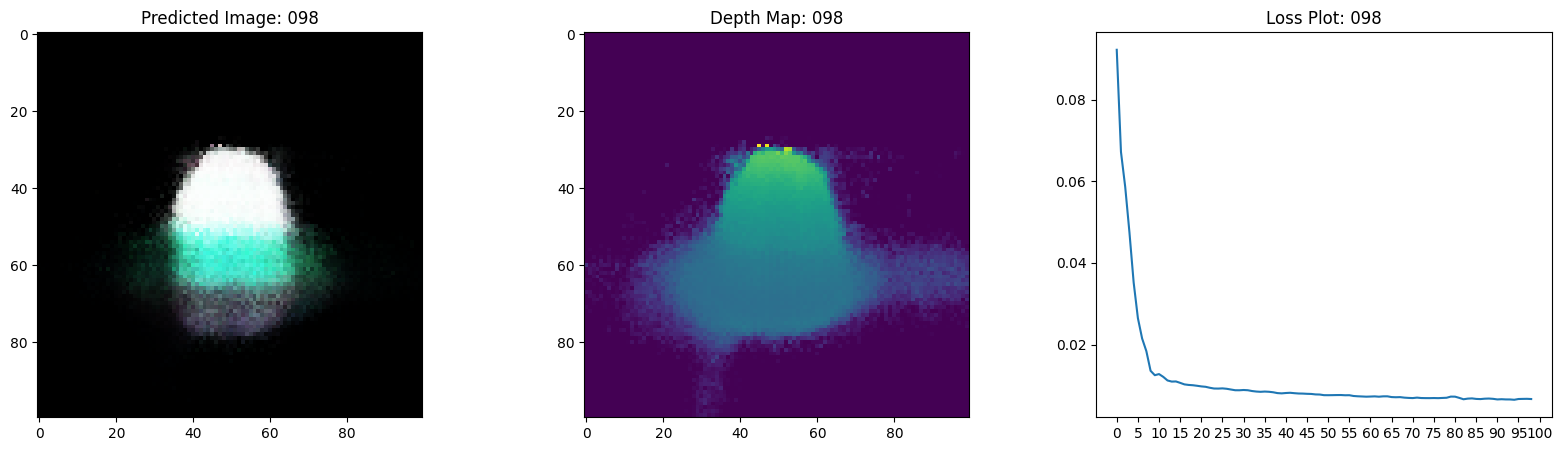

16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0078 - psnr: 21.4877 - val_loss: 0.0151 - val_psnr: 18.6575
Epoch 100/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/stepep - loss: 0.0082 - psnr: 21.44


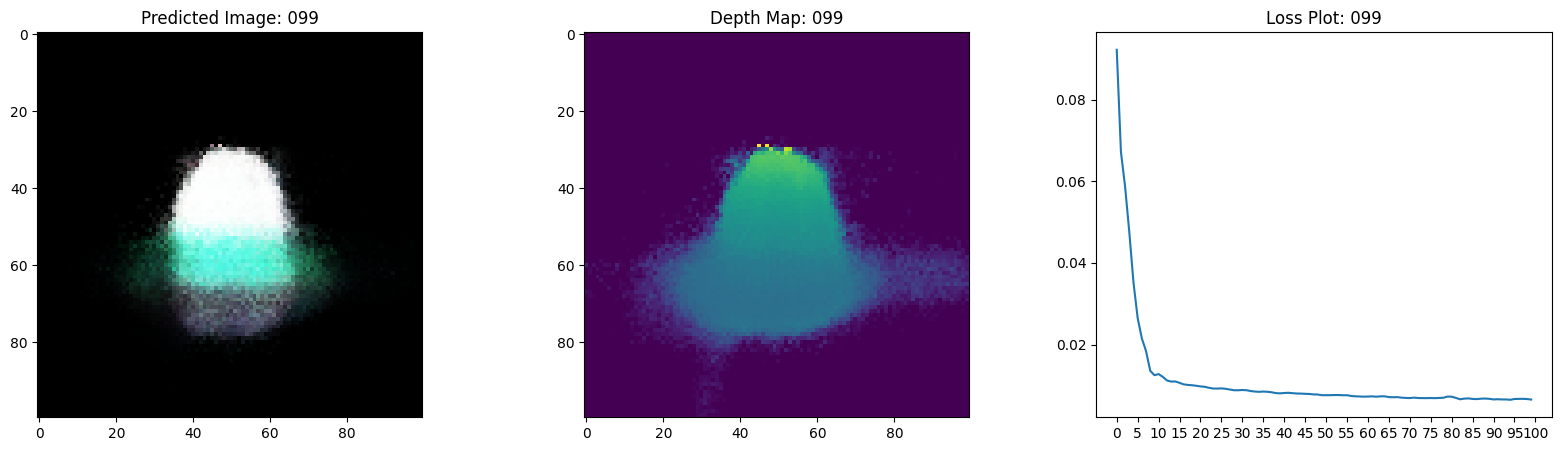

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0081 - psnr: 21.4914 - val_loss: 0.0146 - val_psnr: 18.7974


100%|██████████| 100/100 [00:02<00:00, 44.77it/s]


In [5]:
class NeRF(keras.Model):
    def __init__(self, nerf_model):
        super().__init__()
        self.nerf_model = nerf_model

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.psnr_metric = keras.metrics.Mean(name="psnr")

    def train_step(self, inputs):
        # Get the images and the rays.
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        with tf.GradientTape() as tape:
            # Get the predictions from the model.
            rgb, _ = render_rgb_depth(
                model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
            )
            loss = self.loss_fn(images, rgb)

        # Get the trainable variables.
        trainable_variables = self.nerf_model.trainable_variables

        # Get the gradeints of the trainiable variables with respect to the loss.
        gradients = tape.gradient(loss, trainable_variables)

        # Apply the grads and optimize the model.
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

        # Get the PSNR of the reconstructed images and the source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    def test_step(self, inputs):
        # Get the images and the rays.
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        # Get the predictions from the model.
        rgb, _ = render_rgb_depth(
            model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
        )
        loss = self.loss_fn(images, rgb)

        # Get the PSNR of the reconstructed images and the source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.psnr_metric]


test_imgs, test_rays = next(iter(train_ds))
test_rays_flat, test_t_vals = test_rays

loss_list = []


class TrainMonitor(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss = logs["loss"]
        loss_list.append(loss)
        test_recons_images, depth_maps = render_rgb_depth(
            model=self.model.nerf_model,
            rays_flat=test_rays_flat,
            t_vals=test_t_vals,
            rand=True,
            train=False,
        )

        # Plot the rgb, depth and the loss plot.
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        ax[0].imshow(keras.utils.array_to_img(test_recons_images[0]))
        ax[0].set_title(f"Predicted Image: {epoch:03d}")

        ax[1].imshow(keras.utils.array_to_img(depth_maps[0, ..., None]))
        ax[1].set_title(f"Depth Map: {epoch:03d}")

        ax[2].plot(loss_list)
        ax[2].set_xticks(np.arange(0, EPOCHS + 1, 5.0))
        ax[2].set_title(f"Loss Plot: {epoch:03d}")

        fig.savefig(f"images/{epoch:03d}.png")
        plt.show()
        plt.close()


num_pos = H * W * NUM_SAMPLES
nerf_model = get_nerf_model(num_layers=8, num_pos=num_pos)

model = NeRF(nerf_model)
model.compile(
    optimizer=keras.optimizers.Adam(), loss_fn=keras.losses.MeanSquaredError()
)

# Create a directory to save the images during training.
if not os.path.exists("images"):
    os.makedirs("images")

model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[TrainMonitor()],
)


def create_gif(path_to_images, name_gif):
    filenames = glob.glob(path_to_images)
    filenames = sorted(filenames)
    images = []
    for filename in tqdm(filenames):
        images.append(imageio.imread(filename))
    kargs = {"duration": 0.25}
    imageio.mimsave(name_gif, images, "GIF", **kargs)


create_gif("images/*.png", "training.gif")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


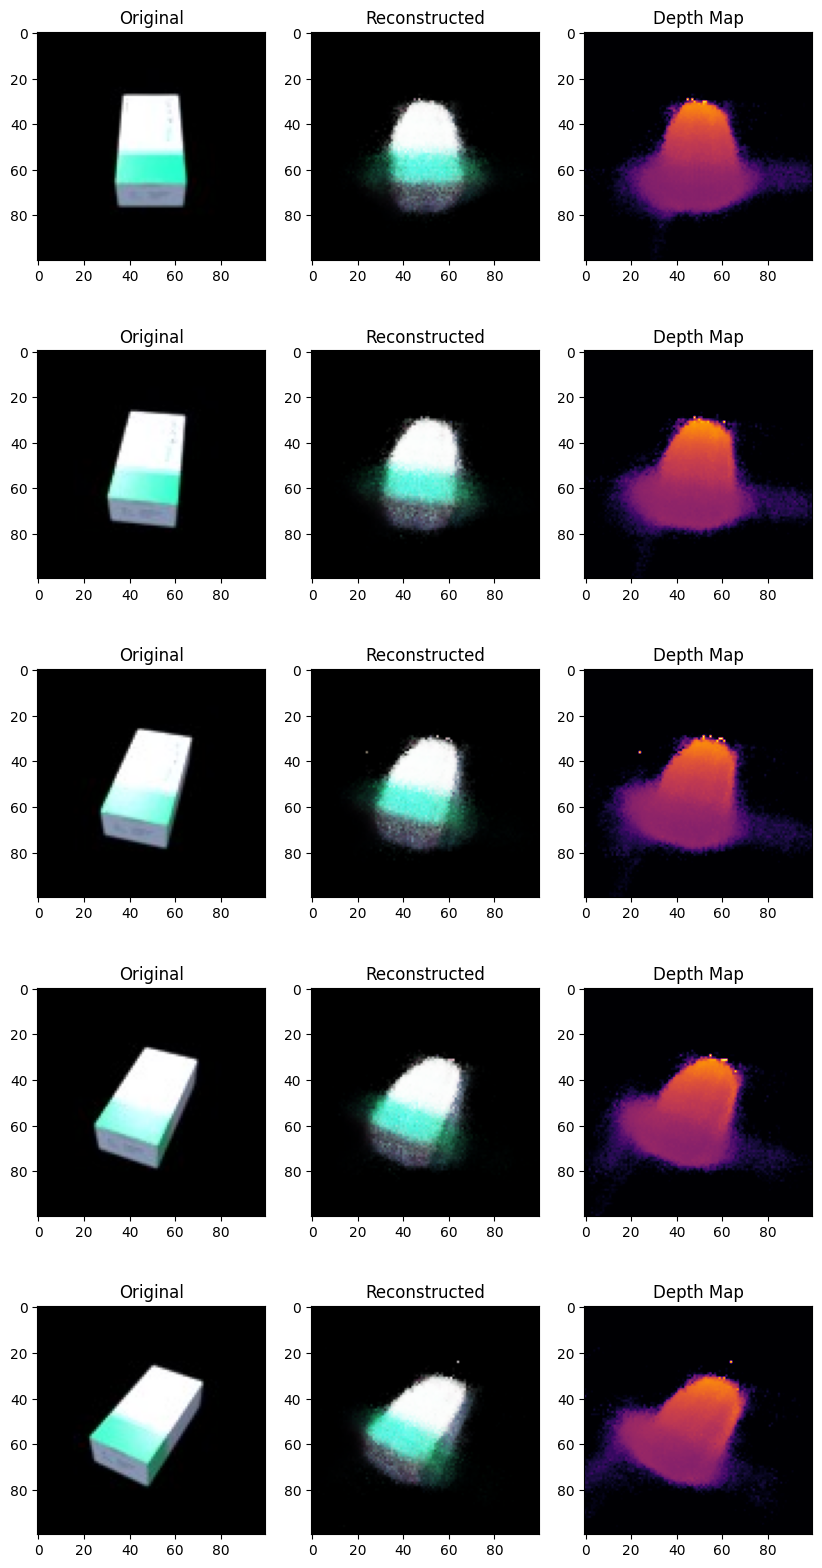

In [6]:
# Get the trained NeRF model and infer.
nerf_model = model.nerf_model
test_recons_images, depth_maps = render_rgb_depth(
    model=nerf_model,
    rays_flat=test_rays_flat,
    t_vals=test_t_vals,
    rand=True,
    train=False,
)

# Create subplots.
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 20))

for ax, ori_img, recons_img, depth_map in zip(
    axes, test_imgs, test_recons_images, depth_maps
):
    ax[0].imshow(keras.utils.array_to_img(ori_img))
    ax[0].set_title("Original")

    ax[1].imshow(keras.utils.array_to_img(recons_img))
    ax[1].set_title("Reconstructed")

    ax[2].imshow(keras.utils.array_to_img(depth_map[..., None]), cmap="inferno")
    ax[2].set_title("Depth Map")

In [7]:
!pip install imageio[ffmpeg]
!pip install imageio

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 54.9 MB/s eta 0:00:00:00:0100:01


In [8]:
def get_translation_t(t):
    """Get the translation matrix for movement in t."""
    matrix = [
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, t],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def get_rotation_phi(phi):
    """Get the rotation matrix for movement in phi."""
    matrix = [
        [1, 0, 0, 0],
        [0, tf.cos(phi), -tf.sin(phi), 0],
        [0, tf.sin(phi), tf.cos(phi), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def get_rotation_theta(theta):
    """Get the rotation matrix for movement in theta."""
    matrix = [
        [tf.cos(theta), 0, -tf.sin(theta), 0],
        [0, 1, 0, 0],
        [tf.sin(theta), 0, tf.cos(theta), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def pose_spherical(theta, phi, t):
    """
    Get the camera to world matrix for the corresponding theta, phi
    and t.
    """
    c2w = get_translation_t(t)
    c2w = get_rotation_phi(phi / 180.0 * np.pi) @ c2w
    c2w = get_rotation_theta(theta / 180.0 * np.pi) @ c2w
    c2w = np.array([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]) @ c2w
    return c2w


rgb_frames = []
batch_flat = []
batch_t = []

# Iterate over different theta value and generate scenes.
for index, theta in tqdm(enumerate(np.linspace(0.0, 360.0, 120, endpoint=False))):
    # Get the camera to world matrix.
    c2w = pose_spherical(theta, -30.0, 4.0)

    #
    ray_oris, ray_dirs = get_rays(H, W, focal, c2w)
    rays_flat, t_vals = render_flat_rays(
        ray_oris, ray_dirs, near=2.0, far=6.0, num_samples=NUM_SAMPLES, rand=False
    )

    if index % BATCH_SIZE == 0 and index > 0:
        batched_flat = tf.stack(batch_flat, axis=0)
        batch_flat = [rays_flat]

        batched_t = tf.stack(batch_t, axis=0)
        batch_t = [t_vals]

        rgb, _ = render_rgb_depth(
            nerf_model, batched_flat, batched_t, rand=False, train=False
        )

        temp_rgb = [np.clip(255 * img, 0.0, 255.0).astype(np.uint8) for img in rgb]

        rgb_frames = rgb_frames + temp_rgb
    else:
        batch_flat.append(rays_flat)
        batch_t.append(t_vals)

rgb_video = "rgb_video.mp4"
imageio.mimwrite(rgb_video, rgb_frames, fps=30, quality=7, macro_block_size=None)

1it [00:00,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


6it [00:02,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


11it [00:04,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


16it [00:05,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


21it [00:07,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


26it [00:08,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


31it [00:10,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


36it [00:11,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


41it [00:13,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


46it [00:14,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


51it [00:16,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


56it [00:17,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


61it [00:19,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


66it [00:20,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


71it [00:22,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


76it [00:23,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


81it [00:25,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


86it [00:26,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


91it [00:28,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


96it [00:29,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


101it [00:31,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


106it [00:32,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


111it [00:34,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


120it [00:36,  3.32it/s]
/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
[swscaler @ 0x6202c80] Warning: data is not aligned! This can lead to a speed loss


In [9]:
model.save('ModelNERF.keras')

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_api.py:100: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)
